In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import pickle
import os
import plotnine
import warnings
from plotnine import *
import pandas as pd
from pandas import Series
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error
from kerasAC.generators import *
import pybedtools

Using TensorFlow backend.


## Select GPU

In [3]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
!env | grep "CUDA"

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
CUDA_VISIBLE_DEVICES=0
CUDA_HOME=/usr/local/cuda-10.0


## Get Model and Peak File Addresses

In [4]:
idr_peaks=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/idr.optimal.narrowPeaks.txt','r').read().strip().split('\n')
samples=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/samples.txt','r').read().strip().split('\n')
model_dict={}
idr_dict={}
for sample in samples:
    print(sample)
    model_dict[sample]='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/mean/'+sample+'.model.'
    for idr_peaks_file in idr_peaks:
        if idr_peaks_file.__contains__(sample):
            idr_dict[sample]=idr_peaks_file

AD_ADAD_CAUD
AD_ADAD_HIPP
AD_ADAD_PARL
AD_ADAD_SMTG
AD_CTRH_CAUD
AD_CTRH_HIPP
AD_CTRH_PARL
AD_CTRH_SMTG
AD_CTRL_CAUD
AD_CTRL_HIPP
AD_CTRL_PARL
AD_CTRL_SMTG
AD_LOAD_CAUD
AD_LOAD_HIPP
AD_LOAD_PARL
AD_LOAD_SMTG
PD_CTRL_CAUD
PD_CTRL_HIPP
PD_CTRL_MDFG
PD_CTRL_MDTG
PD_CTRL_PTMN
PD_CTRL_SUNI
PD_GBA1_CAUD
PD_GBA1_HIPP
PD_GBA1_MDFG
PD_GBA1_MDTG
PD_GBA1_PTMN
PD_GBA1_SUNI
PD_LOPD_CAUD
PD_LOPD_HIPP
PD_LOPD_MDFG
PD_LOPD_MDTG
PD_LOPD_PTMN
PD_LOPD_SUNI
PD_LRRK_CAUD
PD_LRRK_HIPP
PD_LRRK_MDFG
PD_LRRK_MDTG
PD_LRRK_PTMN
PD_LRRK_SUNI


## Function to separate alternate alleles into individual rows

In [48]:
def format_snps(old_df, alt_col):                                               
    multirow = old_df[alt_col].str.split(',').apply(Series, 1).stack()          
    multirow.index = multirow.index.droplevel(-1)                               
    multirow.name = alt_col                                                     
    x = old_df.columns                                                          
    del old_df[alt_col]                                                         
    new_df = old_df.join(multirow)                                              
    new_df = new_df[x]                                                          
    return new_df

## Format LD Buddies

In [42]:
ld_buddy_list = ['GWAS_Alzheimers_Kunkle_2019_snps.with.ld.buddies_AllSNPs-hg38', 'GWAS_Parkinsons_23andme_2018_snps.with.ld.buddies_AllSNPs-hg38']

for gwas_file in ld_buddy_list:
    print(gwas_file)
    gwas = pd.read_csv('/mnt/lab_data3/soumyak/adpd/gwas/'+gwas_file+'.txt', sep='\t', keep_default_na=False)
    gwas.drop(['Unnamed: 0'], axis=1, inplace=True)
    gwas['start'] = gwas['start'] + 1
    gwas['end'] = gwas['end'] + 1
    new_cols = {}
    for i in gwas.columns:
        new_cols[i] = i.upper()
    gwas.rename(columns=new_cols, inplace=True)
    if '23andme' in gwas_file:
        variants = pd.read_csv('/mnt/lab_data3/soumyak/adpd/gwas/PD_var.vcf', sep='\t')
    else:
        variants = pd.read_csv('/mnt/lab_data3/soumyak/adpd/gwas/AD_var.vcf', sep='\t')
    display(variants.head())
    display(gwas.head())
    gwas_rsid = gwas.merge(variants, how='inner', left_on=['SEQNAMES','START'], right_on=['CHROM','POS'])
    gwas_rsid = gwas_rsid[['SEQNAMES','START','END','ID','REF','ALT','R2_WITH_LEAD_SNP','LEAD_CHR','LEAD_POS','LEAD_LOCUS','RSID_LEAD']]
    gwas_rsid.rename(columns={'SEQNAMES':'CHR'}, inplace=True)
    new_gwas = format_snps(gwas_rsid, 'ALT')
    #new_gwas = gwas_rsid
    display(new_gwas.head())
    new_gwas.to_csv('/mnt/lab_data3/soumyak/adpd/gwas/'+gwas_file+'.formatted.txt', sep='\t', index=False)

GWAS_Alzheimers_Kunkle_2019_snps.with.ld.buddies_AllSNPs-hg38


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,chr19,1050875,rs12151021,A,"G,T",.,.,RS=12151021;RSPOS=1050875;dbSNPBuildID=120;SSR...
1,chr19,18425606,rs8106096,C,"A,G",.,.,RS=8106096;RSPOS=18425606;dbSNPBuildID=116;SSR...
2,chr19,18445939,rs34053595,T,C,.,.,RS=34053595;RSPOS=18445939;dbSNPBuildID=126;SS...
3,chr19,18448066,rs8111708,A,"G,T",.,.,RS=8111708;RSPOS=18448066;dbSNPBuildID=116;SSR...
4,chr19,18448847,rs34010330,G,"C,T",.,.,RS=34010330;RSPOS=18448847;dbSNPBuildID=126;SS...


,SEQNAMES,START,END,WIDTH,STRAND,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_SNP,RSID_LEAD
0,chr19,44883210,44883211,1,*,1.0,chr19,44883210,1,NA,NA
1,chr2,127135234,127135235,1,*,1.0,chr2,127135234,2,rs6733839,rs6733839
2,chr8,27610986,27610987,1,*,1.0,chr8,27610986,3,rs867230,rs867230
3,chr11,60254475,60254476,1,*,1.0,chr11,60254475,4,rs1582763,rs1582763
4,chr1,207577223,207577224,1,*,1.0,chr1,207577223,5,rs679515,rs679515


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD
0,chr19,44883210,44883211,rs142042446,G,GTAA,1.0,chr19,44883210,1,NA
1,chr2,127135234,127135235,rs6733839,C,T,1.0,chr2,127135234,2,rs6733839
2,chr8,27610986,27610987,rs867230,C,A,1.0,chr8,27610986,3,rs867230
3,chr11,60254475,60254476,rs1582763,G,A,1.0,chr11,60254475,4,rs1582763
4,chr1,207577223,207577224,rs679515,T,A,1.0,chr1,207577223,5,rs679515


GWAS_Parkinsons_23andme_2018_snps.with.ld.buddies_AllSNPs-hg38


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,chr12,31348013,rs1270831448,ACAGGCGTG,A,.,.,RS=1270831448;RSPOS=31348014;dbSNPBuildID=151;...
1,chr12,31348018,rs141917877,C,T,.,.,RS=141917877;RSPOS=31348018;dbSNPBuildID=134;S...
2,chr12,32338739,rs140427697,A,G,.,.,RS=140427697;RSPOS=32338739;dbSNPBuildID=134;S...
3,chr12,32358558,rs185414076,G,A,.,.,RS=185414076;RSPOS=32358558;dbSNPBuildID=135;S...
4,chr12,32389884,rs148707891,G,C,.,.,RS=148707891;RSPOS=32389884;dbSNPBuildID=134;S...


,SEQNAMES,START,END,WIDTH,STRAND,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_SNP,RSID_LEAD
0,chr12,40340400,40340401,1,*,1.0,chr12,40340400,1,rs34637584,rs34637584
1,chr4,89704960,89704961,1,*,1.0,chr4,89704960,2,rs356182,rs356182
2,chr17,46105479,46105480,1,*,1.0,chr17,46105479,3,NA,NA
3,chr17,45589482,45589483,1,*,1.0,chr17,45589482,4,NA,NA
4,chr12,33946256,33946257,1,*,1.0,chr12,33946256,5,rs183981418,rs183981418


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD
0,chr12,40340400,40340401,rs34637584,G,A,1.0,chr12,40340400,1,rs34637584
1,chr4,89704960,89704961,rs356182,G,A,1.0,chr4,89704960,2,rs356182
2,chr17,46105479,46105480,rs112790197,T,TG,1.0,chr17,46105479,3,NA
3,chr17,45589482,45589483,rs201647884,A,AAAGAAG,1.0,chr17,45589482,4,NA
3,chr17,45589482,45589483,rs201647884,A,AAGAAG,1.0,chr17,45589482,4,NA


## Constant Addresses

In [16]:
ref_fasta='/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta'
snp_prefix='/mnt/lab_data3/soumyak/adpd/gwas/'

## Get Predictions from all Folds

In [18]:
def get_preds_all_folds(task, gwas, ref_fasta=ref_fasta, snp_prefix=snp_prefix, n_folds=10):
    
    if gwas == 'AD':
        all_snps_basename='GWAS_Alzheimers_Kunkle_2019_snps.with.ld.buddies_AllSNPs-hg38.formatted.txt'
    else:
        all_snps_basename='GWAS_Parkinsons_23andme_2018_snps.with.ld.buddies_AllSNPs-hg38.formatted.txt'

    model_prefix=model_dict[task]
    idr_peaks=idr_dict[task]
    
    for fold in range(n_folds): 
        print(fold)
        #load the model
        custom_objects={"recall":recall,
                        "sensitivity":recall,
                        "specificity":specificity,
                        "fpr":fpr,
                        "fnr":fnr,
                        "precision":precision,
                        "f1":f1,
                        "ambig_binary_crossentropy":ambig_binary_crossentropy,
                        "ambig_mean_squared_error":ambig_mean_squared_error}
        model=load_model(model_prefix+str(fold),custom_objects=custom_objects)
        print("loaded model")
        #get reference allele predictions 
        snp_file='/'.join([snp_prefix,all_snps_basename])+'.'+str(fold)
        snp_ref_generator=SNPGenerator(data_path=snp_file,
                                       ref_fasta=ref_fasta,
                                       allele_col="REF")
        snp_ref_predictions=model.predict_generator(snp_ref_generator,
                                                    max_queue_size=5000, 
                                                    workers=40, 
                                                    use_multiprocessing=True,
                                                    verbose=1)
        print("got snp ref predictions")
        #get alternate allele predictions 
        snp_alt_generator=SNPGenerator(snp_file,
                                       ref_fasta=ref_fasta,
                                       allele_col="ALT")
        snp_alt_predictions=model.predict_generator(snp_alt_generator,
                                                    max_queue_size=5000, 
                                                    workers=40, 
                                                    use_multiprocessing=True, verbose=1)
        print("got snp alt predictions")
        snp_ref_generator.data['ref_pred']=snp_ref_predictions
        snp_ref_generator.data['alt_pred']=snp_alt_predictions
        snp_ref_generator.data.to_csv(task+'.'+str(fold)+'.GWAS_SNP_predictions.txt',sep='\t')

In [19]:
get_preds_all_folds('AD_ADAD_SMTG','AD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(44, 8)
1/1 [==============================] - 10s 10s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(44, 8)
1/1 [==============================] - 5s 5s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(37, 8)
1/1 [==============================] - 11s 11s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(37, 8)
1/1 [==============================] - 5s 5s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(127, 8)
1/1 [==============================] - 11s 11s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(127, 8)
1/1 [==============================] - 5s 5s/step

In [21]:
get_preds_all_folds('AD_CTRL_PARL','AD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(44, 8)
1/1 [==============================] - 11s 11s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(44, 8)
1/1 [==============================] - 5s 5s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(37, 8)
1/1 [==============================] - 12s 12s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(37, 8)
1/1 [==============================] - 5s 5s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(127, 8)
1/1 [==============================] - 12s 12s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(127, 8)
1/1 [==============================] - 5s 5s/step

In [ ]:
get_preds_all_folds('AD_ADAD_PARL','AD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(44, 8)
1/1 [==============================] - 14s 14s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(44, 8)
1/1 [==============================] - 6s 6s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(37, 8)
1/1 [==============================] - 14s 14s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(37, 8)
1/1 [==============================] - 5s 5s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(127, 8)


In [ ]:
get_preds_all_folds('AD_CTRL_HIPP','AD')

In [ ]:
get_preds_all_folds('PD_CTRL_HIPP','PD')

In [ ]:
get_preds_all_folds('PD_GBA1_HIPP','PD')

## Get Results from all Folds

In [7]:
def get_results_all_folds(task):
    print("TASK: ",task)
    for fold in range(10):
        print("FOLD: ",fold)
        snp_predictions=pd.read_csv(task+'.'+str(fold)+'.GWAS_SNP_predictions.txt',sep='\t')
        print("All SNPs:")
        display(snp_predictions.shape)
        snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
        idr_bed = pybedtools.BedTool(idr_peaks)
        pos_snps_bed = snp_bed.intersect(idr_bed, u=True)
        if pos_snps_bed.count() > 0:
            pos_snps = pybedtools.BedTool.to_dataframe(pos_snps_bed)
            pos_snps.columns = snp_predictions.columns
            print("SNPs in Peaks:")
            display(pos_snps.shape)
            plotnine.options.figure_size = (6,6)
            display((ggplot(pos_snps,
                aes(x="ref_pred",y="alt_pred",label='ID'))+
            geom_point(alpha=0.3,color='red')+
            theme_bw(20)+
            xlab("Reference Allele Prediction")+
            ylab("Alternate Allele Prediction")+
            ggtitle("GWAS Variants")))
            pos_snps['delta']=pos_snps['alt_pred']-pos_snps['ref_pred']
            pos_snp_predictions_sorted=pos_snps.sort_values(by=['delta'])
            print("Negative SNPs in Peaks:")
            display(pos_snp_predictions_sorted.head(10))
            print("Positive SNPs in Peaks:")
            display(pos_snp_predictions_sorted.tail(10))
        snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
        idr_bed = pybedtools.BedTool(idr_peaks)
        neg_snps_bed = snp_bed.intersect(idr_bed, v=True)
        if neg_snps_bed.count() > 0:
            neg_snps = pybedtools.BedTool.to_dataframe(neg_snps_bed)
            neg_snps.columns = snp_predictions.columns
            print("SNPs NOT in Peaks:")
            display(neg_snps.shape)
            plotnine.options.figure_size = (6,6)
            display((ggplot(neg_snps,
                aes(x="ref_pred",y="alt_pred",label='ID'))+
            geom_point(alpha=0.3,color='red')+
            theme_bw(20)+
            xlab("Reference Allele Prediction")+
            ylab("Alternate Allele Prediction")+
            ggtitle("GWAS Variants")))
            neg_snps['delta']=neg_snps['alt_pred']-neg_snps['ref_pred']
            neg_snp_predictions_sorted=neg_snps.sort_values(by=['delta'])
            print("Negative SNPs OUTSIDE Peaks:")
            display(neg_snp_predictions_sorted.head(10))
            print("Positive SNPs OUTSIDE Peaks:")
            display(neg_snp_predictions_sorted.tail(10))

TASK:  PD_CTRL_MDTG
FOLD:  0
All SNPs:


(35, 13)

SNPs in Peaks:


(3, 13)

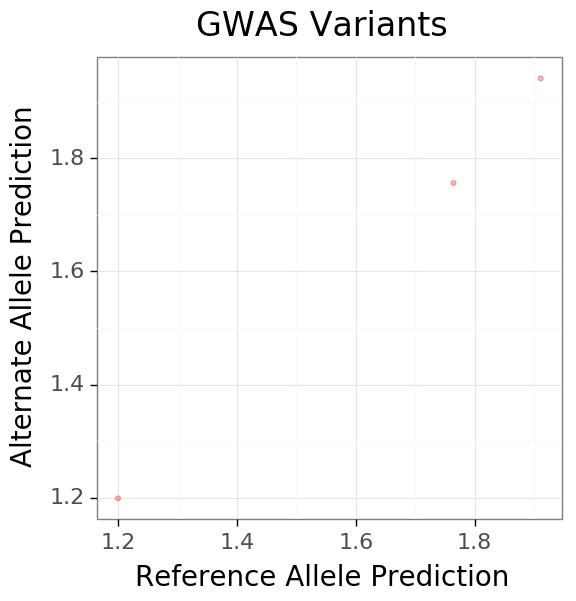

<ggplot: (8728129860956)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr1,155135691,155135692,rs12726330,G,C,1.000000,chr1,155135691,9,rs12726330,1.764637,1.756524,-0.008113
1,chr1,205750404,205750405,rs823114,G,A,0.953762,chr1,205770138,21,rs708723,1.199498,1.198593,-0.000904
2,chr1,8409729,8409730,rs2661868,C,T,0.984181,chr1,8390388,77,rs2708628,1.911468,1.941579,0.030111


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr1,155135691,155135692,rs12726330,G,C,1.000000,chr1,155135691,9,rs12726330,1.764637,1.756524,-0.008113
1,chr1,205750404,205750405,rs823114,G,A,0.953762,chr1,205770138,21,rs708723,1.199498,1.198593,-0.000904
2,chr1,8409729,8409730,rs2661868,C,T,0.984181,chr1,8390388,77,rs2708628,1.911468,1.941579,0.030111


SNPs NOT in Peaks:


(30, 13)

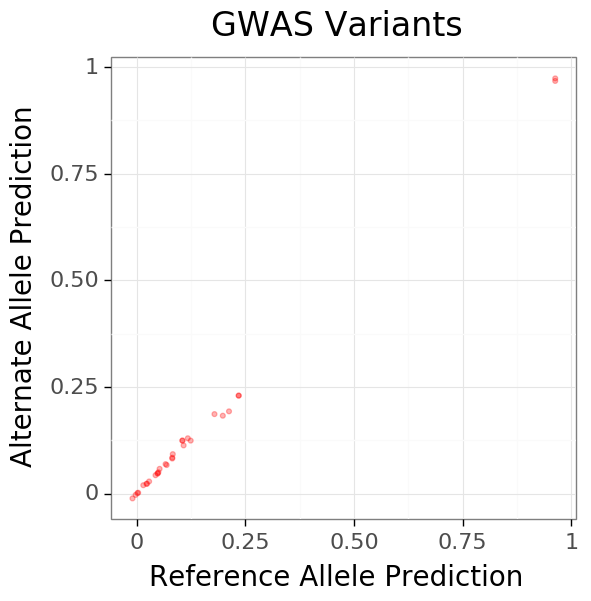

<ggplot: (-9223363306790055701)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr1,183922245,183922246,rs113076859,C,T,1.000000,chr1,183922245,50,rs113076859,0.212095,0.192823,-0.019272
14,chr1,155235587,155235588,rs12752133,C,T,0.812944,chr1,155135691,9,rs12726330,0.197836,0.182603,-0.015233
21,chr1,8380583,8380584,rs2636314,G,A,0.975367,chr1,8390388,77,rs2708628,0.234418,0.229631,-0.004787
22,chr1,8380583,8380584,rs2636314,G,C,0.975367,chr1,8390388,77,rs2708628,0.234418,0.229851,-0.004567
5,chr1,10405391,10405392,rs199959132,AAAC,A,1.000000,chr1,10405391,72,.,0.068514,0.066947,-0.001567
26,chr1,8406690,8406691,rs2748456,C,T,0.988415,chr1,8390388,77,rs2708628,-0.010125,-0.011303,-0.001179
25,chr1,8406157,8406158,rs2784738,G,C,0.988433,chr1,8390388,77,rs2708628,0.047868,0.046960,-0.000908
12,chr1,155148667,155148668,rs35682329,A,G,1.000000,chr1,155135691,9,rs12726330,0.002911,0.002010,-0.000901
23,chr1,8403450,8403451,rs2708631,C,T,0.986964,chr1,8390388,77,rs2708628,0.001393,0.001046,-0.000347
29,chr1,8440997,8440998,rs2784740,T,A,0.915383,chr1,8390388,77,rs2708628,0.023227,0.022967,-0.000260


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
8,chr1,246782994,246782995,rs149745071,C,T,1.000000,chr1,246782994,93,rs149745071,0.963262,0.967756,0.004494
16,chr1,155924191,155924192,rs547368930,CCTATAGTCCCAGCTA,C,0.828027,chr1,155850943,12,rs34032320,0.014786,0.019599,0.004813
28,chr1,8437498,8437499,rs2784739,T,G,0.892586,chr1,8390388,77,rs2708628,0.107600,0.112973,0.005373
13,chr1,155162560,155162561,rs35749011,G,A,0.962770,chr1,155135691,9,rs12726330,0.052282,0.057969,0.005687
3,chr1,119094055,119094056,rs76695140,A,G,1.000000,chr1,119094055,53,rs76695140,0.178651,0.186375,0.007724
11,chr1,155143675,155143676,rs12742181,C,T,1.000000,chr1,155135691,9,rs12726330,0.082629,0.092414,0.009786
7,chr1,246782994,246782995,rs149745071,C,A,1.000000,chr1,246782994,93,rs149745071,0.963262,0.973716,0.010454
0,chr1,155850943,155850944,rs34032320,G,C,1.000000,chr1,155850943,12,rs34032320,0.117297,0.129688,0.012391
19,chr1,205754444,205754445,rs823118,C,T,0.972244,chr1,205770138,21,rs708723,0.104769,0.124093,0.019324
18,chr1,205754444,205754445,rs823118,C,A,0.972244,chr1,205770138,21,rs708723,0.104769,0.124428,0.019659


FOLD:  1
All SNPs:


(58, 13)

SNPs NOT in Peaks:


(57, 13)

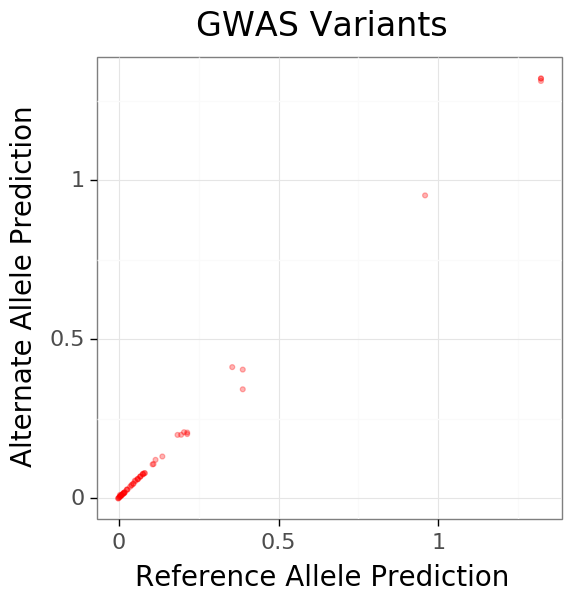

<ggplot: (-9223363308725186023)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
31,chr2,134782976,134782977,rs7599054,A,T,0.976667,chr2,134825938,37,rs6760237,0.388079,0.342261,-0.045818
6,chr19,2791655,2791656,rs59303624,G,T,1.000000,chr19,2791655,47,rs59303624,0.214237,0.201130,-0.013106
5,chr19,2791655,2791656,rs59303624,G,A,1.000000,chr19,2791655,47,rs59303624,0.214237,0.206026,-0.008211
47,chr19,2813855,2813856,rs146390273,C,CCT,0.879171,chr19,2791655,47,rs59303624,1.320964,1.313506,-0.007458
43,chr19,2788500,2788501,rs112713793,C,T,0.980779,chr19,2791655,47,rs59303624,0.136514,0.130535,-0.005979
45,chr19,2813805,2813806,rs73524732,G,A,0.879171,chr19,2791655,47,rs59303624,0.958432,0.953070,-0.005362
33,chr2,134790951,134790952,rs34284021,C,CAAG,0.966542,chr2,134825938,37,rs6760237,0.081245,0.078079,-0.003166
32,chr2,134790951,134790952,rs146112546,C,CAAG,0.966542,chr2,134825938,37,rs6760237,0.081245,0.078079,-0.003166
11,chr2,220851226,220851227,rs73993676,C,T,1.000000,chr2,220851226,99,rs73993676,0.017325,0.014767,-0.002558
10,chr2,46410382,46410383,rs150828230,G,A,1.000000,chr2,46410382,90,rs150828230,0.108986,0.106647,-0.002338


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
12,chr2,168299490,168299491,rs4667572,G,A,0.823437,chr2,168299085,13,rs13016703,0.025487,0.026368,0.000881
42,chr2,62495666,62495667,rs67825856,CG,C,0.973916,chr2,62495157,45,rs10211381,0.058855,0.059848,0.000993
21,chr2,101986680,101986681,rs17815304,G,A,0.842426,chr2,101988187,29,rs12467316,0.204379,0.207086,0.002707
34,chr2,134818984,134818985,rs6753334,A,G,0.980527,chr2,134825938,37,rs6760237,0.195335,0.198920,0.003585
28,chr2,134779549,134779550,rs6741007,T,G,0.977944,chr2,134825938,37,rs6760237,0.050553,0.054484,0.003931
44,chr19,2790688,2790689,rs8106185,C,T,0.955223,chr19,2791655,47,rs59303624,0.115223,0.119985,0.004762
1,chr2,134825938,134825939,rs6760237,A,C,1.000000,chr2,134825938,37,rs6760237,0.003950,0.009661,0.005711
49,chr19,2813959,2813960,rs113301220,A,G,0.873043,chr19,2791655,47,rs59303624,0.184007,0.198564,0.014557
30,chr2,134782976,134782977,rs7599054,A,G,0.976667,chr2,134825938,37,rs6760237,0.388079,0.404275,0.016196
7,chr2,126517671,126517672,rs77643088,G,C,1.000000,chr2,126517671,63,rs77643088,0.355192,0.412108,0.056916


FOLD:  2
All SNPs:


(70, 13)

SNPs in Peaks:


(0, 13)

AttributeError: 'list' object has no attribute 'keys'

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta


SNPs NOT in Peaks:


(68, 13)

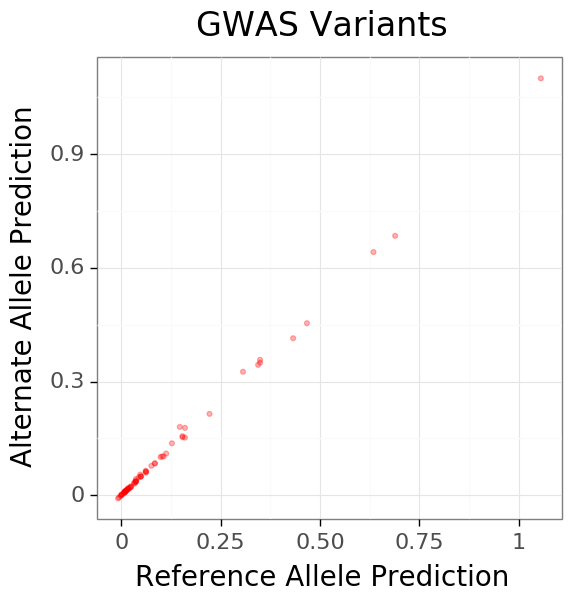

<ggplot: (-9223363308725232289)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
53,chr3,18227051,18227052,rs73034316,G,A,0.856038,chr3,18181950,87,rs13078687,0.432347,0.414181,-0.018165
0,chr3,183010401,183010402,rs5854965,CTAGG,C,1.000000,chr3,183010401,14,.,0.467118,0.453786,-0.013332
1,chr3,145333493,145333494,rs181870458,G,A,1.000000,chr3,145333493,35,rs181870458,0.160326,0.152003,-0.008323
15,chr3,146345697,146345698,rs116468365,G,A,0.947179,chr3,146323490,38,rs192689438,0.222113,0.214670,-0.007443
11,chr3,183010393,183010394,rs4074310,T,G,1.000000,chr3,183010401,14,.,0.688894,0.684265,-0.004629
22,chr3,18163667,18163668,rs35115317,G,A,0.996583,chr3,18181950,87,rs13078687,0.106583,0.102218,-0.004364
37,chr3,18177545,18177546,rs4688901,G,A,0.993187,chr3,18181950,87,rs13078687,0.023376,0.020281,-0.003095
10,chr3,183007683,183007684,rs11718171,A,G,0.865485,chr3,183010401,14,.,0.113132,0.110234,-0.002899
19,chr3,19745709,19745710,rs183760474,C,T,0.856971,chr3,19609963,86,rs146933024,0.032802,0.030422,-0.002380
31,chr3,18175216,18175217,rs1022089937,C,T,1.000000,chr3,18181950,87,rs13078687,0.061807,0.059646,-0.002160


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
65,chr3,18240967,18240968,rs35274326,C,G,0.835022,chr3,18181950,87,rs13078687,0.061656,0.064653,0.002997
7,chr3,18704008,18704009,rs13095117,A,G,1.000000,chr3,18704008,94,rs13095117,0.036825,0.042653,0.005828
14,chr3,4544215,4544216,rs304007,G,T,0.806552,chr3,4540543,36,rs304048,0.047773,0.054461,0.006688
41,chr3,18189881,18189882,rs35407649,C,A,0.941916,chr3,18181950,87,rs13078687,0.634388,0.641360,0.006972
8,chr3,151435149,151435150,rs10935849,G,T,1.000000,chr3,151435149,97,rs10935849,0.349188,0.357164,0.007975
33,chr3,18175539,18175540,rs67392505,G,C,1.000000,chr3,18181950,87,rs13078687,0.127503,0.137145,0.009642
17,chr3,19110757,19110758,rs183851740,A,G,1.000000,chr3,19609963,86,rs146933024,0.160375,0.177768,0.017393
21,chr3,18163160,18163161,rs35228011,G,A,0.996583,chr3,18181950,87,rs13078687,0.306282,0.325784,0.019501
18,chr3,19400018,19400019,rs187635580,G,A,0.874825,chr3,19609963,86,rs146933024,0.147353,0.180274,0.032921
4,chr20,57685746,57685747,rs145427294,G,C,1.000000,chr20,57685746,68,rs145427294,1.055229,1.099399,0.044170


FOLD:  3
All SNPs:


(25, 13)

SNPs NOT in Peaks:


(24, 13)

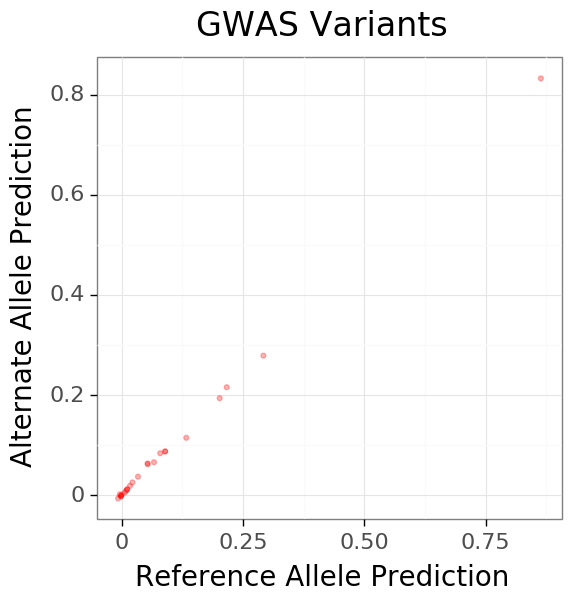

<ggplot: (8728129588060)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
7,chr22,42483761,42483762,rs370511811,A,G,0.827822,chr22,42479513,64,rs11705074,0.863598,0.832397,-0.031201
1,chr22,42479513,42479514,rs11705074,T,G,1.000000,chr22,42479513,64,rs11705074,0.132973,0.114198,-0.018775
14,chr6,111919129,111919130,rs9374302,G,A,0.925594,chr6,111921050,88,rs943437,0.291942,0.278322,-0.013620
5,chr6,111921050,111921051,rs943437,A,G,1.000000,chr6,111921050,88,rs943437,0.201843,0.193432,-0.008411
21,chr6,111937536,111937537,rs10687473,A,AAAAT,0.854650,chr6,111921050,88,rs943437,0.089567,0.086934,-0.002633
20,chr6,111937536,111937537,rs147859592,A,AAAAT,0.854650,chr6,111921050,88,rs943437,0.089567,0.086934,-0.002633
6,chr6,49461705,49461706,rs62411931,G,A,1.000000,chr6,49461705,100,rs62411931,0.006372,0.004944,-0.001428
9,chr22,42485737,42485738,rs1383691167,T,C,0.872864,chr22,42479513,64,rs11705074,-0.001541,-0.002760,-0.001219
22,chr6,111940182,111940183,rs671271,G,A,0.876892,chr6,111921050,88,rs943437,0.066596,0.065383,-0.001212
23,chr6,111940286,111940287,rs481262,T,C,0.847191,chr6,111921050,88,rs943437,0.216367,0.215286,-0.001082


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
12,chr6,111913118,111913119,rs34258931,C,CT,0.926443,chr6,111921050,88,rs943437,0.011175,0.011175,0.000000
18,chr6,111930255,111930256,rs9387055,A,C,0.843445,chr6,111921050,88,rs943437,0.000384,0.000617,0.000232
0,chr6,108936803,108936804,rs183339976,A,G,1.000000,chr6,108936803,56,rs183339976,-0.007384,-0.006919,0.000465
2,chr13,90579739,90579740,rs140851527,A,G,1.000000,chr13,90579739,74,rs140851527,0.016998,0.018156,0.001158
11,chr6,111908723,111908724,rs9481202,A,G,0.881559,chr6,111921050,88,rs943437,0.022188,0.025082,0.002893
4,chr13,111395285,111395286,rs187520595,C,T,1.000000,chr13,111395285,84,rs187520595,0.033550,0.036529,0.002979
19,chr6,111936824,111936825,rs626007,A,G,0.917903,chr6,111921050,88,rs943437,0.079353,0.083336,0.003983
3,chr6,71747595,71747596,rs9446462,C,A,1.000000,chr6,71747595,78,rs9446462,-0.003901,0.001256,0.005157
15,chr6,111922088,111922089,rs997368,A,C,0.852686,chr6,111921050,88,rs943437,0.053504,0.061526,0.008022
16,chr6,111922088,111922089,rs997368,A,G,0.852686,chr6,111921050,88,rs943437,0.053504,0.062972,0.009468


FOLD:  4
All SNPs:


(15, 13)

SNPs NOT in Peaks:


(14, 13)

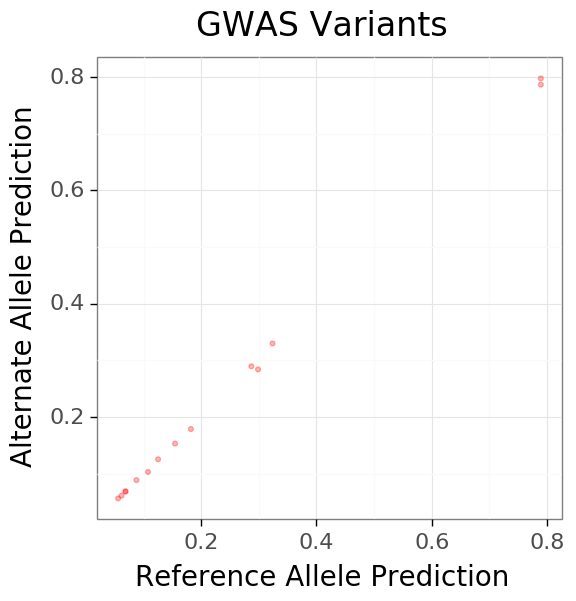

<ggplot: (8728129645516)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
7,chr5,84305922,84305923,rs147108359,G,A,1.000000,chr5,84305922,95,rs147108359,0.298641,0.284093,-0.014549
10,chr16,24693600,24693601,rs572537035,CAAATA,C,0.809640,chr16,24655763,27,rs146398451,0.107780,0.103363,-0.004417
12,chr5,3504257,3504258,rs540581141,C,T,1.000000,chr5,2531144,67,rs149679249,0.182168,0.178994,-0.003174
3,chr5,124774580,124774581,rs6875262,T,C,1.000000,chr5,124774580,34,rs6875262,0.789213,0.786132,-0.003082
8,chr16,58539193,58539194,rs76881424,C,T,0.833167,chr16,58553768,24,rs200564078,0.154736,0.153386,-0.001350
9,chr16,58770912,58770913,rs145178507,C,T,0.833167,chr16,58553768,24,rs200564078,0.061826,0.061426,-0.000399
1,chr16,24655763,24655764,rs776288687,C,CT,1.000000,chr16,24655763,27,rs146398451,0.068725,0.068615,-0.000110
6,chr5,174553576,174553577,rs11743380,C,T,1.000000,chr5,174553576,89,rs11743380,0.125276,0.125662,0.000387
0,chr16,24655763,24655764,rs146398451,C,T,1.000000,chr16,24655763,27,rs146398451,0.068725,0.069221,0.000496
11,chr16,24743404,24743405,rs144948736,C,T,0.833000,chr16,24655763,27,rs146398451,0.055937,0.056714,0.000777


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
8,chr16,58539193,58539194,rs76881424,C,T,0.833167,chr16,58553768,24,rs200564078,0.154736,0.153386,-0.001350
9,chr16,58770912,58770913,rs145178507,C,T,0.833167,chr16,58553768,24,rs200564078,0.061826,0.061426,-0.000399
1,chr16,24655763,24655764,rs776288687,C,CT,1.000000,chr16,24655763,27,rs146398451,0.068725,0.068615,-0.000110
6,chr5,174553576,174553577,rs11743380,C,T,1.000000,chr5,174553576,89,rs11743380,0.125276,0.125662,0.000387
0,chr16,24655763,24655764,rs146398451,C,T,1.000000,chr16,24655763,27,rs146398451,0.068725,0.069221,0.000496
11,chr16,24743404,24743405,rs144948736,C,T,0.833000,chr16,24655763,27,rs146398451,0.055937,0.056714,0.000777
4,chr5,60839026,60839027,rs201395352,A,AT,1.000000,chr5,60839026,54,.,0.087722,0.088963,0.001240
13,chr5,174529858,174529859,rs11742484,A,T,0.870984,chr5,174553576,89,rs11743380,0.287018,0.289619,0.002601
5,chr5,2531144,2531145,rs149679249,T,C,1.000000,chr5,2531144,67,rs149679249,0.323739,0.329827,0.006088
2,chr5,124774580,124774581,rs6875262,T,A,1.000000,chr5,124774580,34,rs6875262,0.789213,0.797226,0.008012


FOLD:  5
All SNPs:


(46, 13)

SNPs in Peaks:


(1, 13)

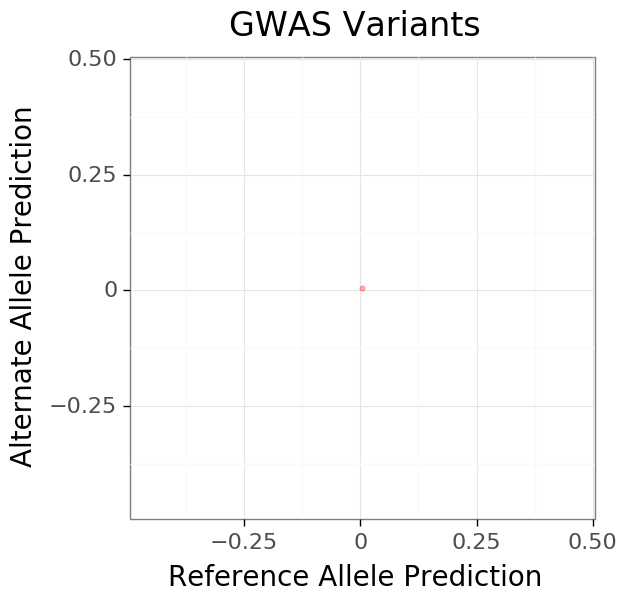

<ggplot: (8728129506224)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr4,90290373,90290374,rs75541595,G,A,1.0,chr4,90290373,20,rs75541595,0.00453,0.004505,-0.000025


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr4,90290373,90290374,rs75541595,G,A,1.0,chr4,90290373,20,rs75541595,0.00453,0.004505,-0.000025


SNPs NOT in Peaks:


(43, 13)

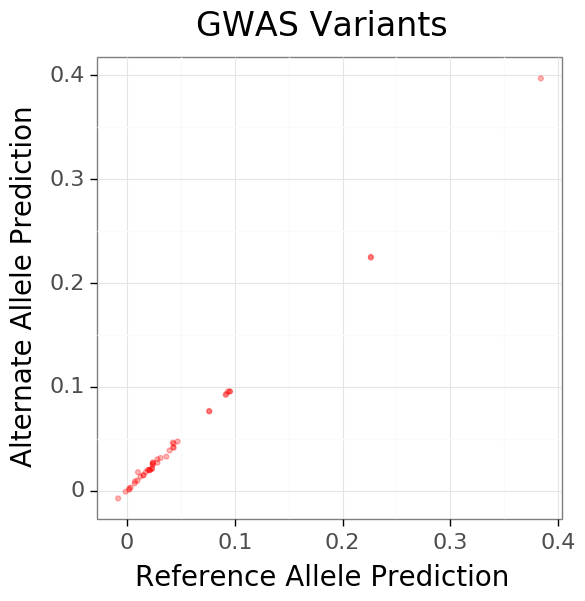

<ggplot: (8728129550449)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
15,chr4,182221693,182221694,rs896026,C,T,0.992371,chr4,182220835,25,rs2044779,0.036470,0.032771,-0.003699
41,chr4,178971133,178971134,rs74855614,A,T,0.966952,chr4,178957718,70,rs76856961,0.226279,0.224120,-0.002159
0,chr4,76255744,76255745,rs12651582,C,T,1.000000,chr4,76255744,22,rs12651582,0.023124,0.021145,-0.001978
10,chr4,113891618,113891619,rs140020117,G,A,1.000000,chr4,113891618,80,rs140020117,0.043341,0.041363,-0.001978
30,chr4,178959599,178959600,rs113785126,C,T,1.000000,chr4,178957718,70,rs76856961,0.023236,0.021279,-0.001957
39,chr4,178968614,178968615,rs78326713,T,C,0.940563,chr4,178957718,70,rs76856961,0.021558,0.019849,-0.001709
20,chr21,44413639,44413640,rs142333555,C,T,0.966473,chr21,44406603,28,rs56379273,0.028226,0.026922,-0.001304
35,chr4,178965253,178965254,rs78246185,G,A,0.986811,chr4,178957718,70,rs76856961,0.021057,0.019865,-0.001193
31,chr4,178961601,178961602,rs1193967964,C,T,0.986811,chr4,178957718,70,rs76856961,0.002116,0.000938,-0.001178
40,chr4,178971133,178971134,rs74855614,A,G,0.966952,chr4,178957718,70,rs76856961,0.226279,0.225104,-0.001175


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
21,chr4,102276925,102276926,rs13135092,A,G,0.942649,chr4,102267552,31,rs13107325,0.007514,0.009141,0.001627
29,chr4,178959592,178959593,rs111985289,C,T,0.993426,chr4,178957718,70,rs76856961,0.023871,0.025526,0.001655
37,chr4,178965762,178965763,rs113530632,T,A,0.986811,chr4,178957718,70,rs76856961,0.093677,0.095467,0.001790
11,chr4,113891618,113891619,rs140020117,G,C,1.000000,chr4,113891618,80,rs140020117,0.043341,0.045328,0.001987
18,chr4,182221961,182221962,rs896024,A,G,0.982898,chr4,182220835,25,rs2044779,0.028213,0.030227,0.002014
17,chr4,182221774,182221775,rs896025,C,T,0.994275,chr4,182220835,25,rs2044779,0.023969,0.026968,0.002999
16,chr4,182221774,182221775,rs896025,C,G,0.994275,chr4,182220835,25,rs2044779,0.023969,0.027032,0.003063
34,chr4,178963851,178963852,rs80116969,T,C,0.933991,chr4,178957718,70,rs76856961,0.042447,0.046326,0.003879
13,chr4,90229014,90229015,rs142404622,T,C,0.939527,chr4,90290373,20,rs75541595,0.010161,0.017846,0.007685
1,chr4,182220835,182220836,rs2044779,T,A,1.000000,chr4,182220835,25,rs2044779,0.383998,0.396641,0.012643


FOLD:  6
All SNPs:


(125, 13)

SNPs in Peaks:


(6, 13)

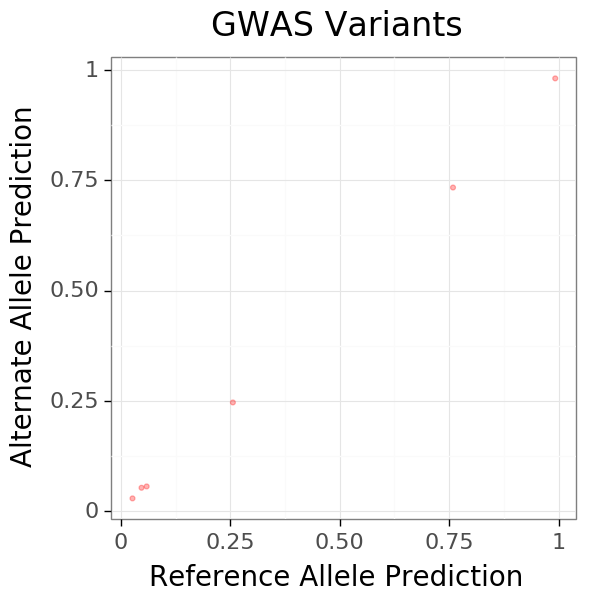

<ggplot: (8728984508911)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr14,54901909,54901910,rs2149482,C,T,0.957318,chr14,54898613,26,rs8019824,0.758813,0.733531,-0.025282
2,chr7,23105676,23105677,rs10256996,T,G,0.870899,chr7,23104563,30,rs10488077,0.992389,0.980943,-0.011446
1,chr7,23105295,23105296,rs10241208,G,C,0.954185,chr7,23104563,30,rs10488077,0.255794,0.246374,-0.009419
3,chr7,23114694,23114695,rs2068459,A,C,0.892711,chr7,23104563,30,rs10488077,0.058737,0.056013,-0.002724
4,chr7,23115906,23115907,rs73272053,A,G,0.866225,chr7,23104563,30,rs10488077,0.026390,0.028899,0.002509
5,chr18,43093415,43093416,rs12456492,A,G,0.813684,chr18,43098270,61,rs4130047,0.047001,0.052963,0.005962


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr14,54901909,54901910,rs2149482,C,T,0.957318,chr14,54898613,26,rs8019824,0.758813,0.733531,-0.025282
2,chr7,23105676,23105677,rs10256996,T,G,0.870899,chr7,23104563,30,rs10488077,0.992389,0.980943,-0.011446
1,chr7,23105295,23105296,rs10241208,G,C,0.954185,chr7,23104563,30,rs10488077,0.255794,0.246374,-0.009419
3,chr7,23114694,23114695,rs2068459,A,C,0.892711,chr7,23104563,30,rs10488077,0.058737,0.056013,-0.002724
4,chr7,23115906,23115907,rs73272053,A,G,0.866225,chr7,23104563,30,rs10488077,0.026390,0.028899,0.002509
5,chr18,43093415,43093416,rs12456492,A,G,0.813684,chr18,43098270,61,rs4130047,0.047001,0.052963,0.005962


SNPs NOT in Peaks:


(117, 13)

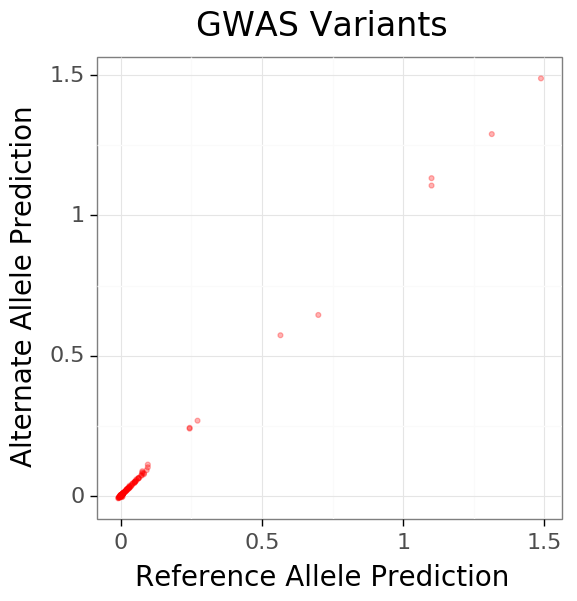

<ggplot: (-9223363308725314444)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
91,chr7,23136327,23136328,rs6953996,A,G,0.896863,chr7,23104563,30,rs10488077,0.699686,0.645126,-0.054560
12,chr14,54903567,54903568,rs10136972,A,G,0.948553,chr14,54898613,26,rs8019824,1.313958,1.290292,-0.023666
54,chr14,54995292,54995293,rs10150110,G,C,0.830936,chr14,54898613,26,rs8019824,0.005813,-0.003726,-0.009539
55,chr14,54995292,54995293,rs10150110,G,T,0.830936,chr14,54898613,26,rs8019824,0.005813,-0.002535,-0.008348
30,chr14,54949104,54949105,rs8004402,C,G,0.877826,chr14,54898613,26,rs8019824,0.001242,-0.005267,-0.006509
40,chr14,54961923,54961924,rs3783643,A,C,0.859338,chr14,54898613,26,rs8019824,0.082308,0.077180,-0.005128
39,chr14,54960385,54960386,rs6572994,C,G,0.854750,chr14,54898613,26,rs8019824,0.243985,0.239759,-0.004225
107,chr7,64293093,64293094,rs35919389,C,T,0.912771,chr7,64306602,85,rs10499772,0.272001,0.268059,-0.003942
44,chr14,54973039,54973040,rs1253567737,T,TTA,0.830350,chr14,54898613,26,rs8019824,0.002573,-0.000230,-0.002803
49,chr14,54978028,54978029,rs7157085,G,A,0.827469,chr14,54898613,26,rs8019824,0.031040,0.028278,-0.002762


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
32,chr14,54950498,54950499,rs6572992,C,A,0.875659,chr14,54898613,26,rs8019824,-0.000979,0.002265,0.003244
100,chr7,23151805,23151806,rs2141307,G,C,0.808732,chr7,23104563,30,rs10488077,0.055274,0.058529,0.003254
103,chr14,103459924,103459925,rs117105921,G,T,0.889983,chr14,103544952,62,rs151247738,0.031440,0.036147,0.004707
65,chr14,55005265,55005266,rs2840268,C,T,0.802271,chr14,54898613,26,rs8019824,0.095975,0.101710,0.005735
14,chr14,54903622,54903623,rs10137071,C,T,0.948553,chr14,54898613,26,rs8019824,1.100629,1.106675,0.006047
87,chr7,23114316,23114317,rs764534,C,T,0.888467,chr7,23104563,30,rs10488077,0.076399,0.083382,0.006983
66,chr14,55005673,55005674,rs2183085,A,C,0.802271,chr14,54898613,26,rs8019824,0.565543,0.572817,0.007274
86,chr7,23114316,23114317,rs764534,C,G,0.888467,chr7,23104563,30,rs10488077,0.076399,0.087755,0.011356
64,chr14,55005265,55005266,rs2840268,C,G,0.802271,chr14,54898613,26,rs8019824,0.095975,0.111492,0.015517
13,chr14,54903622,54903623,rs10137071,C,G,0.948553,chr14,54898613,26,rs8019824,1.100629,1.133075,0.032447


FOLD:  7
All SNPs:


(5154, 13)

SNPs in Peaks:


(352, 13)

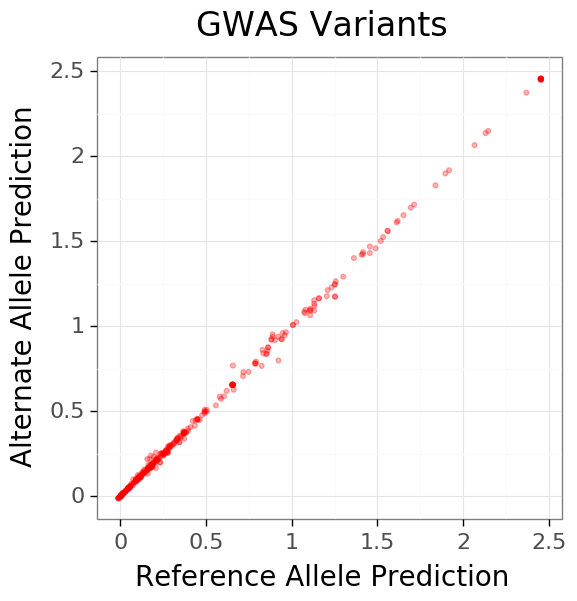

<ggplot: (8728984508911)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
337,chr17,46267724,46267725,rs2668719,C,A,0.820234,chr17,46105479,3,.,0.922956,0.799017,-0.123939
332,chr17,46267622,46267623,rs2732650,C,G,0.955019,chr17,46105479,3,.,1.253191,1.173604,-0.079587
333,chr17,46267622,46267623,rs2732650,C,T,0.955019,chr17,46105479,3,.,1.253191,1.174723,-0.078468
115,chr17,45867740,45867741,rs62055475,T,C,0.992408,chr17,46105479,3,.,0.825193,0.766656,-0.058537
27,chr17,45688986,45688987,rs17688205,G,A,0.984858,chr17,46105479,3,.,1.107679,1.065351,-0.042328
59,chr17,45722444,45722445,rs76667867,G,A,0.955856,chr17,46105479,3,.,0.208334,0.166636,-0.041699
130,chr17,45896042,45896043,rs113347741,C,T,0.992408,chr17,46105479,3,.,1.131165,1.091692,-0.039472
218,chr17,46119081,46119082,rs1468240,T,C,0.989877,chr17,46105479,3,.,0.373794,0.338641,-0.035154
338,chr17,46267748,46267749,rs2732652,C,T,0.820234,chr17,46105479,3,.,0.661283,0.626722,-0.034561
229,chr17,46122304,46122305,rs62061855,G,A,0.800577,chr17,46704858,6,.,0.232336,0.199284,-0.033052


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
181,chr17,46004161,46004162,rs62064665,T,C,0.994936,chr17,46105479,3,.,0.194797,0.232809,0.038012
334,chr17,46267681,46267682,rs138875687,A,ACT,0.952398,chr17,46105479,3,.,0.881918,0.922188,0.040269
335,chr17,46267681,46267682,rs74597047,A,ACT,0.952398,chr17,46105479,3,.,0.881918,0.922188,0.040269
56,chr17,45719880,45719881,rs56046792,C,T,0.984820,chr17,46105479,3,.,0.171593,0.220062,0.048469
133,chr17,45896286,45896287,rs62056780,C,T,0.992408,chr17,46105479,3,.,0.889034,0.938016,0.048981
60,chr17,45722444,45722445,rs76667867,G,C,0.955856,chr17,46105479,3,.,0.208334,0.257934,0.049600
234,chr17,46130778,46130779,rs17661428,C,G,0.987347,chr17,46105479,3,.,0.178671,0.239764,0.061093
201,chr17,46044551,46044552,rs77768866,C,T,0.997473,chr17,46105479,3,.,0.157499,0.219270,0.061771
132,chr17,45896286,45896287,rs62056780,C,G,0.992408,chr17,46105479,3,.,0.889034,0.952278,0.063243
120,chr17,45894419,45894420,rs11575895,A,G,0.992408,chr17,46105479,3,.,0.657250,0.768721,0.111470


SNPs NOT in Peaks:


(4800, 13)

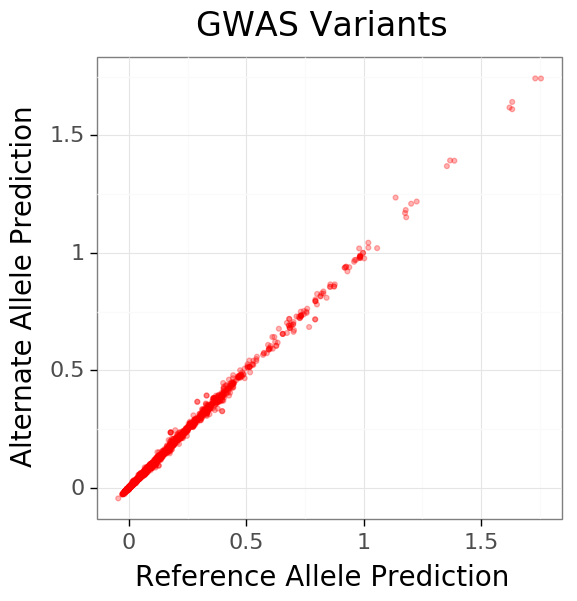

<ggplot: (-9223363308725317937)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
766,chr17,45733242,45733243,rs62054394,T,A,0.887600,chr17,46105479,3,.,0.767847,0.684860,-0.082987
1423,chr17,45874233,45874234,rs67687156,CAGAT,C,0.992408,chr17,46105479,3,.,0.793643,0.717453,-0.076189
1422,chr17,45874233,45874234,rs67344622,CAGAT,C,0.992408,chr17,46105479,3,.,0.793643,0.717453,-0.076189
1941,chr17,45947196,45947197,rs62062785,G,T,0.803317,chr17,46704858,6,.,0.397430,0.326880,-0.070550
1939,chr17,45947196,45947197,rs62062785,G,T,0.997467,chr17,46105479,3,.,0.397430,0.326880,-0.070550
2265,chr17,45987393,45987394,rs1271709991,A,AGGACAGTAAATGAAGGTGTGTTTGAAAACCAAC,0.982549,chr17,46105479,3,.,0.378209,0.337609,-0.040600
863,chr17,45751987,45751988,rs62054442,A,G,0.871402,chr17,46105479,3,.,1.057554,1.020478,-0.037076
428,chr17,45680084,45680085,rs55974014,C,A,0.954565,chr17,46105479,3,.,0.701371,0.664304,-0.037067
3908,chr17,46174216,46174217,rs62060916,T,C,0.994957,chr17,46105479,3,.,0.366028,0.331210,-0.034819
4016,chr17,46187577,46187578,rs2696708,T,C,0.994957,chr17,46105479,3,.,0.426653,0.393104,-0.033549


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
771,chr17,45733507,45733508,rs75022332,A,T,0.887600,chr17,46105479,3,.,0.197597,0.245813,0.048216
3102,chr17,46078766,46078767,rs75081565,T,TTTA,0.801265,chr17,46704858,6,.,0.178052,0.236188,0.058137
3098,chr17,46078766,46078767,rs111750615,T,TTTA,1.000000,chr17,46105479,3,.,0.178052,0.236188,0.058137
3099,chr17,46078766,46078767,rs75081565,T,TTTA,1.000000,chr17,46105479,3,.,0.178052,0.236188,0.058137
3101,chr17,46078766,46078767,rs111750615,T,TTTA,0.801265,chr17,46704858,6,.,0.178052,0.236188,0.058137
2486,chr17,46017301,46017302,rs2316948,C,G,1.000000,chr17,46105479,3,.,0.331072,0.393265,0.062193
2487,chr17,46017301,46017302,rs2316948,C,G,0.801265,chr17,46704858,6,.,0.331072,0.393265,0.062193
1936,chr17,45947186,45947187,rs62062784,C,G,0.997467,chr17,46105479,3,.,0.291496,0.366736,0.075239
1937,chr17,45947186,45947187,rs62062784,C,G,0.803317,chr17,46704858,6,.,0.291496,0.366736,0.075239
1593,chr17,45897523,45897524,rs62056784,C,G,0.992408,chr17,46105479,3,.,1.136244,1.235697,0.099453


FOLD:  8
All SNPs:


(44, 13)

SNPs in Peaks:


(4, 13)

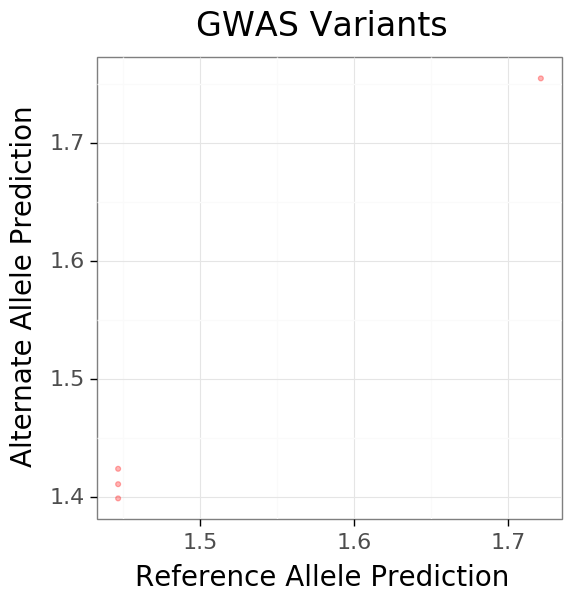

<ggplot: (-9223363308725379198)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr12,122842051,122842052,rs10847864,G,C,0.815339,chr12,122838013,10,rs10847839,1.446705,1.399234,-0.047470
3,chr12,122842051,122842052,rs10847864,G,T,0.815339,chr12,122838013,10,rs10847839,1.446705,1.411267,-0.035438
1,chr12,122842051,122842052,rs10847864,G,A,0.815339,chr12,122838013,10,rs10847839,1.446705,1.424306,-0.022399
0,chr9,17579692,17579693,rs13294100,T,G,1.000000,chr9,17579692,39,rs13294100,1.721362,1.755035,0.033672


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr12,122842051,122842052,rs10847864,G,C,0.815339,chr12,122838013,10,rs10847839,1.446705,1.399234,-0.047470
3,chr12,122842051,122842052,rs10847864,G,T,0.815339,chr12,122838013,10,rs10847839,1.446705,1.411267,-0.035438
1,chr12,122842051,122842052,rs10847864,G,A,0.815339,chr12,122838013,10,rs10847839,1.446705,1.424306,-0.022399
0,chr9,17579692,17579693,rs13294100,T,G,1.000000,chr9,17579692,39,rs13294100,1.721362,1.755035,0.033672


SNPs NOT in Peaks:


(38, 13)

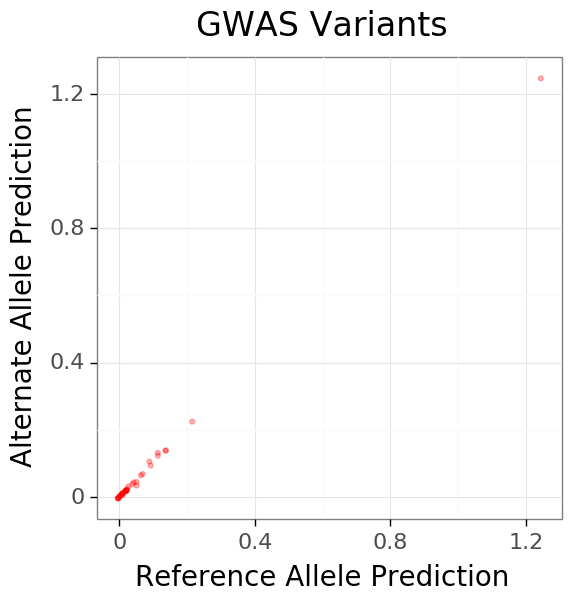

<ggplot: (8728129550456)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
36,chr9,114810887,114810888,rs55914236,C,T,0.816031,chr9,114806968,96,rs55892528,0.050295,0.033563,-0.016732
35,chr9,114810887,114810888,rs55914236,C,A,0.816031,chr9,114806968,96,rs55892528,0.050295,0.044274,-0.006020
22,chr12,34487679,34487680,rs189930135,C,T,1.000000,chr12,34487072,8,rs180751015,0.009626,0.005132,-0.004494
32,chr12,38022088,38022089,rs564412193,G,A,0.888711,chr12,37566521,18,rs149617467,0.019824,0.017224,-0.002601
10,chr12,32389884,32389885,rs148707891,G,C,1.000000,chr12,32389884,33,rs148707891,0.019630,0.017796,-0.001833
24,chr12,33024607,33024608,rs140105005,C,T,0.933146,chr12,33075690,16,rs138895122,0.020823,0.019099,-0.001724
19,chr12,40158476,40158477,rs187827177,C,A,1.000000,chr12,40340400,1,rs34637584,0.017559,0.016352,-0.001207
1,chr12,34487072,34487073,rs180751015,C,A,1.000000,chr12,34487072,8,rs180751015,-0.003529,-0.004611,-0.001082
34,chr12,32358558,32358559,rs185414076,G,A,0.882000,chr12,32389884,33,rs148707891,0.020787,0.019809,-0.000977
3,chr12,33075690,33075691,rs138895122,C,T,1.000000,chr12,33075690,16,rs138895122,-0.002071,-0.002782,-0.000711


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
26,chr12,33065585,33065586,rs117467542,A,G,1.000000,chr12,33075690,16,rs138895122,0.007006,0.008335,0.001329
15,chr12,38225761,38225762,rs192829408,G,A,1.000000,chr12,38225761,59,rs192829408,0.009069,0.010684,0.001615
5,chr12,37566521,37566522,rs149617467,C,T,1.000000,chr12,37566521,18,rs149617467,1.244775,1.246444,0.001669
9,chr12,42141601,42141602,rs144755950,T,C,1.000000,chr12,42141601,23,rs144755950,0.135694,0.137740,0.002046
27,chr12,37733890,37733891,rs191016984,C,G,0.888711,chr12,37566521,18,rs149617467,0.001291,0.003355,0.002064
30,chr12,37999497,37999498,rs184239956,A,G,0.888711,chr12,37566521,18,rs149617467,0.027046,0.031209,0.004163
31,chr12,38008145,38008146,rs74772260,C,T,0.888711,chr12,37566521,18,rs149617467,0.214845,0.224097,0.009252
14,chr9,138121810,138121811,rs2278973,T,G,1.000000,chr9,138121810,48,rs2278973,0.113359,0.122709,0.009350
2,chr12,122838013,122838014,rs10847839,T,C,1.000000,chr12,122838013,10,rs10847839,0.088410,0.104865,0.016455
13,chr9,138121810,138121811,rs2278973,T,A,1.000000,chr9,138121810,48,rs2278973,0.113359,0.131072,0.017713


FOLD:  9
All SNPs:


(14, 13)

SNPs in Peaks:


(1, 13)

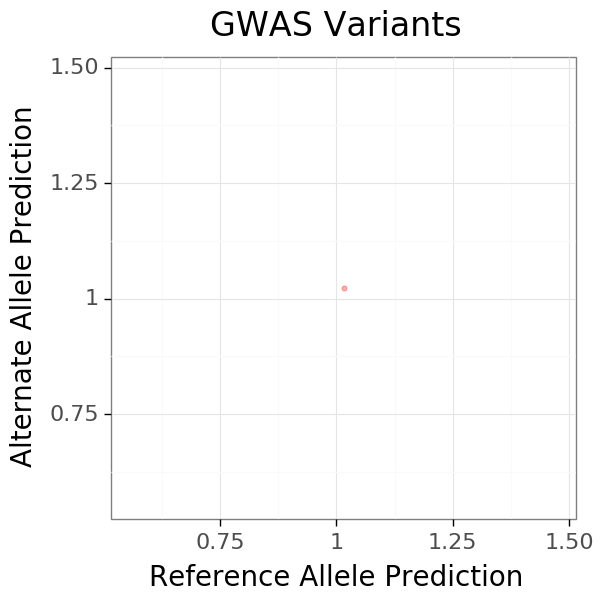

<ggplot: (-9223363308725442865)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr10,119651405,119651406,rs144814361,C,T,1.0,chr10,119651405,15,rs144814361,1.015673,1.022212,0.00654


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr10,119651405,119651406,rs144814361,C,T,1.0,chr10,119651405,15,rs144814361,1.015673,1.022212,0.00654


SNPs NOT in Peaks:


(11, 13)

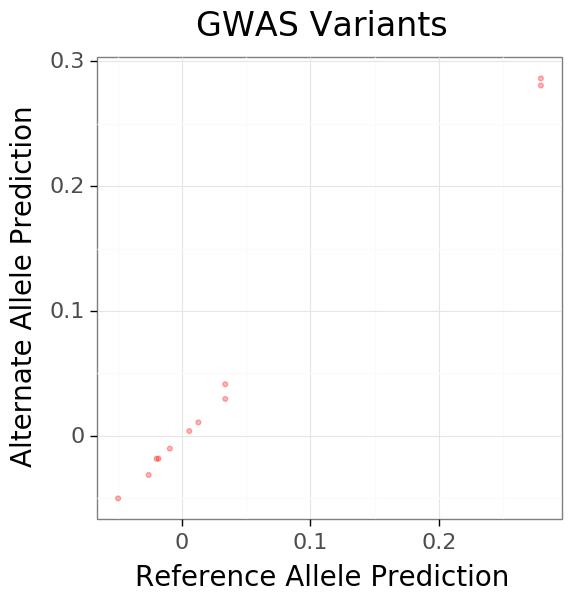

<ggplot: (8728129342044)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
4,chr8,20030802,20030803,rs73208821,G,C,1.000000,chr8,20030802,55,rs73208821,-0.026001,-0.031243,-0.005242
2,chr8,34227886,34227887,rs201891502,C,CT,1.000000,chr8,34227886,51,rs1446651337,0.033645,0.029651,-0.003995
5,chr8,11854934,11854935,rs1293298,A,C,1.000000,chr8,11854934,75,rs1293298,0.012699,0.010863,-0.001836
7,chr10,76731020,76731021,rs74860646,T,G,1.000000,chr10,76731020,81,rs74860646,0.005627,0.003902,-0.001725
8,chr8,36255602,36255603,rs76104776,A,C,1.000000,chr8,36255602,101,rs76104776,-0.009507,-0.010161,-0.000654
9,chr8,20026413,20026414,rs73208819,T,C,0.833398,chr8,20030802,55,rs73208821,-0.049799,-0.049999,-0.000200
6,chr8,109740385,109740386,rs72669174,T,A,1.000000,chr8,109740385,79,rs72669174,-0.018281,-0.018225,0.000056
1,chr10,2172585,2172586,rs75482696,T,C,1.000000,chr10,2172585,43,rs75482696,0.279446,0.280591,0.001146
10,chr10,76742310,76742311,rs17231856,A,C,0.843823,chr10,76731020,81,rs74860646,-0.019860,-0.018249,0.001611
0,chr10,2172585,2172586,rs75482696,T,A,1.000000,chr10,2172585,43,rs75482696,0.279446,0.286277,0.006832


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr8,34227886,34227887,rs201891502,C,CT,1.000000,chr8,34227886,51,rs1446651337,0.033645,0.029651,-0.003995
5,chr8,11854934,11854935,rs1293298,A,C,1.000000,chr8,11854934,75,rs1293298,0.012699,0.010863,-0.001836
7,chr10,76731020,76731021,rs74860646,T,G,1.000000,chr10,76731020,81,rs74860646,0.005627,0.003902,-0.001725
8,chr8,36255602,36255603,rs76104776,A,C,1.000000,chr8,36255602,101,rs76104776,-0.009507,-0.010161,-0.000654
9,chr8,20026413,20026414,rs73208819,T,C,0.833398,chr8,20030802,55,rs73208821,-0.049799,-0.049999,-0.000200
6,chr8,109740385,109740386,rs72669174,T,A,1.000000,chr8,109740385,79,rs72669174,-0.018281,-0.018225,0.000056
1,chr10,2172585,2172586,rs75482696,T,C,1.000000,chr10,2172585,43,rs75482696,0.279446,0.280591,0.001146
10,chr10,76742310,76742311,rs17231856,A,C,0.843823,chr10,76731020,81,rs74860646,-0.019860,-0.018249,0.001611
0,chr10,2172585,2172586,rs75482696,T,A,1.000000,chr10,2172585,43,rs75482696,0.279446,0.286277,0.006832
3,chr8,34227886,34227887,rs1446651337,C,G,1.000000,chr8,34227886,51,rs1446651337,0.033645,0.041384,0.007738


In [8]:
get_results_all_folds('PD_CTRL_MDTG')

TASK:  PD_GBA1_MDTG
FOLD:  0
All SNPs:


(35, 13)

SNPs in Peaks:


(3, 13)

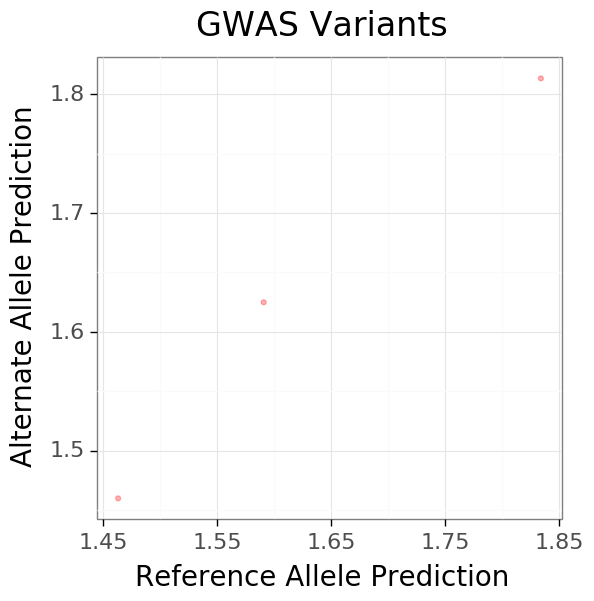

<ggplot: (8728129176766)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr1,155135691,155135692,rs12726330,G,C,1.000000,chr1,155135691,9,rs12726330,1.833830,1.813499,-0.020331
1,chr1,205750404,205750405,rs823114,G,A,0.953762,chr1,205770138,21,rs708723,1.462934,1.459671,-0.003263
2,chr1,8409729,8409730,rs2661868,C,T,0.984181,chr1,8390388,77,rs2708628,1.590664,1.624879,0.034214


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr1,155135691,155135692,rs12726330,G,C,1.000000,chr1,155135691,9,rs12726330,1.833830,1.813499,-0.020331
1,chr1,205750404,205750405,rs823114,G,A,0.953762,chr1,205770138,21,rs708723,1.462934,1.459671,-0.003263
2,chr1,8409729,8409730,rs2661868,C,T,0.984181,chr1,8390388,77,rs2708628,1.590664,1.624879,0.034214


SNPs NOT in Peaks:


(30, 13)

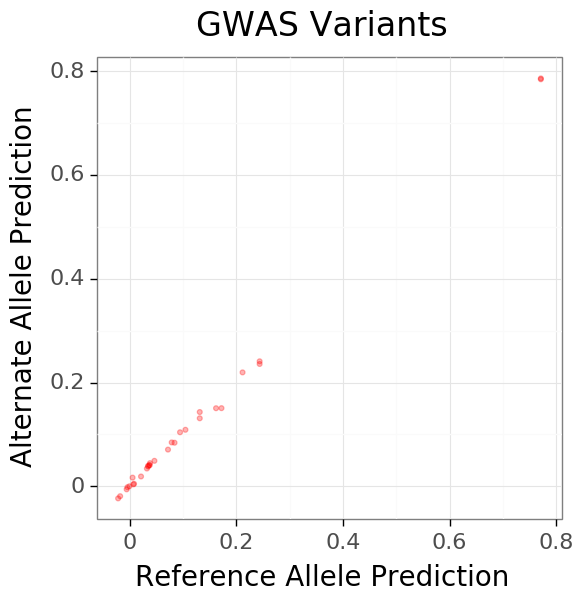

<ggplot: (8728129301957)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
14,chr1,155235587,155235588,rs12752133,C,T,0.812944,chr1,155135691,9,rs12726330,0.172268,0.150629,-0.021639
2,chr1,183922245,183922246,rs113076859,C,T,1.000000,chr1,183922245,50,rs113076859,0.162079,0.150506,-0.011573
21,chr1,8380583,8380584,rs2636314,G,A,0.975367,chr1,8390388,77,rs2708628,0.243790,0.235641,-0.008150
17,chr1,205751355,205751356,rs823116,G,A,0.959419,chr1,205770138,21,rs708723,0.008346,0.005016,-0.003330
29,chr1,8440997,8440998,rs2784740,T,A,0.915383,chr1,8390388,77,rs2708628,0.007133,0.003950,-0.003183
22,chr1,8380583,8380584,rs2636314,G,C,0.975367,chr1,8390388,77,rs2708628,0.243790,0.240818,-0.002972
20,chr1,119089761,119089762,rs72707308,C,T,1.000000,chr1,119094055,53,rs76695140,0.021434,0.019092,-0.002342
26,chr1,8406690,8406691,rs2748456,C,T,0.988415,chr1,8390388,77,rs2708628,-0.021490,-0.023077,-0.001587
23,chr1,8403450,8403451,rs2708631,C,T,0.986964,chr1,8390388,77,rs2708628,-0.017692,-0.018848,-0.001156
5,chr1,10405391,10405392,rs199959132,AAAC,A,1.000000,chr1,10405391,72,.,0.072006,0.070860,-0.001146


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr1,155850943,155850944,rs34032320,G,C,1.000000,chr1,155850943,12,rs34032320,0.104705,0.108979,0.004274
10,chr1,155015779,155015780,rs71628639,C,T,0.885591,chr1,155135691,9,rs12726330,0.034776,0.039732,0.004956
11,chr1,155143675,155143676,rs12742181,C,T,1.000000,chr1,155135691,9,rs12726330,0.078940,0.084653,0.005713
6,chr1,8390388,8390389,rs2708628,T,C,1.000000,chr1,8390388,77,rs2708628,0.038237,0.044756,0.006518
4,chr1,18814620,18814621,rs191668177,C,G,1.000000,chr1,18814620,60,rs191668177,0.211786,0.219481,0.007695
3,chr1,119094055,119094056,rs76695140,A,G,1.000000,chr1,119094055,53,rs76695140,0.094580,0.104213,0.009633
16,chr1,155924191,155924192,rs547368930,CCTATAGTCCCAGCTA,C,0.828027,chr1,155850943,12,rs34032320,0.005610,0.016889,0.011279
18,chr1,205754444,205754445,rs823118,C,A,0.972244,chr1,205770138,21,rs708723,0.131537,0.143159,0.011622
8,chr1,246782994,246782995,rs149745071,C,T,1.000000,chr1,246782994,93,rs149745071,0.770956,0.783661,0.012704
7,chr1,246782994,246782995,rs149745071,C,A,1.000000,chr1,246782994,93,rs149745071,0.770956,0.785393,0.014436


FOLD:  1
All SNPs:


(58, 13)

SNPs NOT in Peaks:


(57, 13)

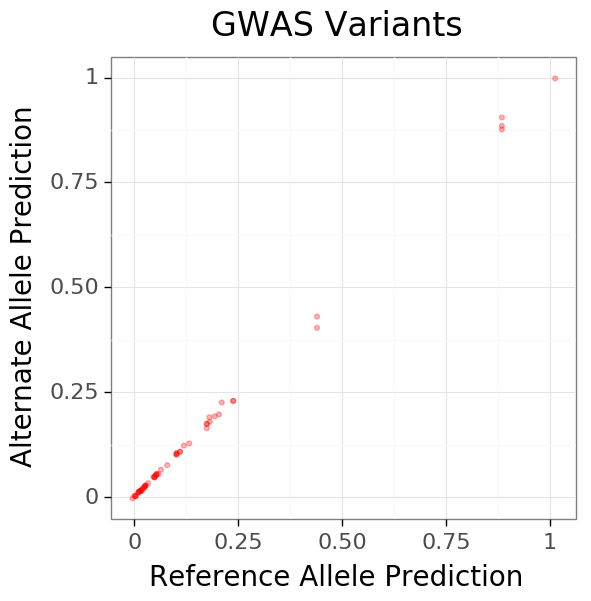

<ggplot: (-9223363308725668927)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
31,chr2,134782976,134782977,rs7599054,A,T,0.976667,chr2,134825938,37,rs6760237,0.439914,0.403656,-0.036258
45,chr19,2813805,2813806,rs73524732,G,A,0.879171,chr19,2791655,47,rs59303624,1.013145,0.998051,-0.015094
40,chr2,62495666,62495667,rs539968640,C,T,0.973916,chr2,62495157,45,rs10211381,0.174747,0.164730,-0.010018
30,chr2,134782976,134782977,rs7599054,A,G,0.976667,chr2,134825938,37,rs6760237,0.439914,0.430458,-0.009456
6,chr19,2791655,2791656,rs59303624,G,T,1.000000,chr19,2791655,47,rs59303624,0.238256,0.229140,-0.009116
5,chr19,2791655,2791656,rs59303624,G,A,1.000000,chr19,2791655,47,rs59303624,0.238256,0.229735,-0.008521
46,chr19,2813855,2813856,rs1478922243,C,T,0.879171,chr19,2791655,47,rs59303624,0.884817,0.876410,-0.008408
10,chr2,46410382,46410383,rs150828230,G,A,1.000000,chr2,46410382,90,rs150828230,0.204035,0.197343,-0.006692
43,chr19,2788500,2788501,rs112713793,C,T,0.980779,chr19,2791655,47,rs59303624,0.132414,0.128250,-0.004164
56,chr2,220851718,220851719,rs60680882,C,T,0.853503,chr2,220851226,99,rs73993676,0.058526,0.055027,-0.003499


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
3,chr2,134825938,134825939,rs6760237,A,T,1.000000,chr2,134825938,37,rs6760237,0.010254,0.011791,0.001537
44,chr19,2790688,2790689,rs8106185,C,T,0.955223,chr19,2791655,47,rs59303624,0.102321,0.103881,0.001561
39,chr2,134834675,134834676,rs6758044,T,C,0.984461,chr2,134825938,37,rs6760237,0.053815,0.055712,0.001897
16,chr2,168299715,168299716,rs4667573,C,T,0.812264,chr2,168299085,13,rs13016703,0.001153,0.003302,0.002149
2,chr2,134825938,134825939,rs6760237,A,G,1.000000,chr2,134825938,37,rs6760237,0.010254,0.012615,0.002361
7,chr2,126517671,126517672,rs77643088,G,C,1.000000,chr2,126517671,63,rs77643088,0.119585,0.123052,0.003467
23,chr2,101989388,101989389,rs201052897,A,T,0.919644,chr2,101988187,29,rs12467316,0.101625,0.105280,0.003655
9,chr2,153110678,153110679,rs1347394,T,C,1.000000,chr2,153110678,82,rs1347394,0.180892,0.190407,0.009515
49,chr19,2813959,2813960,rs113301220,A,G,0.873043,chr19,2791655,47,rs59303624,0.210694,0.225735,0.015041
47,chr19,2813855,2813856,rs146390273,C,CCT,0.879171,chr19,2791655,47,rs59303624,0.884817,0.904973,0.020156


FOLD:  2
All SNPs:


(70, 13)

SNPs in Peaks:


(0, 13)

AttributeError: 'list' object has no attribute 'keys'

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta


SNPs NOT in Peaks:


(68, 13)

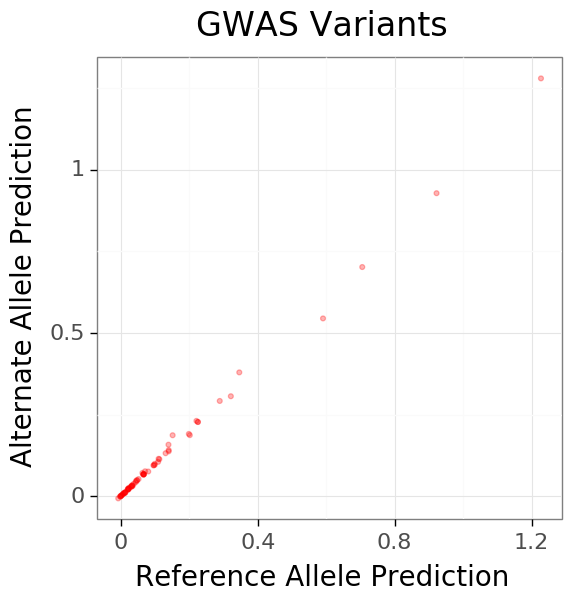

<ggplot: (8728129114081)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr3,183010401,183010402,rs5854965,CTAGG,C,1.000000,chr3,183010401,14,.,0.590686,0.544316,-0.046371
53,chr3,18227051,18227052,rs73034316,G,A,0.856038,chr3,18181950,87,rs13078687,0.321437,0.305990,-0.015447
1,chr3,145333493,145333494,rs181870458,G,A,1.000000,chr3,145333493,35,rs181870458,0.201564,0.186853,-0.014711
15,chr3,146345697,146345698,rs116468365,G,A,0.947179,chr3,146323490,38,rs192689438,0.198760,0.190581,-0.008179
22,chr3,18163667,18163668,rs35115317,G,A,0.996583,chr3,18181950,87,rs13078687,0.080122,0.075445,-0.004678
10,chr3,183007683,183007684,rs11718171,A,G,0.865485,chr3,183010401,14,.,0.108986,0.105056,-0.003931
61,chr3,18239954,18239955,rs67878364,T,C,0.835022,chr3,18181950,87,rs13078687,0.033995,0.030247,-0.003748
41,chr3,18189881,18189882,rs35407649,C,A,0.941916,chr3,18181950,87,rs13078687,0.705311,0.701659,-0.003652
31,chr3,18175216,18175217,rs1022089937,C,T,1.000000,chr3,18181950,87,rs13078687,0.098974,0.095683,-0.003290
51,chr3,18217730,18217731,rs13071572,G,A,0.913115,chr3,18181950,87,rs13078687,0.139909,0.137285,-0.002624


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
6,chr3,18181950,18181951,rs13078687,G,A,1.000000,chr3,18181950,87,rs13078687,0.289028,0.291540,0.002512
35,chr3,18176181,18176182,rs35051749,T,C,1.000000,chr3,18181950,87,rs13078687,0.110372,0.114412,0.004039
7,chr3,18704008,18704009,rs13095117,A,G,1.000000,chr3,18704008,94,rs13095117,0.070939,0.076146,0.005207
11,chr3,183010393,183010394,rs4074310,T,G,1.000000,chr3,183010401,14,.,0.922325,0.927805,0.005480
14,chr3,4544215,4544216,rs304007,G,T,0.806552,chr3,4540543,36,rs304048,0.063075,0.071183,0.008108
33,chr3,18175539,18175540,rs67392505,G,C,1.000000,chr3,18181950,87,rs13078687,0.220918,0.230546,0.009628
65,chr3,18240967,18240968,rs35274326,C,G,0.835022,chr3,18181950,87,rs13078687,0.139247,0.157578,0.018331
21,chr3,18163160,18163161,rs35228011,G,A,0.996583,chr3,18181950,87,rs13078687,0.346110,0.379056,0.032947
18,chr3,19400018,19400019,rs187635580,G,A,0.874825,chr3,19609963,86,rs146933024,0.151412,0.186546,0.035133
4,chr20,57685746,57685747,rs145427294,G,C,1.000000,chr20,57685746,68,rs145427294,1.227367,1.279376,0.052009


FOLD:  3
All SNPs:


(25, 13)

SNPs NOT in Peaks:


(24, 13)

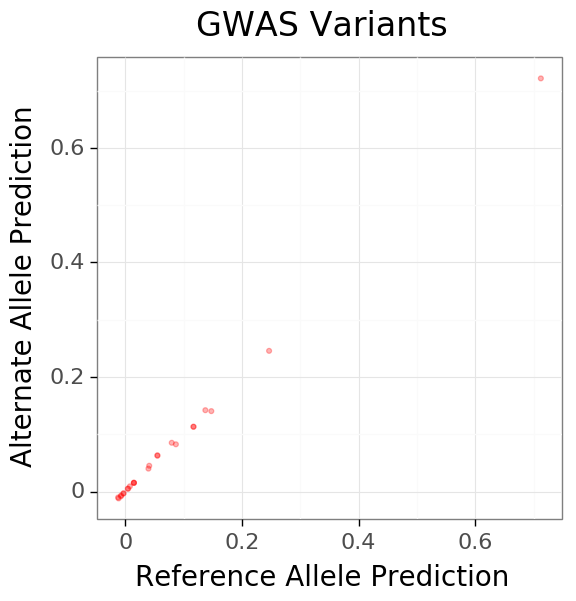

<ggplot: (8728129263855)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
5,chr6,111921050,111921051,rs943437,A,G,1.000000,chr6,111921050,88,rs943437,0.147549,0.140358,-0.007191
1,chr22,42479513,42479514,rs11705074,T,G,1.000000,chr22,42479513,64,rs11705074,0.086790,0.082431,-0.004359
21,chr6,111937536,111937537,rs10687473,A,AAAAT,0.854650,chr6,111921050,88,rs943437,0.116991,0.113068,-0.003923
20,chr6,111937536,111937537,rs147859592,A,AAAAT,0.854650,chr6,111921050,88,rs943437,0.116991,0.113068,-0.003923
14,chr6,111919129,111919130,rs9374302,G,A,0.925594,chr6,111921050,88,rs943437,0.246617,0.245579,-0.001038
3,chr6,71747595,71747596,rs9446462,C,A,1.000000,chr6,71747595,78,rs9446462,-0.007404,-0.008247,-0.000843
18,chr6,111930255,111930256,rs9387055,A,C,0.843445,chr6,111921050,88,rs943437,-0.011410,-0.011995,-0.000585
13,chr6,111913118,111913119,rs896454003,C,T,0.926443,chr6,111921050,88,rs943437,-0.003079,-0.003536,-0.000458
12,chr6,111913118,111913119,rs34258931,C,CT,0.926443,chr6,111921050,88,rs943437,-0.003079,-0.003079,0.000000
6,chr6,49461705,49461706,rs62411931,G,A,1.000000,chr6,49461705,100,rs62411931,0.004942,0.005026,0.000084


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
10,chr22,42485737,42485738,rs144088132,T,TAC,0.872864,chr22,42479513,64,rs11705074,0.014802,0.015307,0.000506
17,chr6,111928907,111928908,rs9400515,A,C,0.844289,chr6,111921050,88,rs943437,0.004200,0.004814,0.000614
2,chr13,90579739,90579740,rs140851527,A,G,1.000000,chr13,90579739,74,rs140851527,0.007895,0.009014,0.001120
11,chr6,111908723,111908724,rs9481202,A,G,0.881559,chr6,111921050,88,rs943437,-0.012249,-0.010395,0.001853
4,chr13,111395285,111395286,rs187520595,C,T,1.000000,chr13,111395285,84,rs187520595,0.041076,0.044987,0.003911
23,chr6,111940286,111940287,rs481262,T,C,0.847191,chr6,111921050,88,rs943437,0.137340,0.141977,0.004636
19,chr6,111936824,111936825,rs626007,A,G,0.917903,chr6,111921050,88,rs943437,0.079673,0.085078,0.005405
15,chr6,111922088,111922089,rs997368,A,C,0.852686,chr6,111921050,88,rs943437,0.055115,0.062445,0.007330
16,chr6,111922088,111922089,rs997368,A,G,0.852686,chr6,111921050,88,rs943437,0.055115,0.063271,0.008157
7,chr22,42483761,42483762,rs370511811,A,G,0.827822,chr22,42479513,64,rs11705074,0.712587,0.721220,0.008633


FOLD:  4
All SNPs:


(15, 13)

SNPs NOT in Peaks:


(14, 13)

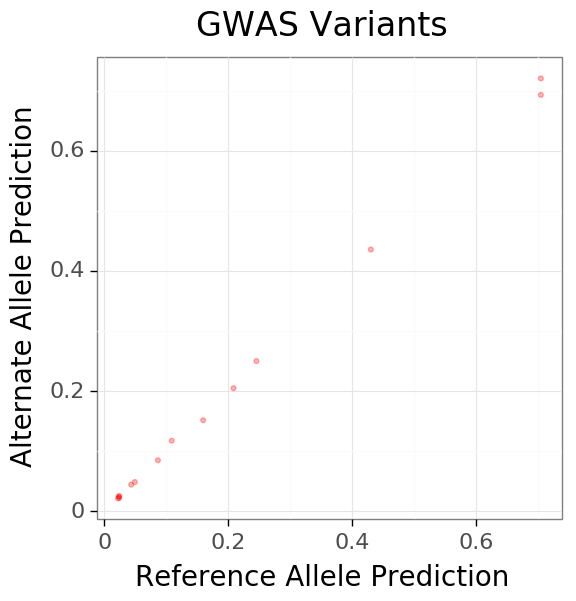

<ggplot: (8728129052971)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
3,chr5,124774580,124774581,rs6875262,T,C,1.000000,chr5,124774580,34,rs6875262,0.704308,0.692935,-0.011372
12,chr5,3504257,3504258,rs540581141,C,T,1.000000,chr5,2531144,67,rs149679249,0.159468,0.150993,-0.008475
7,chr5,84305922,84305923,rs147108359,G,A,1.000000,chr5,84305922,95,rs147108359,0.208413,0.204407,-0.004006
0,chr16,24655763,24655764,rs146398451,C,T,1.000000,chr16,24655763,27,rs146398451,0.023839,0.021582,-0.002257
8,chr16,58539193,58539194,rs76881424,C,T,0.833167,chr16,58553768,24,rs200564078,0.086434,0.084332,-0.002102
11,chr16,24743404,24743405,rs144948736,C,T,0.833000,chr16,24655763,27,rs146398451,0.022211,0.020819,-0.001392
10,chr16,24693600,24693601,rs572537035,CAAATA,C,0.809640,chr16,24655763,27,rs146398451,0.049216,0.048057,-0.001159
4,chr5,60839026,60839027,rs201395352,A,AT,1.000000,chr5,60839026,54,.,0.043272,0.043723,0.000451
1,chr16,24655763,24655764,rs776288687,C,CT,1.000000,chr16,24655763,27,rs146398451,0.023839,0.024475,0.000637
9,chr16,58770912,58770913,rs145178507,C,T,0.833167,chr16,58553768,24,rs200564078,0.023427,0.024100,0.000672


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
8,chr16,58539193,58539194,rs76881424,C,T,0.833167,chr16,58553768,24,rs200564078,0.086434,0.084332,-0.002102
11,chr16,24743404,24743405,rs144948736,C,T,0.833000,chr16,24655763,27,rs146398451,0.022211,0.020819,-0.001392
10,chr16,24693600,24693601,rs572537035,CAAATA,C,0.809640,chr16,24655763,27,rs146398451,0.049216,0.048057,-0.001159
4,chr5,60839026,60839027,rs201395352,A,AT,1.000000,chr5,60839026,54,.,0.043272,0.043723,0.000451
1,chr16,24655763,24655764,rs776288687,C,CT,1.000000,chr16,24655763,27,rs146398451,0.023839,0.024475,0.000637
9,chr16,58770912,58770913,rs145178507,C,T,0.833167,chr16,58553768,24,rs200564078,0.023427,0.024100,0.000672
13,chr5,174529858,174529859,rs11742484,A,T,0.870984,chr5,174553576,89,rs11743380,0.245323,0.249530,0.004207
5,chr5,2531144,2531145,rs149679249,T,C,1.000000,chr5,2531144,67,rs149679249,0.429994,0.435368,0.005374
6,chr5,174553576,174553577,rs11743380,C,T,1.000000,chr5,174553576,89,rs11743380,0.108727,0.116957,0.008230
2,chr5,124774580,124774581,rs6875262,T,A,1.000000,chr5,124774580,34,rs6875262,0.704308,0.720398,0.016090


FOLD:  5
All SNPs:


(46, 13)

SNPs in Peaks:


(1, 13)

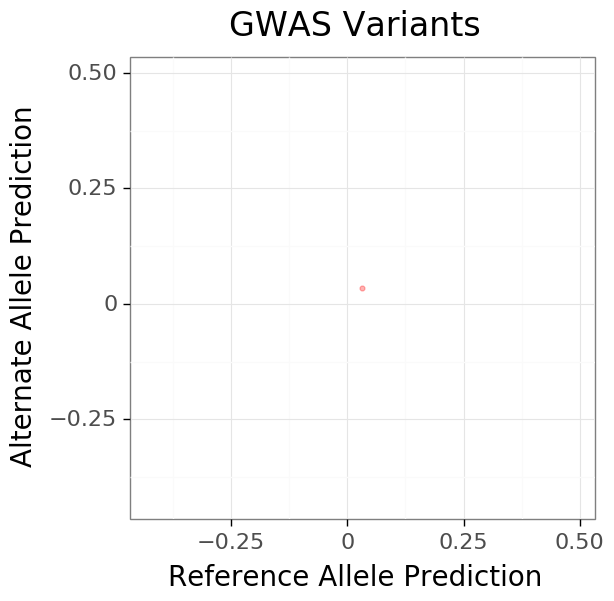

<ggplot: (-9223363308725696133)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr4,90290373,90290374,rs75541595,G,A,1.0,chr4,90290373,20,rs75541595,0.032326,0.033397,0.001071


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr4,90290373,90290374,rs75541595,G,A,1.0,chr4,90290373,20,rs75541595,0.032326,0.033397,0.001071


SNPs NOT in Peaks:


(43, 13)

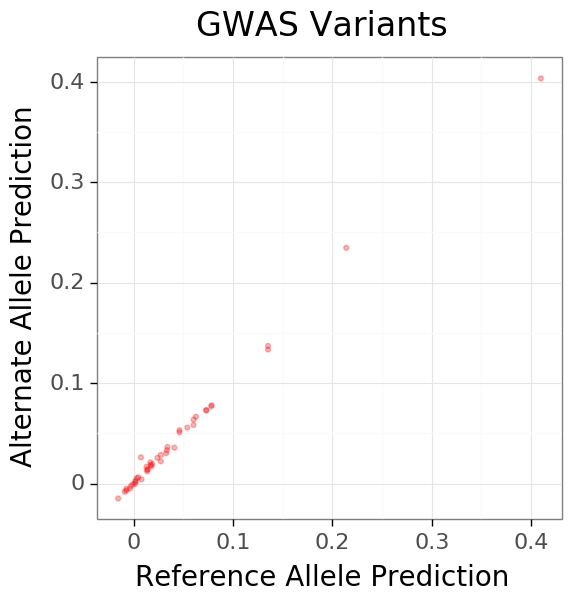

<ggplot: (8728129037625)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
1,chr4,182220835,182220836,rs2044779,T,A,1.000000,chr4,182220835,25,rs2044779,0.409759,0.403458,-0.006301
15,chr4,182221693,182221694,rs896026,C,T,0.992371,chr4,182220835,25,rs2044779,0.040850,0.035681,-0.005169
10,chr4,113891618,113891619,rs140020117,G,A,1.000000,chr4,113891618,80,rs140020117,0.027229,0.022119,-0.005109
36,chr4,178965290,178965291,rs75250430,C,T,0.986811,chr4,178957718,70,rs76856961,0.007769,0.004102,-0.003667
19,chr4,182222576,182222577,rs1450138,G,A,0.909311,chr4,182220835,25,rs2044779,0.032580,0.030181,-0.002399
16,chr4,182221774,182221775,rs896025,C,G,0.994275,chr4,182220835,25,rs2044779,0.060265,0.058292,-0.001973
31,chr4,178961601,178961602,rs1193967964,C,T,0.986811,chr4,178957718,70,rs76856961,0.001502,-0.000269,-0.001771
41,chr4,178971133,178971134,rs74855614,A,T,0.966952,chr4,178957718,70,rs76856961,0.135159,0.133411,-0.001748
29,chr4,178959592,178959593,rs111985289,C,T,0.993426,chr4,178957718,70,rs76856961,0.013535,0.012184,-0.001351
8,chr4,188259868,188259869,rs189149546,C,G,1.000000,chr4,188259868,49,rs189149546,-0.003754,-0.004939,-0.001185


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
5,chr4,102267552,102267553,rs13107325,C,T,1.000000,chr4,102267552,31,rs13107325,-0.007442,-0.005311,0.002130
22,chr4,15748080,15748081,rs10516292,C,T,0.993433,chr4,15749694,32,.,0.033935,0.036323,0.002388
17,chr4,182221774,182221775,rs896025,C,T,0.994275,chr4,182220835,25,rs2044779,0.060265,0.063630,0.003364
42,chr4,178973433,178973434,rs79405249,T,C,1.000000,chr4,178957718,70,rs76856961,0.012871,0.016776,0.003905
34,chr4,178963851,178963852,rs80116969,T,C,0.933991,chr4,178957718,70,rs76856961,0.062577,0.066611,0.004035
14,chr4,90242889,90242890,rs77713265,C,T,0.979893,chr4,90290373,20,rs75541595,0.016717,0.021121,0.004404
24,chr4,15756612,15756613,rs6834477,T,C,0.806952,chr4,15749694,32,.,0.046024,0.051109,0.005085
23,chr4,15756612,15756613,rs6834477,T,A,0.806952,chr4,15749694,32,.,0.046024,0.053144,0.007119
13,chr4,90229014,90229015,rs142404622,T,C,0.939527,chr4,90290373,20,rs75541595,0.007262,0.026094,0.018831
37,chr4,178965762,178965763,rs113530632,T,A,0.986811,chr4,178957718,70,rs76856961,0.213868,0.234760,0.020892


FOLD:  6
All SNPs:


(125, 13)

SNPs in Peaks:


(6, 13)

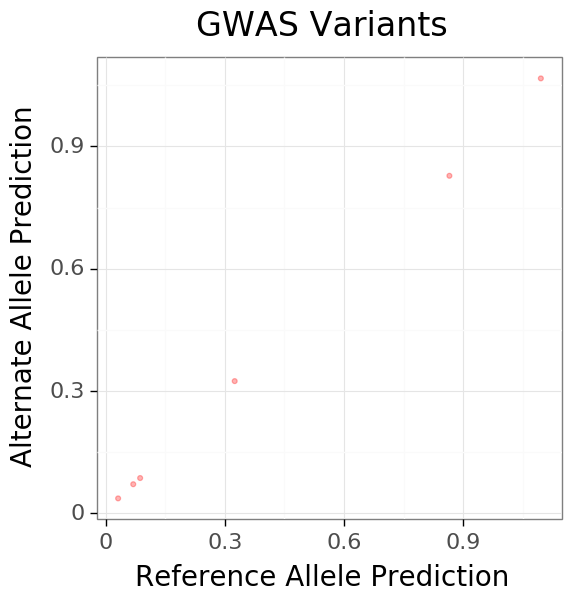

<ggplot: (-9223363308725659974)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr14,54901909,54901910,rs2149482,C,T,0.957318,chr14,54898613,26,rs8019824,0.865548,0.828005,-0.037543
2,chr7,23105676,23105677,rs10256996,T,G,0.870899,chr7,23104563,30,rs10488077,1.095993,1.067008,-0.028985
1,chr7,23105295,23105296,rs10241208,G,C,0.954185,chr7,23104563,30,rs10488077,0.324541,0.324301,-0.000240
3,chr7,23114694,23114695,rs2068459,A,C,0.892711,chr7,23104563,30,rs10488077,0.086282,0.086469,0.000187
5,chr18,43093415,43093416,rs12456492,A,G,0.813684,chr18,43098270,61,rs4130047,0.068909,0.071303,0.002394
4,chr7,23115906,23115907,rs73272053,A,G,0.866225,chr7,23104563,30,rs10488077,0.030810,0.036544,0.005734


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr14,54901909,54901910,rs2149482,C,T,0.957318,chr14,54898613,26,rs8019824,0.865548,0.828005,-0.037543
2,chr7,23105676,23105677,rs10256996,T,G,0.870899,chr7,23104563,30,rs10488077,1.095993,1.067008,-0.028985
1,chr7,23105295,23105296,rs10241208,G,C,0.954185,chr7,23104563,30,rs10488077,0.324541,0.324301,-0.000240
3,chr7,23114694,23114695,rs2068459,A,C,0.892711,chr7,23104563,30,rs10488077,0.086282,0.086469,0.000187
5,chr18,43093415,43093416,rs12456492,A,G,0.813684,chr18,43098270,61,rs4130047,0.068909,0.071303,0.002394
4,chr7,23115906,23115907,rs73272053,A,G,0.866225,chr7,23104563,30,rs10488077,0.030810,0.036544,0.005734


SNPs NOT in Peaks:


(117, 13)

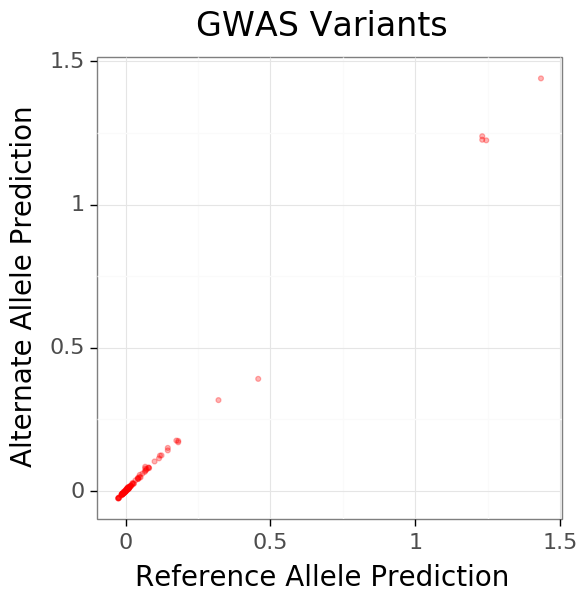

<ggplot: (-9223363308725779035)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
91,chr7,23136327,23136328,rs6953996,A,G,0.896863,chr7,23104563,30,rs10488077,0.457815,0.391292,-0.066523
12,chr14,54903567,54903568,rs10136972,A,G,0.948553,chr14,54898613,26,rs8019824,1.245022,1.224305,-0.020716
39,chr14,54960385,54960386,rs6572994,C,G,0.854750,chr14,54898613,26,rs8019824,0.181649,0.169739,-0.011910
38,chr14,54960385,54960386,rs6572994,C,A,0.854750,chr14,54898613,26,rs8019824,0.181649,0.174731,-0.006918
14,chr14,54903622,54903623,rs10137071,C,T,0.948553,chr14,54898613,26,rs8019824,1.231241,1.226330,-0.004911
114,chr14,87999742,87999743,rs7160146,T,A,0.914901,chr14,88006268,91,rs8005172,0.051786,0.047352,-0.004435
40,chr14,54961923,54961924,rs3783643,A,C,0.859338,chr14,54898613,26,rs8019824,0.145595,0.141513,-0.004081
113,chr14,87999527,87999528,rs59245224,A,C,0.914901,chr14,88006268,91,rs8005172,0.009794,0.005859,-0.003934
107,chr7,64293093,64293094,rs35919389,C,T,0.912771,chr7,64306602,85,rs10499772,0.320588,0.317050,-0.003537
111,chr14,87999515,87999516,rs774185270,C,CAT,0.914901,chr14,88006268,91,rs8005172,0.012503,0.009102,-0.003401


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
64,chr14,55005265,55005266,rs2840268,C,G,0.802271,chr14,54898613,26,rs8019824,0.023917,0.027805,0.003888
72,chr14,55010065,55010066,rs6572997,T,C,0.808842,chr14,54898613,26,rs8019824,-0.006965,-0.002790,0.004175
41,chr14,54961923,54961924,rs3783643,A,G,0.859338,chr14,54898613,26,rs8019824,0.145595,0.150156,0.004562
0,chr7,23104563,23104564,rs10488077,A,T,1.000000,chr7,23104563,30,rs10488077,0.118570,0.123195,0.004625
103,chr14,103459924,103459925,rs117105921,G,T,0.889983,chr14,103544952,62,rs151247738,0.007092,0.012398,0.005306
4,chr14,103544952,103544953,rs151247738,A,G,1.000000,chr14,103544952,62,rs151247738,1.434050,1.440646,0.006595
92,chr7,23146348,23146349,rs4559148,G,A,0.802003,chr7,23104563,30,rs10488077,0.048807,0.055982,0.007175
13,chr14,54903622,54903623,rs10137071,C,G,0.948553,chr14,54898613,26,rs8019824,1.231241,1.238647,0.007406
87,chr7,23114316,23114317,rs764534,C,T,0.888467,chr7,23104563,30,rs10488077,0.067602,0.078489,0.010886
86,chr7,23114316,23114317,rs764534,C,G,0.888467,chr7,23104563,30,rs10488077,0.067602,0.084457,0.016855


FOLD:  7
All SNPs:


(5154, 13)

SNPs in Peaks:


(352, 13)

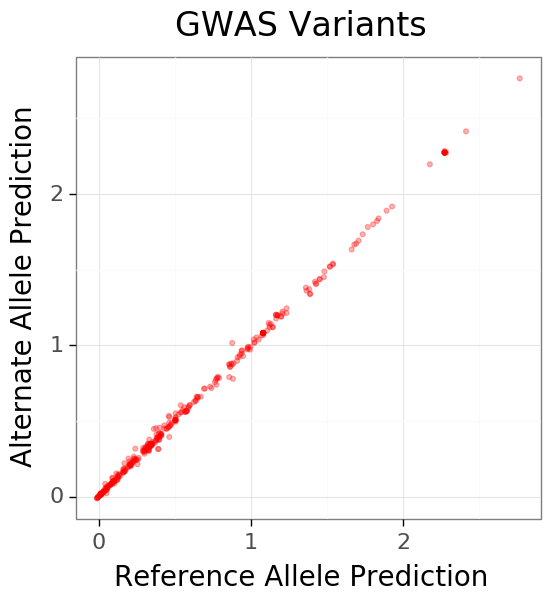

<ggplot: (8728129052971)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
337,chr17,46267724,46267725,rs2668719,C,A,0.820234,chr17,46105479,3,.,0.882461,0.778500,-0.103961
229,chr17,46122304,46122305,rs62061855,G,A,0.800577,chr17,46704858,6,.,0.392377,0.315095,-0.077282
228,chr17,46122304,46122305,rs62061855,G,A,0.994936,chr17,46105479,3,.,0.392377,0.315095,-0.077282
59,chr17,45722444,45722445,rs76667867,G,A,0.955856,chr17,46105479,3,.,0.464589,0.394662,-0.069927
338,chr17,46267748,46267749,rs2732652,C,T,0.820234,chr17,46105479,3,.,0.858395,0.789859,-0.068536
332,chr17,46267622,46267623,rs2732650,C,G,0.955019,chr17,46105479,3,.,1.389146,1.337736,-0.051410
333,chr17,46267622,46267623,rs2732650,C,T,0.955019,chr17,46105479,3,.,1.389146,1.340146,-0.049000
33,chr17,45703582,45703583,rs17762308,T,C,0.992408,chr17,46105479,3,.,0.256347,0.214020,-0.042327
115,chr17,45867740,45867741,rs62055475,T,C,0.992408,chr17,46105479,3,.,0.773814,0.739206,-0.034608
16,chr17,45639519,45639520,rs413778,A,G,0.992408,chr17,46105479,3,.,0.051733,0.021858,-0.029876


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
99,chr17,45827307,45827308,rs62057155,C,T,0.992408,chr17,46105479,3,.,0.169962,0.220596,0.050634
92,chr17,45826182,45826183,rs62057150,C,T,0.992408,chr17,46105479,3,.,0.196443,0.251270,0.054826
292,chr17,46260063,46260064,rs36061720,G,C,0.962832,chr17,46105479,3,.,0.400767,0.455729,0.054962
60,chr17,45722444,45722445,rs76667867,G,C,0.955856,chr17,46105479,3,.,0.464589,0.525415,0.060826
132,chr17,45896286,45896287,rs62056780,C,G,0.992408,chr17,46105479,3,.,0.540083,0.603911,0.063829
58,chr17,45722438,45722439,rs77819001,C,A,0.955856,chr17,46105479,3,.,0.461783,0.534454,0.072671
181,chr17,46004161,46004162,rs62064665,T,C,0.994936,chr17,46105479,3,.,0.377479,0.452541,0.075062
234,chr17,46130778,46130779,rs17661428,C,G,0.987347,chr17,46105479,3,.,0.241724,0.317237,0.075513
201,chr17,46044551,46044552,rs77768866,C,T,0.997473,chr17,46105479,3,.,0.363167,0.447240,0.084073
120,chr17,45894419,45894420,rs11575895,A,G,0.992408,chr17,46105479,3,.,0.877704,1.015248,0.137544


SNPs NOT in Peaks:


(4800, 13)

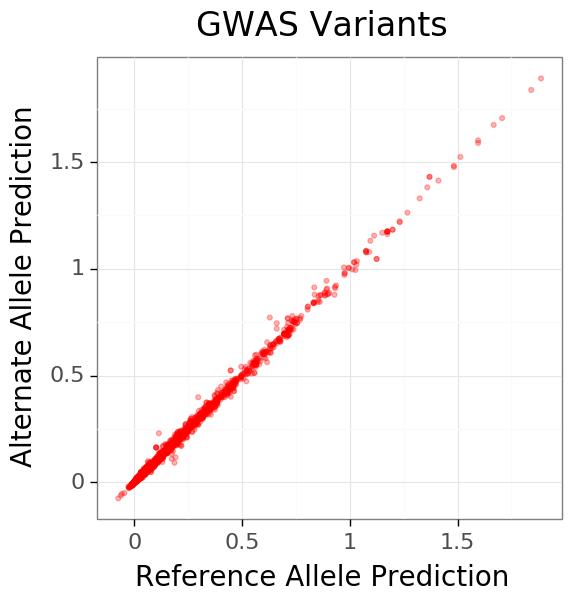

<ggplot: (8728128828669)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
738,chr17,45728224,45728225,rs62054388,C,T,0.887600,chr17,46105479,3,.,0.186174,0.091588,-0.094586
1423,chr17,45874233,45874234,rs67687156,CAGAT,C,0.992408,chr17,46105479,3,.,1.124313,1.046059,-0.078253
1422,chr17,45874233,45874234,rs67344622,CAGAT,C,0.992408,chr17,46105479,3,.,1.124313,1.046059,-0.078253
324,chr17,45649695,45649696,rs453997,C,T,0.987388,chr17,46105479,3,.,0.191068,0.117253,-0.073815
217,chr17,45613271,45613272,rs1191196046,T,TC,0.932062,chr17,46105479,3,.,0.173498,0.110057,-0.063441
2415,chr17,46012361,46012362,rs733969,G,A,0.997473,chr17,46105479,3,.,0.616038,0.562238,-0.053800
766,chr17,45733242,45733243,rs62054394,T,A,0.887600,chr17,46105479,3,.,0.928767,0.878235,-0.050532
1756,chr17,45925603,45925604,rs76090253,A,C,0.992408,chr17,46105479,3,.,0.217780,0.169467,-0.048313
688,chr17,45716843,45716844,rs4605208,G,C,0.958216,chr17,46105479,3,.,0.447567,0.400908,-0.046659
511,chr17,45691722,45691723,rs17761581,T,C,0.992408,chr17,46105479,3,.,0.519261,0.472790,-0.046471


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
3098,chr17,46078766,46078767,rs111750615,T,TTTA,1.000000,chr17,46105479,3,.,0.101309,0.163038,0.061729
3099,chr17,46078766,46078767,rs75081565,T,TTTA,1.000000,chr17,46105479,3,.,0.101309,0.163038,0.061729
3101,chr17,46078766,46078767,rs111750615,T,TTTA,0.801265,chr17,46704858,6,.,0.101309,0.163038,0.061729
2487,chr17,46017301,46017302,rs2316948,C,G,0.801265,chr17,46704858,6,.,0.446693,0.524057,0.077364
2486,chr17,46017301,46017302,rs2316948,C,G,1.000000,chr17,46105479,3,.,0.446693,0.524057,0.077364
978,chr17,45771602,45771603,rs62055937,G,T,0.992408,chr17,46105479,3,.,0.834969,0.912783,0.077814
1943,chr17,45947294,45947295,rs62062786,G,C,0.972708,chr17,46105479,3,.,0.660788,0.745252,0.084464
771,chr17,45733507,45733508,rs75022332,A,T,0.887600,chr17,46105479,3,.,0.296157,0.398380,0.102222
1612,chr17,45900754,45900755,rs62056796,A,G,0.992408,chr17,46105479,3,.,0.113531,0.229964,0.116433
605,chr17,45707628,45707629,rs62056913,C,T,0.987388,chr17,46105479,3,.,0.628593,0.771487,0.142893


FOLD:  8
All SNPs:


(44, 13)

SNPs in Peaks:


(4, 13)

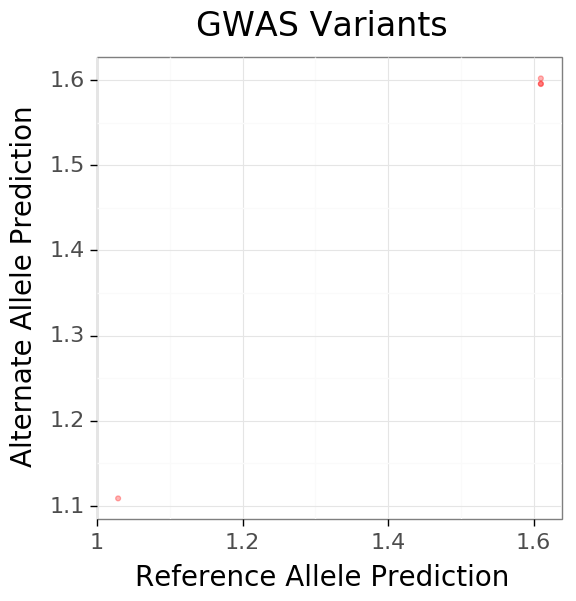

<ggplot: (8728128945598)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr12,122842051,122842052,rs10847864,G,C,0.815339,chr12,122838013,10,rs10847839,1.609883,1.595160,-0.014723
3,chr12,122842051,122842052,rs10847864,G,T,0.815339,chr12,122838013,10,rs10847839,1.609883,1.595640,-0.014244
1,chr12,122842051,122842052,rs10847864,G,A,0.815339,chr12,122838013,10,rs10847839,1.609883,1.601805,-0.008078
0,chr9,17579692,17579693,rs13294100,T,G,1.000000,chr9,17579692,39,rs13294100,1.028880,1.108842,0.079963


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr12,122842051,122842052,rs10847864,G,C,0.815339,chr12,122838013,10,rs10847839,1.609883,1.595160,-0.014723
3,chr12,122842051,122842052,rs10847864,G,T,0.815339,chr12,122838013,10,rs10847839,1.609883,1.595640,-0.014244
1,chr12,122842051,122842052,rs10847864,G,A,0.815339,chr12,122838013,10,rs10847839,1.609883,1.601805,-0.008078
0,chr9,17579692,17579693,rs13294100,T,G,1.000000,chr9,17579692,39,rs13294100,1.028880,1.108842,0.079963


SNPs NOT in Peaks:


(38, 13)

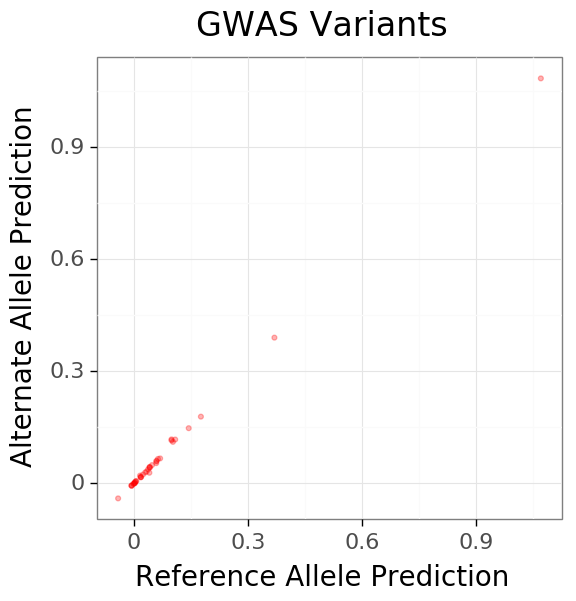

<ggplot: (8728128914019)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
22,chr12,34487679,34487680,rs189930135,C,T,1.000000,chr12,34487072,8,rs180751015,0.040598,0.028507,-0.012091
36,chr9,114810887,114810888,rs55914236,C,T,0.816031,chr9,114806968,96,rs55892528,0.058697,0.054270,-0.004427
29,chr12,37990378,37990379,rs148806299,C,T,0.888711,chr12,37566521,18,rs149617467,0.068855,0.066904,-0.001951
32,chr12,38022088,38022089,rs564412193,G,A,0.888711,chr12,37566521,18,rs149617467,0.018370,0.016547,-0.001823
15,chr12,38225761,38225762,rs192829408,G,A,1.000000,chr12,38225761,59,rs192829408,0.001999,0.000420,-0.001579
0,chr12,33946256,33946257,rs183981418,A,T,1.000000,chr12,33946256,5,rs183981418,0.033240,0.031751,-0.001489
10,chr12,32389884,32389885,rs148707891,G,C,1.000000,chr12,32389884,33,rs148707891,0.017805,0.016603,-0.001202
16,chr12,38225761,38225762,rs192829408,G,T,1.000000,chr12,38225761,59,rs192829408,0.001999,0.001016,-0.000983
25,chr12,33050376,33050377,rs117084165,A,G,1.000000,chr12,33075690,16,rs138895122,0.018111,0.017264,-0.000847
1,chr12,34487072,34487073,rs180751015,C,A,1.000000,chr12,34487072,8,rs180751015,0.002403,0.001904,-0.000499


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
20,chr12,40158476,40158477,rs187827177,C,T,1.000000,chr12,40340400,1,rs34637584,0.041422,0.043760,0.002338
17,chr9,114806968,114806969,rs55892528,C,T,1.000000,chr9,114806968,96,rs55892528,0.176039,0.178752,0.002714
9,chr12,42141601,42141602,rs144755950,T,C,1.000000,chr12,42141601,23,rs144755950,0.144029,0.147871,0.003842
34,chr12,32358558,32358559,rs185414076,G,A,0.882000,chr12,32389884,33,rs148707891,0.016080,0.020839,0.004759
30,chr12,37999497,37999498,rs184239956,A,G,0.888711,chr12,37566521,18,rs149617467,0.102505,0.111255,0.008750
2,chr12,122838013,122838014,rs10847839,T,C,1.000000,chr12,122838013,10,rs10847839,0.108463,0.117480,0.009018
5,chr12,37566521,37566522,rs149617467,C,T,1.000000,chr12,37566521,18,rs149617467,1.069860,1.084497,0.014637
14,chr9,138121810,138121811,rs2278973,T,G,1.000000,chr9,138121810,48,rs2278973,0.098804,0.115350,0.016545
13,chr9,138121810,138121811,rs2278973,T,A,1.000000,chr9,138121810,48,rs2278973,0.098804,0.117845,0.019040
31,chr12,38008145,38008146,rs74772260,C,T,0.888711,chr12,37566521,18,rs149617467,0.369354,0.390291,0.020937


FOLD:  9
All SNPs:


(14, 13)

SNPs in Peaks:


(1, 13)

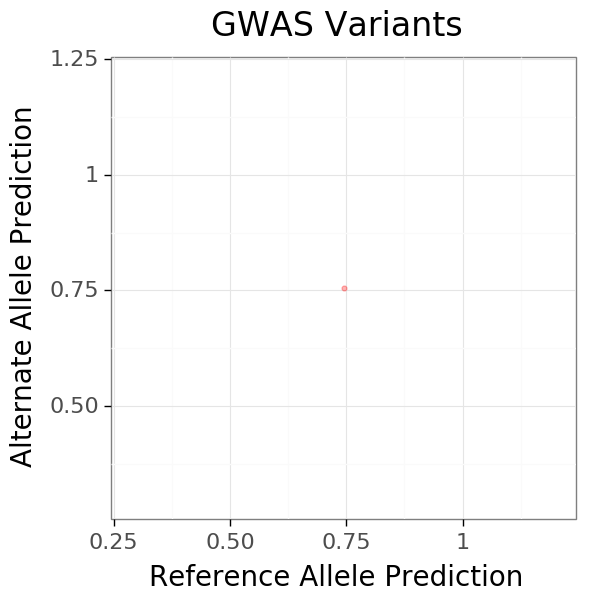

<ggplot: (-9223363308725822674)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr10,119651405,119651406,rs144814361,C,T,1.0,chr10,119651405,15,rs144814361,0.744754,0.754389,0.009636


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr10,119651405,119651406,rs144814361,C,T,1.0,chr10,119651405,15,rs144814361,0.744754,0.754389,0.009636


SNPs NOT in Peaks:


(11, 13)

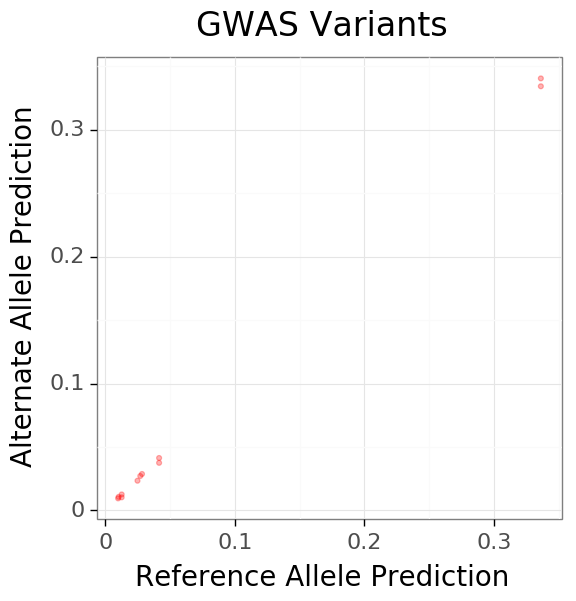

<ggplot: (-9223363308725733211)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr8,34227886,34227887,rs201891502,C,CT,1.000000,chr8,34227886,51,rs1446651337,0.041553,0.037542,-0.004011
4,chr8,20030802,20030803,rs73208821,G,C,1.000000,chr8,20030802,55,rs73208821,0.012654,0.010366,-0.002288
1,chr10,2172585,2172586,rs75482696,T,C,1.000000,chr10,2172585,43,rs75482696,0.336281,0.334255,-0.002026
5,chr8,11854934,11854935,rs1293298,A,C,1.000000,chr8,11854934,75,rs1293298,0.024875,0.023446,-0.001429
8,chr8,36255602,36255603,rs76104776,A,C,1.000000,chr8,36255602,101,rs76104776,0.009919,0.009533,-0.000386
3,chr8,34227886,34227887,rs1446651337,C,G,1.000000,chr8,34227886,51,rs1446651337,0.041553,0.041368,-0.000185
9,chr8,20026413,20026414,rs73208819,T,C,0.833398,chr8,20030802,55,rs73208821,0.012674,0.012655,-0.000019
7,chr10,76731020,76731021,rs74860646,T,G,1.000000,chr10,76731020,81,rs74860646,0.027023,0.027187,0.000164
6,chr8,109740385,109740386,rs72669174,T,A,1.000000,chr8,109740385,79,rs72669174,0.010315,0.010692,0.000377
10,chr10,76742310,76742311,rs17231856,A,C,0.843823,chr10,76731020,81,rs74860646,0.028358,0.028762,0.000405


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
4,chr8,20030802,20030803,rs73208821,G,C,1.000000,chr8,20030802,55,rs73208821,0.012654,0.010366,-0.002288
1,chr10,2172585,2172586,rs75482696,T,C,1.000000,chr10,2172585,43,rs75482696,0.336281,0.334255,-0.002026
5,chr8,11854934,11854935,rs1293298,A,C,1.000000,chr8,11854934,75,rs1293298,0.024875,0.023446,-0.001429
8,chr8,36255602,36255603,rs76104776,A,C,1.000000,chr8,36255602,101,rs76104776,0.009919,0.009533,-0.000386
3,chr8,34227886,34227887,rs1446651337,C,G,1.000000,chr8,34227886,51,rs1446651337,0.041553,0.041368,-0.000185
9,chr8,20026413,20026414,rs73208819,T,C,0.833398,chr8,20030802,55,rs73208821,0.012674,0.012655,-0.000019
7,chr10,76731020,76731021,rs74860646,T,G,1.000000,chr10,76731020,81,rs74860646,0.027023,0.027187,0.000164
6,chr8,109740385,109740386,rs72669174,T,A,1.000000,chr8,109740385,79,rs72669174,0.010315,0.010692,0.000377
10,chr10,76742310,76742311,rs17231856,A,C,0.843823,chr10,76731020,81,rs74860646,0.028358,0.028762,0.000405
0,chr10,2172585,2172586,rs75482696,T,A,1.000000,chr10,2172585,43,rs75482696,0.336281,0.340468,0.004187


In [9]:
get_results_all_folds('PD_GBA1_MDTG')

TASK:  PD_CTRL_SUNI
FOLD:  0
All SNPs:


(35, 13)

SNPs in Peaks:


(3, 13)

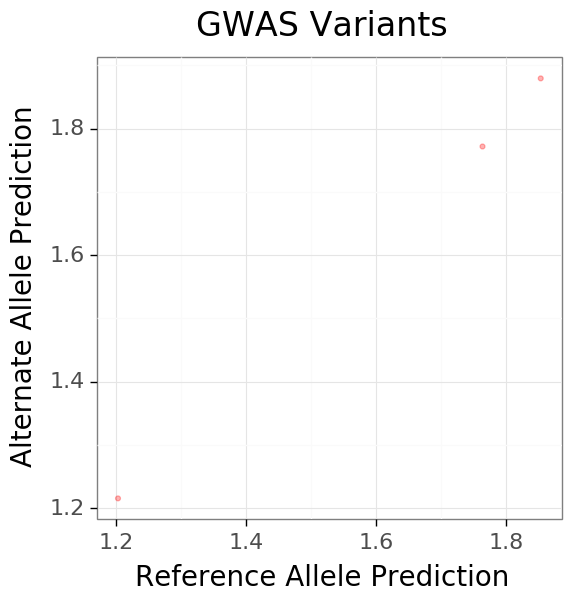

<ggplot: (-9223363308726059576)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr1,155135691,155135692,rs12726330,G,C,1.000000,chr1,155135691,9,rs12726330,1.763909,1.771775,0.007866
1,chr1,205750404,205750405,rs823114,G,A,0.953762,chr1,205770138,21,rs708723,1.202981,1.215199,0.012218
2,chr1,8409729,8409730,rs2661868,C,T,0.984181,chr1,8390388,77,rs2708628,1.853482,1.879494,0.026012


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr1,155135691,155135692,rs12726330,G,C,1.000000,chr1,155135691,9,rs12726330,1.763909,1.771775,0.007866
1,chr1,205750404,205750405,rs823114,G,A,0.953762,chr1,205770138,21,rs708723,1.202981,1.215199,0.012218
2,chr1,8409729,8409730,rs2661868,C,T,0.984181,chr1,8390388,77,rs2708628,1.853482,1.879494,0.026012


SNPs NOT in Peaks:


(30, 13)

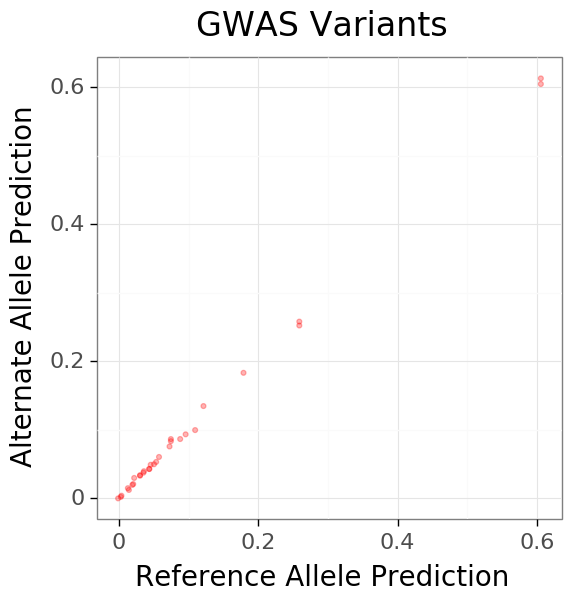

<ggplot: (8728128749295)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
14,chr1,155235587,155235588,rs12752133,C,T,0.812944,chr1,155135691,9,rs12726330,0.109210,0.099175,-0.010035
21,chr1,8380583,8380584,rs2636314,G,A,0.975367,chr1,8390388,77,rs2708628,0.258784,0.252020,-0.006763
2,chr1,183922245,183922246,rs113076859,C,T,1.000000,chr1,183922245,50,rs113076859,0.095581,0.092966,-0.002614
27,chr1,8416395,8416396,rs2708625,T,C,0.878326,chr1,8390388,77,rs2708628,0.014080,0.011680,-0.002400
5,chr1,10405391,10405392,rs199959132,AAAC,A,1.000000,chr1,10405391,72,.,0.087712,0.086109,-0.001603
10,chr1,155015779,155015780,rs71628639,C,T,0.885591,chr1,155135691,9,rs12726330,0.043298,0.042207,-0.001090
22,chr1,8380583,8380584,rs2636314,G,C,0.975367,chr1,8390388,77,rs2708628,0.258784,0.257724,-0.001060
15,chr1,155236376,155236377,rs2230288,C,T,0.812944,chr1,155135691,9,rs12726330,0.050145,0.049203,-0.000942
9,chr1,155015779,155015780,rs71628639,C,A,0.885591,chr1,155135691,9,rs12726330,0.043298,0.042366,-0.000932
23,chr1,8403450,8403451,rs2708631,C,T,0.986964,chr1,8390388,77,rs2708628,0.002436,0.001506,-0.000929


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr1,155850943,155850944,rs34032320,G,C,1.000000,chr1,155850943,12,rs34032320,0.072438,0.075247,0.002809
24,chr1,8406157,8406158,rs2784738,G,A,0.988433,chr1,8390388,77,rs2708628,0.030078,0.033183,0.003106
6,chr1,8390388,8390389,rs2708628,T,C,1.000000,chr1,8390388,77,rs2708628,0.045367,0.048504,0.003137
4,chr1,18814620,18814621,rs191668177,C,G,1.000000,chr1,18814620,60,rs191668177,0.035662,0.039051,0.003389
28,chr1,8437498,8437499,rs2784739,T,G,0.892586,chr1,8390388,77,rs2708628,0.178678,0.182875,0.004196
16,chr1,155924191,155924192,rs547368930,CCTATAGTCCCAGCTA,C,0.828027,chr1,155850943,12,rs34032320,0.021673,0.029231,0.007558
8,chr1,246782994,246782995,rs149745071,C,T,1.000000,chr1,246782994,93,rs149745071,0.605652,0.613238,0.007587
19,chr1,205754444,205754445,rs823118,C,T,0.972244,chr1,205770138,21,rs708723,0.074388,0.082989,0.008601
18,chr1,205754444,205754445,rs823118,C,A,0.972244,chr1,205770138,21,rs708723,0.074388,0.086005,0.011617
3,chr1,119094055,119094056,rs76695140,A,G,1.000000,chr1,119094055,53,rs76695140,0.121188,0.134293,0.013105


FOLD:  1
All SNPs:


(58, 13)

SNPs NOT in Peaks:


(57, 13)

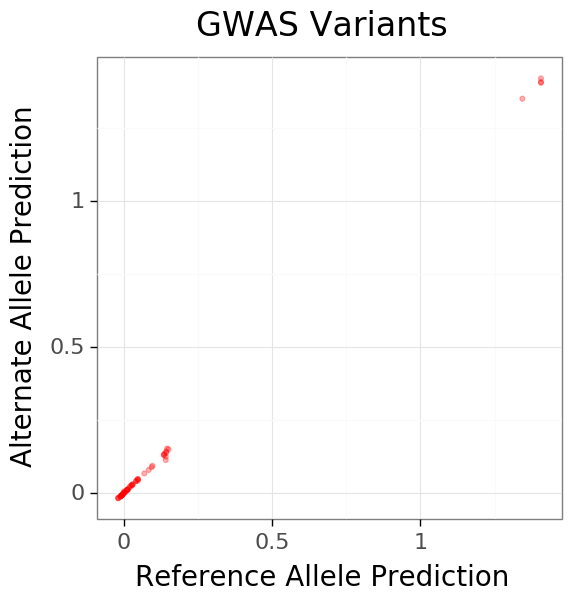

<ggplot: (8728128759388)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
31,chr2,134782976,134782977,rs7599054,A,T,0.976667,chr2,134825938,37,rs6760237,0.141922,0.113945,-0.027977
30,chr2,134782976,134782977,rs7599054,A,G,0.976667,chr2,134825938,37,rs6760237,0.141922,0.124952,-0.016970
28,chr2,134779549,134779550,rs6741007,T,G,0.977944,chr2,134825938,37,rs6760237,0.094561,0.089657,-0.004905
40,chr2,62495666,62495667,rs539968640,C,T,0.973916,chr2,62495157,45,rs10211381,0.047799,0.042999,-0.004800
6,chr19,2791655,2791656,rs59303624,G,T,1.000000,chr19,2791655,47,rs59303624,0.143737,0.139006,-0.004731
10,chr2,46410382,46410383,rs150828230,G,A,1.000000,chr2,46410382,90,rs150828230,0.084308,0.079791,-0.004517
32,chr2,134790951,134790952,rs146112546,C,CAAG,0.966542,chr2,134825938,37,rs6760237,0.135652,0.131345,-0.004307
33,chr2,134790951,134790952,rs34284021,C,CAAG,0.966542,chr2,134825938,37,rs6760237,0.135652,0.131345,-0.004307
21,chr2,101986680,101986681,rs17815304,G,A,0.842426,chr2,101988187,29,rs12467316,0.097074,0.094168,-0.002906
46,chr19,2813855,2813856,rs1478922243,C,T,0.879171,chr19,2791655,47,rs59303624,1.405978,1.403303,-0.002675


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
41,chr2,62495666,62495667,rs777067833,C,CG,0.973916,chr2,62495157,45,rs10211381,0.047799,0.048978,0.001179
9,chr2,153110678,153110679,rs1347394,T,C,1.000000,chr2,153110678,82,rs1347394,0.046878,0.048080,0.001203
11,chr2,220851226,220851227,rs73993676,C,T,1.000000,chr2,220851226,99,rs73993676,0.022080,0.023688,0.001608
23,chr2,101989388,101989389,rs201052897,A,T,0.919644,chr2,101988187,29,rs12467316,0.027261,0.029024,0.001763
1,chr2,134825938,134825939,rs6760237,A,C,1.000000,chr2,134825938,37,rs6760237,-0.018084,-0.015619,0.002465
2,chr2,134825938,134825939,rs6760237,A,G,1.000000,chr2,134825938,37,rs6760237,-0.018084,-0.015134,0.002949
45,chr19,2813805,2813806,rs73524732,G,A,0.879171,chr19,2791655,47,rs59303624,1.343489,1.348991,0.005503
7,chr2,126517671,126517672,rs77643088,G,C,1.000000,chr2,126517671,63,rs77643088,0.001186,0.006842,0.005656
49,chr19,2813959,2813960,rs113301220,A,G,0.873043,chr19,2791655,47,rs59303624,0.146208,0.153195,0.006987
47,chr19,2813855,2813856,rs146390273,C,CCT,0.879171,chr19,2791655,47,rs59303624,1.405978,1.418417,0.012439


FOLD:  2
All SNPs:


(70, 13)

SNPs in Peaks:


(0, 13)

AttributeError: 'list' object has no attribute 'keys'

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta


SNPs NOT in Peaks:


(68, 13)

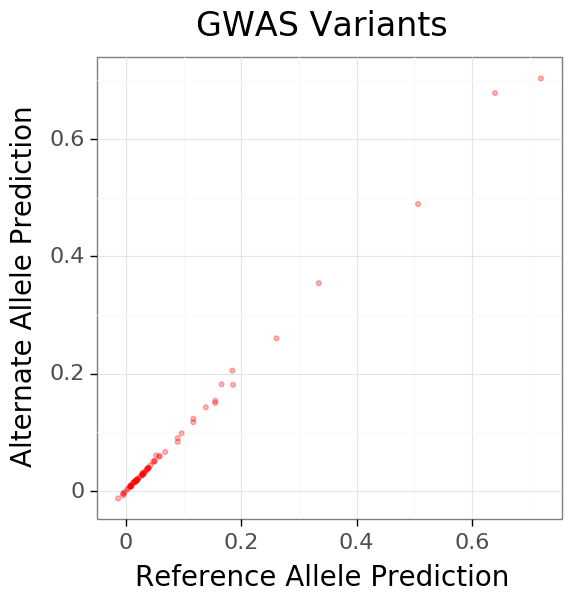

<ggplot: (8728128890674)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr3,183010401,183010402,rs5854965,CTAGG,C,1.000000,chr3,183010401,14,.,0.506641,0.488988,-0.017653
11,chr3,183010393,183010394,rs4074310,T,G,1.000000,chr3,183010401,14,.,0.719485,0.703335,-0.016149
31,chr3,18175216,18175217,rs1022089937,C,T,1.000000,chr3,18181950,87,rs13078687,0.089903,0.083565,-0.006339
53,chr3,18227051,18227052,rs73034316,G,A,0.856038,chr3,18181950,87,rs13078687,0.185778,0.180764,-0.005014
54,chr3,18235996,18235997,rs4073221,T,C,0.832098,chr3,18181950,87,rs13078687,0.154795,0.149835,-0.004959
16,chr3,19099375,19099376,rs560102474,G,A,1.000000,chr3,19609963,86,rs146933024,-0.004622,-0.007500,-0.002878
17,chr3,19110757,19110758,rs183851740,A,G,1.000000,chr3,19609963,86,rs146933024,0.032287,0.030153,-0.002134
7,chr3,18704008,18704009,rs13095117,A,G,1.000000,chr3,18704008,94,rs13095117,0.068084,0.066349,-0.001735
13,chr3,4542360,4542361,rs304003,C,T,0.832470,chr3,4540543,36,rs304048,0.009684,0.008103,-0.001581
36,chr3,18176279,18176280,rs35171423,T,C,1.000000,chr3,18181950,87,rs13078687,0.029638,0.028130,-0.001508


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
8,chr3,151435149,151435150,rs10935849,G,T,1.000000,chr3,151435149,97,rs10935849,0.049710,0.051440,0.001731
40,chr3,18186515,18186516,rs67917716,C,A,1.000000,chr3,18181950,87,rs13078687,0.014181,0.016135,0.001954
34,chr3,18176108,18176109,rs36087209,G,C,0.996583,chr3,18181950,87,rs13078687,0.047285,0.049702,0.002417
35,chr3,18176181,18176182,rs35051749,T,C,1.000000,chr3,18181950,87,rs13078687,0.138551,0.142556,0.004005
58,chr3,18238784,18238785,rs66479003,G,T,0.835022,chr3,18181950,87,rs13078687,0.116893,0.122893,0.006000
14,chr3,4544215,4544216,rs304007,G,T,0.806552,chr3,4540543,36,rs304048,0.052317,0.060425,0.008107
33,chr3,18175539,18175540,rs67392505,G,C,1.000000,chr3,18181950,87,rs13078687,0.165720,0.181623,0.015903
41,chr3,18189881,18189882,rs35407649,C,A,0.941916,chr3,18181950,87,rs13078687,0.334436,0.354152,0.019717
18,chr3,19400018,19400019,rs187635580,G,A,0.874825,chr3,19609963,86,rs146933024,0.184526,0.205049,0.020523
4,chr20,57685746,57685747,rs145427294,G,C,1.000000,chr20,57685746,68,rs145427294,0.640054,0.678336,0.038282


FOLD:  3
All SNPs:


(25, 13)

SNPs NOT in Peaks:


(24, 13)

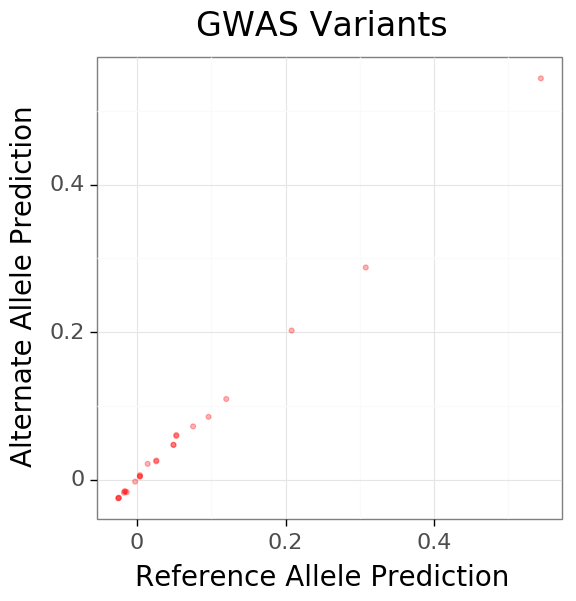

<ggplot: (8728128761124)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
14,chr6,111919129,111919130,rs9374302,G,A,0.925594,chr6,111921050,88,rs943437,0.308070,0.287565,-0.020505
19,chr6,111936824,111936825,rs626007,A,G,0.917903,chr6,111921050,88,rs943437,0.096316,0.085085,-0.011230
1,chr22,42479513,42479514,rs11705074,T,G,1.000000,chr22,42479513,64,rs11705074,0.120101,0.109215,-0.010886
5,chr6,111921050,111921051,rs943437,A,G,1.000000,chr6,111921050,88,rs943437,0.208211,0.202089,-0.006123
23,chr6,111940286,111940287,rs481262,T,C,0.847191,chr6,111921050,88,rs943437,0.075469,0.072170,-0.003299
6,chr6,49461705,49461706,rs62411931,G,A,1.000000,chr6,49461705,100,rs62411931,-0.013838,-0.017020,-0.003182
21,chr6,111937536,111937537,rs10687473,A,AAAAT,0.854650,chr6,111921050,88,rs943437,0.049071,0.047092,-0.001979
20,chr6,111937536,111937537,rs147859592,A,AAAAT,0.854650,chr6,111921050,88,rs943437,0.049071,0.047092,-0.001979
4,chr13,111395285,111395286,rs187520595,C,T,1.000000,chr13,111395285,84,rs187520595,0.025673,0.024732,-0.000941
17,chr6,111928907,111928908,rs9400515,A,C,0.844289,chr6,111921050,88,rs943437,-0.015877,-0.016258,-0.000381


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr6,108936803,108936804,rs183339976,A,G,1.000000,chr6,108936803,56,rs183339976,-0.002644,-0.002665,-0.000021
12,chr6,111913118,111913119,rs34258931,C,CT,0.926443,chr6,111921050,88,rs943437,-0.024648,-0.024648,0.000000
2,chr13,90579739,90579740,rs140851527,A,G,1.000000,chr13,90579739,74,rs140851527,-0.025535,-0.025454,0.000081
10,chr22,42485737,42485738,rs144088132,T,TAC,0.872864,chr22,42479513,64,rs11705074,0.003849,0.004293,0.000445
8,chr22,42485737,42485738,rs140570025,T,TAC,0.872864,chr22,42479513,64,rs11705074,0.003849,0.004293,0.000445
3,chr6,71747595,71747596,rs9446462,C,A,1.000000,chr6,71747595,78,rs9446462,-0.016754,-0.015683,0.001071
9,chr22,42485737,42485738,rs1383691167,T,C,0.872864,chr22,42479513,64,rs11705074,0.003849,0.006075,0.002226
16,chr6,111922088,111922089,rs997368,A,G,0.852686,chr6,111921050,88,rs943437,0.052841,0.059130,0.006288
11,chr6,111908723,111908724,rs9481202,A,G,0.881559,chr6,111921050,88,rs943437,0.014307,0.021346,0.007039
15,chr6,111922088,111922089,rs997368,A,C,0.852686,chr6,111921050,88,rs943437,0.052841,0.060449,0.007608


FOLD:  4
All SNPs:


(15, 13)

SNPs NOT in Peaks:


(14, 13)

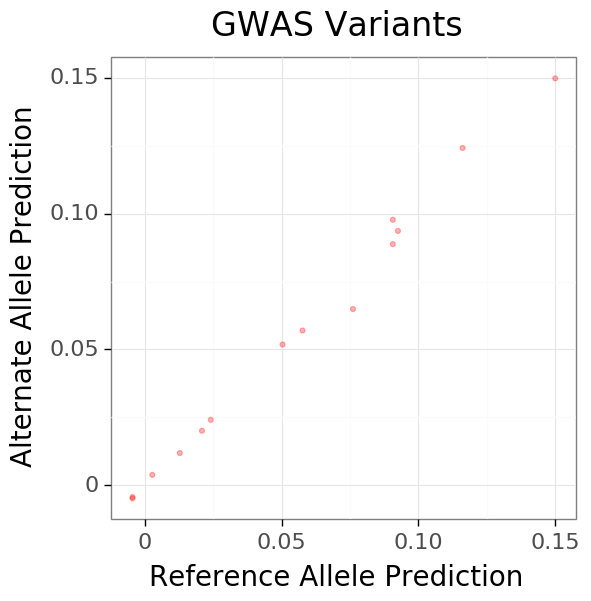

<ggplot: (-9223363308726115724)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
7,chr5,84305922,84305923,rs147108359,G,A,1.000000,chr5,84305922,95,rs147108359,0.076064,0.064887,-0.011177
3,chr5,124774580,124774581,rs6875262,T,C,1.000000,chr5,124774580,34,rs6875262,0.090624,0.088745,-0.001879
11,chr16,24743404,24743405,rs144948736,C,T,0.833000,chr16,24655763,27,rs146398451,0.012736,0.011913,-0.000823
10,chr16,24693600,24693601,rs572537035,CAAATA,C,0.809640,chr16,24655763,27,rs146398451,0.020833,0.020120,-0.000713
13,chr5,174529858,174529859,rs11742484,A,T,0.870984,chr5,174553576,89,rs11743380,0.057607,0.056987,-0.000620
8,chr16,58539193,58539194,rs76881424,C,T,0.833167,chr16,58553768,24,rs200564078,0.150007,0.149704,-0.000303
0,chr16,24655763,24655764,rs146398451,C,T,1.000000,chr16,24655763,27,rs146398451,-0.004561,-0.004761,-0.000200
12,chr5,3504257,3504258,rs540581141,C,T,1.000000,chr5,2531144,67,rs149679249,0.024071,0.024146,0.000076
1,chr16,24655763,24655764,rs776288687,C,CT,1.000000,chr16,24655763,27,rs146398451,-0.004561,-0.004274,0.000287
5,chr5,2531144,2531145,rs149679249,T,C,1.000000,chr5,2531144,67,rs149679249,0.092512,0.093606,0.001094


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
13,chr5,174529858,174529859,rs11742484,A,T,0.870984,chr5,174553576,89,rs11743380,0.057607,0.056987,-0.000620
8,chr16,58539193,58539194,rs76881424,C,T,0.833167,chr16,58553768,24,rs200564078,0.150007,0.149704,-0.000303
0,chr16,24655763,24655764,rs146398451,C,T,1.000000,chr16,24655763,27,rs146398451,-0.004561,-0.004761,-0.000200
12,chr5,3504257,3504258,rs540581141,C,T,1.000000,chr5,2531144,67,rs149679249,0.024071,0.024146,0.000076
1,chr16,24655763,24655764,rs776288687,C,CT,1.000000,chr16,24655763,27,rs146398451,-0.004561,-0.004274,0.000287
5,chr5,2531144,2531145,rs149679249,T,C,1.000000,chr5,2531144,67,rs149679249,0.092512,0.093606,0.001094
4,chr5,60839026,60839027,rs201395352,A,AT,1.000000,chr5,60839026,54,.,0.002696,0.003888,0.001191
9,chr16,58770912,58770913,rs145178507,C,T,0.833167,chr16,58553768,24,rs200564078,0.050305,0.051828,0.001523
2,chr5,124774580,124774581,rs6875262,T,A,1.000000,chr5,124774580,34,rs6875262,0.090624,0.097713,0.007089
6,chr5,174553576,174553577,rs11743380,C,T,1.000000,chr5,174553576,89,rs11743380,0.116141,0.124118,0.007977


FOLD:  5
All SNPs:


(46, 13)

SNPs in Peaks:


(1, 13)

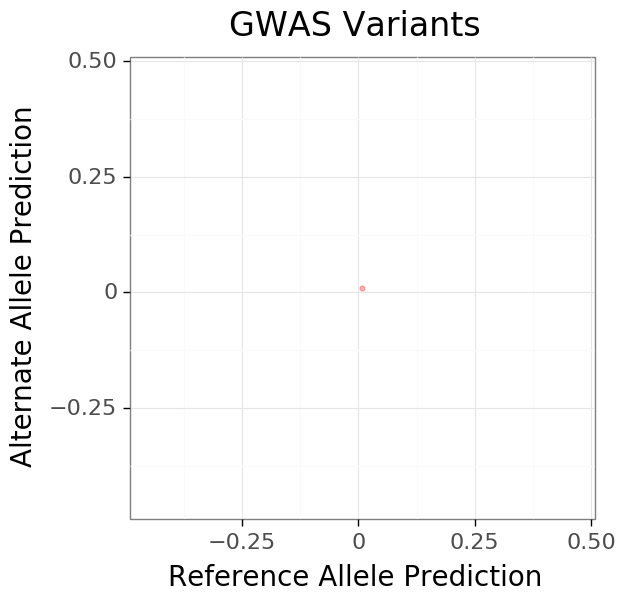

<ggplot: (8728128584901)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr4,90290373,90290374,rs75541595,G,A,1.0,chr4,90290373,20,rs75541595,0.008538,0.008551,0.000013


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr4,90290373,90290374,rs75541595,G,A,1.0,chr4,90290373,20,rs75541595,0.008538,0.008551,0.000013


SNPs NOT in Peaks:


(43, 13)

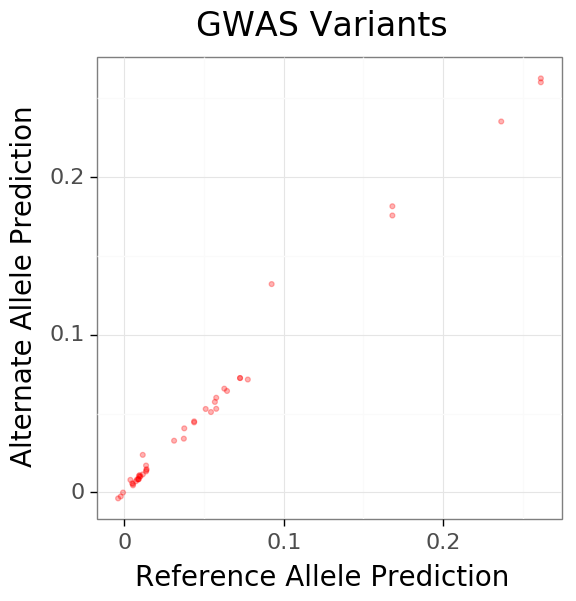

<ggplot: (8728128589660)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
30,chr4,178959599,178959600,rs113785126,C,T,1.000000,chr4,178957718,70,rs76856961,0.077418,0.071604,-0.005813
10,chr4,113891618,113891619,rs140020117,G,A,1.000000,chr4,113891618,80,rs140020117,0.057589,0.053022,-0.004567
3,chr21,44406603,44406604,rs759304969,GTCT,G,1.000000,chr21,44406603,28,rs56379273,0.054287,0.050979,-0.003308
39,chr4,178968614,178968615,rs78326713,T,C,0.940563,chr4,178957718,70,rs76856961,0.037269,0.034083,-0.003185
41,chr4,178971133,178971134,rs74855614,A,T,0.966952,chr4,178957718,70,rs76856961,0.261313,0.260155,-0.001158
1,chr4,182220835,182220836,rs2044779,T,A,1.000000,chr4,182220835,25,rs2044779,0.236450,0.235297,-0.001153
31,chr4,178961601,178961602,rs1193967964,C,T,0.986811,chr4,178957718,70,rs76856961,0.005363,0.004461,-0.000902
15,chr4,182221693,182221694,rs896026,C,T,0.992371,chr4,182220835,25,rs2044779,0.008876,0.008253,-0.000623
17,chr4,182221774,182221775,rs896025,C,T,0.994275,chr4,182220835,25,rs2044779,0.008737,0.008342,-0.000394
4,chr4,102267552,102267553,rs13107325,C,A,1.000000,chr4,102267552,31,rs13107325,0.013559,0.013279,-0.000280


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2,chr21,44406603,44406604,rs56379273,G,A,1.000000,chr21,44406603,28,rs56379273,0.050979,0.052917,0.001938
11,chr4,113891618,113891619,rs140020117,G,C,1.000000,chr4,113891618,80,rs140020117,0.057589,0.060035,0.002447
22,chr4,15748080,15748081,rs10516292,C,T,0.993433,chr4,15749694,32,.,0.037538,0.040630,0.003092
34,chr4,178963851,178963852,rs80116969,T,C,0.933991,chr4,178957718,70,rs76856961,0.062663,0.065802,0.003139
5,chr4,102267552,102267553,rs13107325,C,T,1.000000,chr4,102267552,31,rs13107325,0.013559,0.017048,0.003489
9,chr4,178957718,178957719,rs76856961,A,G,1.000000,chr4,178957718,70,rs76856961,0.003718,0.007940,0.004221
24,chr4,15756612,15756613,rs6834477,T,C,0.806952,chr4,15749694,32,.,0.168138,0.175653,0.007515
12,chr4,90229003,90229004,rs148785888,A,C,0.939527,chr4,90290373,20,rs75541595,0.011479,0.023805,0.012326
23,chr4,15756612,15756613,rs6834477,T,A,0.806952,chr4,15749694,32,.,0.168138,0.181520,0.013382
13,chr4,90229014,90229015,rs142404622,T,C,0.939527,chr4,90290373,20,rs75541595,0.092373,0.132146,0.039773


FOLD:  6
All SNPs:


(125, 13)

SNPs in Peaks:


(6, 13)

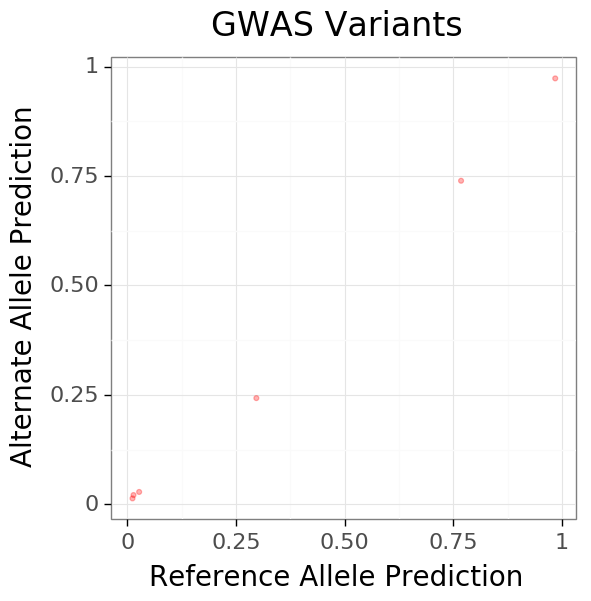

<ggplot: (8728128657619)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
1,chr7,23105295,23105296,rs10241208,G,C,0.954185,chr7,23104563,30,rs10488077,0.296960,0.242799,-0.054161
0,chr14,54901909,54901910,rs2149482,C,T,0.957318,chr14,54898613,26,rs8019824,0.768011,0.739182,-0.028828
2,chr7,23105676,23105677,rs10256996,T,G,0.870899,chr7,23104563,30,rs10488077,0.984665,0.972983,-0.011682
3,chr7,23114694,23114695,rs2068459,A,C,0.892711,chr7,23104563,30,rs10488077,0.027256,0.028473,0.001217
5,chr18,43093415,43093416,rs12456492,A,G,0.813684,chr18,43098270,61,rs4130047,0.011961,0.013755,0.001794
4,chr7,23115906,23115907,rs73272053,A,G,0.866225,chr7,23104563,30,rs10488077,0.014286,0.021404,0.007118


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
1,chr7,23105295,23105296,rs10241208,G,C,0.954185,chr7,23104563,30,rs10488077,0.296960,0.242799,-0.054161
0,chr14,54901909,54901910,rs2149482,C,T,0.957318,chr14,54898613,26,rs8019824,0.768011,0.739182,-0.028828
2,chr7,23105676,23105677,rs10256996,T,G,0.870899,chr7,23104563,30,rs10488077,0.984665,0.972983,-0.011682
3,chr7,23114694,23114695,rs2068459,A,C,0.892711,chr7,23104563,30,rs10488077,0.027256,0.028473,0.001217
5,chr18,43093415,43093416,rs12456492,A,G,0.813684,chr18,43098270,61,rs4130047,0.011961,0.013755,0.001794
4,chr7,23115906,23115907,rs73272053,A,G,0.866225,chr7,23104563,30,rs10488077,0.014286,0.021404,0.007118


SNPs NOT in Peaks:


(117, 13)

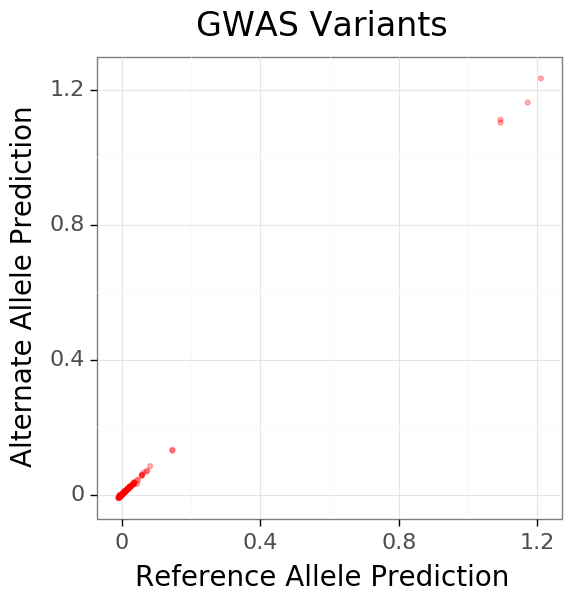

<ggplot: (8728128576716)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
39,chr14,54960385,54960386,rs6572994,C,G,0.854750,chr14,54898613,26,rs8019824,0.145695,0.130384,-0.015311
38,chr14,54960385,54960386,rs6572994,C,A,0.854750,chr14,54898613,26,rs8019824,0.145695,0.132999,-0.012696
100,chr7,23151805,23151806,rs2141307,G,C,0.808732,chr7,23104563,30,rs10488077,0.043479,0.031964,-0.011515
12,chr14,54903567,54903568,rs10136972,A,G,0.948553,chr14,54898613,26,rs8019824,1.171703,1.161734,-0.009969
75,chr7,23073884,23073885,rs6461685,C,T,0.904062,chr7,23104563,30,rs10488077,0.031785,0.028107,-0.003678
28,chr14,54948983,54948984,rs8005471,T,C,0.877873,chr14,54898613,26,rs8019824,0.045725,0.042175,-0.003550
31,chr14,54949104,54949105,rs8004402,C,T,0.877826,chr14,54898613,26,rs8019824,0.035318,0.032220,-0.003098
107,chr7,64293093,64293094,rs35919389,C,T,0.912771,chr7,64306602,85,rs10499772,0.073649,0.071134,-0.002515
10,chr18,5911303,5911304,rs182351901,A,C,1.000000,chr18,5911303,92,rs182351901,0.071402,0.068893,-0.002509
29,chr14,54949104,54949105,rs8004402,C,A,0.877826,chr14,54898613,26,rs8019824,0.035318,0.032879,-0.002439


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
92,chr7,23146348,23146349,rs4559148,G,A,0.802003,chr7,23104563,30,rs10488077,0.020715,0.023214,0.002499
102,chr14,103459924,103459925,rs117105921,G,A,0.889983,chr14,103544952,62,rs151247738,0.007628,0.010227,0.002599
66,chr14,55005673,55005674,rs2183085,A,C,0.802271,chr14,54898613,26,rs8019824,0.062849,0.065802,0.002953
74,chr7,23071112,23071113,rs7797870,C,G,0.881944,chr7,23104563,30,rs10488077,0.081395,0.084687,0.003292
103,chr14,103459924,103459925,rs117105921,G,T,0.889983,chr14,103544952,62,rs151247738,0.007628,0.012326,0.004698
54,chr14,54995292,54995293,rs10150110,G,C,0.830936,chr14,54898613,26,rs8019824,-0.006672,-0.000935,0.005737
55,chr14,54995292,54995293,rs10150110,G,T,0.830936,chr14,54898613,26,rs8019824,-0.006672,-0.000711,0.005961
14,chr14,54903622,54903623,rs10137071,C,T,0.948553,chr14,54898613,26,rs8019824,1.093374,1.102365,0.008991
13,chr14,54903622,54903623,rs10137071,C,G,0.948553,chr14,54898613,26,rs8019824,1.093374,1.110982,0.017608
4,chr14,103544952,103544953,rs151247738,A,G,1.000000,chr14,103544952,62,rs151247738,1.209815,1.233311,0.023496


FOLD:  7
All SNPs:


(5154, 13)

SNPs in Peaks:


(352, 13)

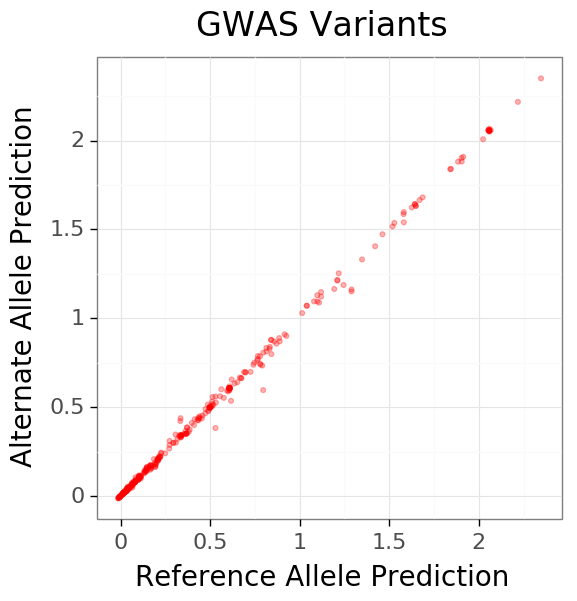

<ggplot: (8728129972516)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
337,chr17,46267724,46267725,rs2668719,C,A,0.820234,chr17,46105479,3,.,0.796470,0.596503,-0.199967
59,chr17,45722444,45722445,rs76667867,G,A,0.955856,chr17,46105479,3,.,0.529806,0.383266,-0.146540
332,chr17,46267622,46267623,rs2732650,C,G,0.955019,chr17,46105479,3,.,1.289334,1.151470,-0.137863
333,chr17,46267622,46267623,rs2732650,C,T,0.955019,chr17,46105479,3,.,1.289334,1.162686,-0.126648
336,chr17,46267697,46267698,rs2732651,C,T,0.815304,chr17,46105479,3,.,0.616591,0.536451,-0.080140
326,chr17,46267371,46267372,rs796772737,GGCTGGTGACCCT,G,0.820234,chr17,46105479,3,.,1.245023,1.187721,-0.057302
130,chr17,45896042,45896043,rs113347741,C,T,0.992408,chr17,46105479,3,.,0.791137,0.734688,-0.056448
115,chr17,45867740,45867741,rs62055475,T,C,0.992408,chr17,46105479,3,.,0.842123,0.799365,-0.042758
120,chr17,45894419,45894420,rs11575895,A,G,0.992408,chr17,46105479,3,.,0.781395,0.739860,-0.041535
27,chr17,45688986,45688987,rs17688205,G,A,0.984858,chr17,46105479,3,.,1.581414,1.540040,-0.041374


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
293,chr17,46260537,46260538,rs112305366,C,G,0.911962,chr17,46105479,3,.,1.218097,1.253631,0.035534
26,chr17,45688412,45688413,rs62055716,C,T,0.987388,chr17,46105479,3,.,0.620424,0.656421,0.035997
14,chr17,45586414,45586415,rs1724394,C,G,0.862248,chr17,46105479,3,.,0.273629,0.310996,0.037367
334,chr17,46267681,46267682,rs138875687,A,ACT,0.952398,chr17,46105479,3,.,0.841010,0.879043,0.038033
335,chr17,46267681,46267682,rs74597047,A,ACT,0.952398,chr17,46105479,3,.,0.841010,0.879043,0.038033
113,chr17,45852872,45852873,rs79589869,C,A,0.992408,chr17,46105479,3,.,0.562650,0.601553,0.038903
180,chr17,46004096,46004097,rs62064664,T,C,0.994936,chr17,46105479,3,.,0.306870,0.346894,0.040024
58,chr17,45722438,45722439,rs77819001,C,A,0.955856,chr17,46105479,3,.,0.513620,0.557771,0.044150
181,chr17,46004161,46004162,rs62064665,T,C,0.994936,chr17,46105479,3,.,0.333817,0.422692,0.088875
201,chr17,46044551,46044552,rs77768866,C,T,0.997473,chr17,46105479,3,.,0.335213,0.438945,0.103732


SNPs NOT in Peaks:


(4800, 13)

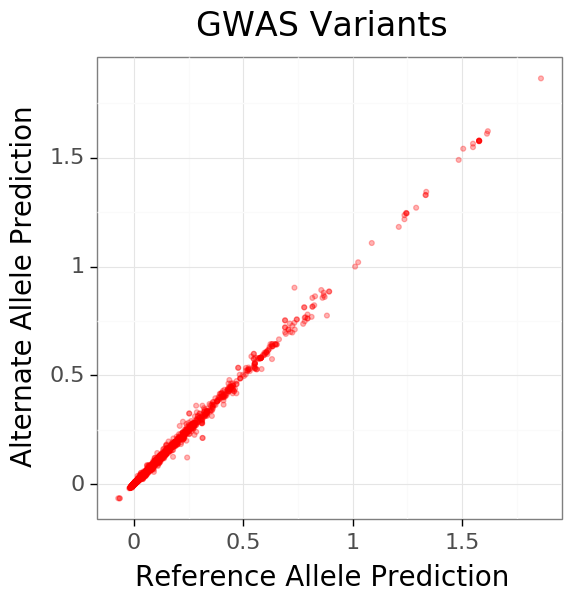

<ggplot: (8728128574016)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
738,chr17,45728224,45728225,rs62054388,C,T,0.887600,chr17,46105479,3,.,0.242951,0.121743,-0.121207
1052,chr17,45804424,45804425,rs17689378,C,T,0.982365,chr17,46105479,3,.,0.882259,0.774467,-0.107792
2854,chr17,46057618,46057619,rs62060768,G,A,1.000000,chr17,46105479,3,.,0.313454,0.211727,-0.101726
2855,chr17,46057618,46057619,rs62060768,G,A,0.801265,chr17,46704858,6,.,0.313454,0.211727,-0.101726
2941,chr17,46066885,46066886,rs62060799,G,T,0.994940,chr17,46105479,3,.,0.631060,0.574430,-0.056630
2206,chr17,45973484,45973485,rs62063776,A,G,0.987478,chr17,46105479,3,.,0.583500,0.528576,-0.054925
39,chr17,45495695,45495696,rs62065452,T,C,0.964781,chr17,46105479,3,.,0.178417,0.124964,-0.053453
1398,chr17,45870517,45870518,rs552290972,T,G,0.904491,chr17,46105479,3,.,0.468289,0.417050,-0.051239
839,chr17,45748202,45748203,rs62054436,C,T,0.885546,chr17,46105479,3,.,0.276419,0.226058,-0.050361
1257,chr17,45846853,45846854,rs12373124,T,C,0.992408,chr17,46105479,3,.,0.409710,0.365000,-0.044710


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2419,chr17,46012782,46012783,rs75666751,A,C,1.000000,chr17,46105479,3,.,0.476521,0.534393,0.057871
2420,chr17,46012782,46012783,rs75666751,A,C,0.801265,chr17,46704858,6,.,0.476521,0.534393,0.057871
923,chr17,45763315,45763316,rs62055890,C,T,0.992408,chr17,46105479,3,.,0.209077,0.267141,0.058064
1939,chr17,45947196,45947197,rs62062785,G,T,0.997467,chr17,46105479,3,.,0.690765,0.752471,0.061705
1941,chr17,45947196,45947197,rs62062785,G,T,0.803317,chr17,46704858,6,.,0.690765,0.752471,0.061705
3897,chr17,46173877,46173878,rs763997,C,T,0.815444,chr17,46105479,3,.,0.223744,0.286448,0.062704
3519,chr17,46118787,46118788,rs1468241,A,G,1.000000,chr17,46105479,3,.,0.252451,0.324347,0.071896
3520,chr17,46118787,46118788,rs1468241,A,G,0.801265,chr17,46704858,6,.,0.252451,0.324347,0.071896
2215,chr17,45975805,45975806,rs62063777,A,G,0.987478,chr17,46105479,3,.,0.284097,0.360134,0.076038
605,chr17,45707628,45707629,rs62056913,C,T,0.987388,chr17,46105479,3,.,0.733809,0.902648,0.168838


FOLD:  8
All SNPs:


(44, 13)

SNPs in Peaks:


(4, 13)

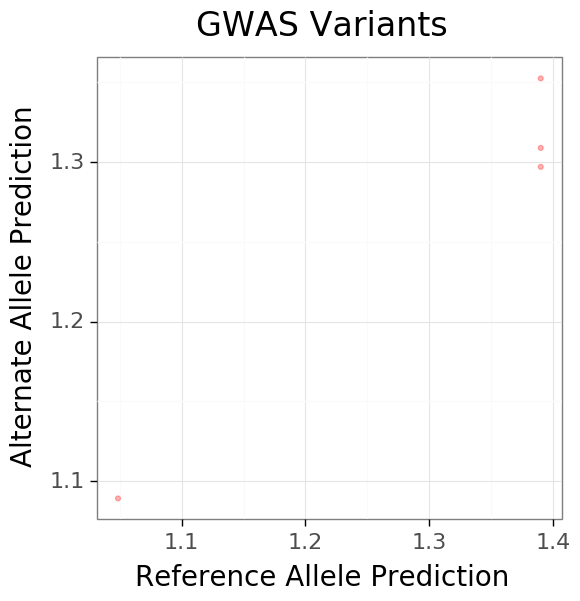

<ggplot: (8728128657423)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
3,chr12,122842051,122842052,rs10847864,G,T,0.815339,chr12,122838013,10,rs10847839,1.389823,1.297047,-0.092776
2,chr12,122842051,122842052,rs10847864,G,C,0.815339,chr12,122838013,10,rs10847839,1.389823,1.308947,-0.080877
1,chr12,122842051,122842052,rs10847864,G,A,0.815339,chr12,122838013,10,rs10847839,1.389823,1.352519,-0.037304
0,chr9,17579692,17579693,rs13294100,T,G,1.000000,chr9,17579692,39,rs13294100,1.048723,1.089258,0.040535


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
3,chr12,122842051,122842052,rs10847864,G,T,0.815339,chr12,122838013,10,rs10847839,1.389823,1.297047,-0.092776
2,chr12,122842051,122842052,rs10847864,G,C,0.815339,chr12,122838013,10,rs10847839,1.389823,1.308947,-0.080877
1,chr12,122842051,122842052,rs10847864,G,A,0.815339,chr12,122838013,10,rs10847839,1.389823,1.352519,-0.037304
0,chr9,17579692,17579693,rs13294100,T,G,1.000000,chr9,17579692,39,rs13294100,1.048723,1.089258,0.040535


SNPs NOT in Peaks:


(38, 13)

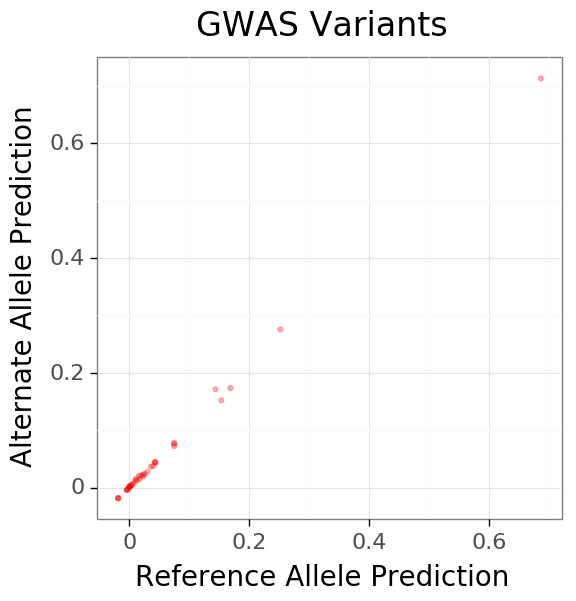

<ggplot: (-9223363308726059555)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
36,chr9,114810887,114810888,rs55914236,C,T,0.816031,chr9,114806968,96,rs55892528,0.023344,0.019572,-0.003772
0,chr12,33946256,33946257,rs183981418,A,T,1.000000,chr12,33946256,5,rs183981418,0.030363,0.027769,-0.002594
19,chr12,40158476,40158477,rs187827177,C,A,1.000000,chr12,40340400,1,rs34637584,0.074980,0.072487,-0.002494
18,chr12,39716210,39716211,rs548007023,A,C,1.000000,chr12,40340400,1,rs34637584,0.039969,0.037599,-0.002370
22,chr12,34487679,34487680,rs189930135,C,T,1.000000,chr12,34487072,8,rs180751015,0.017295,0.015306,-0.001989
32,chr12,38022088,38022089,rs564412193,G,A,0.888711,chr12,37566521,18,rs149617467,0.025957,0.024017,-0.001940
9,chr12,42141601,42141602,rs144755950,T,C,1.000000,chr12,42141601,23,rs144755950,0.153556,0.152114,-0.001442
33,chr12,32338739,32338740,rs140427697,A,G,0.940988,chr12,32389884,33,rs148707891,0.044078,0.042688,-0.001390
29,chr12,37990378,37990379,rs148806299,C,T,0.888711,chr12,37566521,18,rs149617467,0.012726,0.011985,-0.000742
35,chr9,114810887,114810888,rs55914236,C,A,0.816031,chr9,114806968,96,rs55892528,0.023344,0.022955,-0.000389


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
14,chr9,138121810,138121811,rs2278973,T,G,1.000000,chr9,138121810,48,rs2278973,0.042946,0.044734,0.001788
27,chr12,37733890,37733891,rs191016984,C,G,0.888711,chr12,37566521,18,rs149617467,0.000749,0.002991,0.002241
30,chr12,37999497,37999498,rs184239956,A,G,0.888711,chr12,37566521,18,rs149617467,0.009848,0.012633,0.002784
12,chr12,31348018,31348019,rs141917877,C,T,1.000000,chr12,31348018,46,rs141917877,0.074775,0.078057,0.003282
3,chr12,33075690,33075691,rs138895122,C,T,1.000000,chr12,33075690,16,rs138895122,0.011669,0.015594,0.003925
34,chr12,32358558,32358559,rs185414076,G,A,0.882000,chr12,32389884,33,rs148707891,0.016195,0.020481,0.004285
17,chr9,114806968,114806969,rs55892528,C,T,1.000000,chr9,114806968,96,rs55892528,0.168478,0.173367,0.004889
31,chr12,38008145,38008146,rs74772260,C,T,0.888711,chr12,37566521,18,rs149617467,0.251596,0.275531,0.023935
5,chr12,37566521,37566522,rs149617467,C,T,1.000000,chr12,37566521,18,rs149617467,0.685776,0.712896,0.027120
2,chr12,122838013,122838014,rs10847839,T,C,1.000000,chr12,122838013,10,rs10847839,0.143835,0.171282,0.027447


FOLD:  9
All SNPs:


(14, 13)

SNPs in Peaks:


(1, 13)

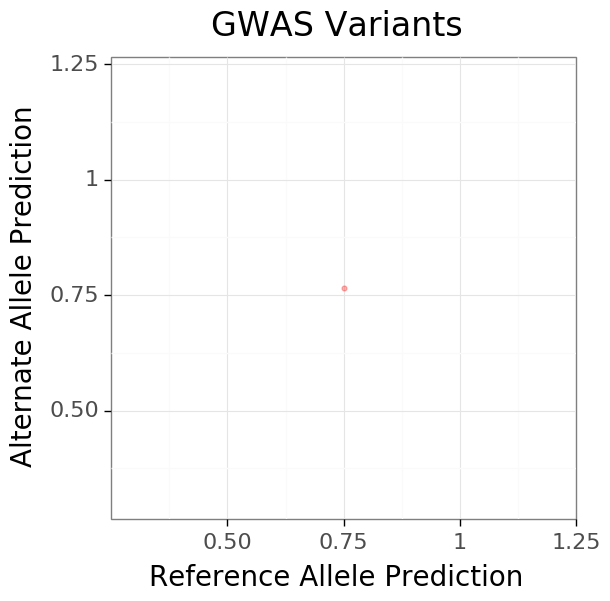

<ggplot: (8728113807771)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr10,119651405,119651406,rs144814361,C,T,1.0,chr10,119651405,15,rs144814361,0.750294,0.764554,0.01426


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr10,119651405,119651406,rs144814361,C,T,1.0,chr10,119651405,15,rs144814361,0.750294,0.764554,0.01426


SNPs NOT in Peaks:


(11, 13)

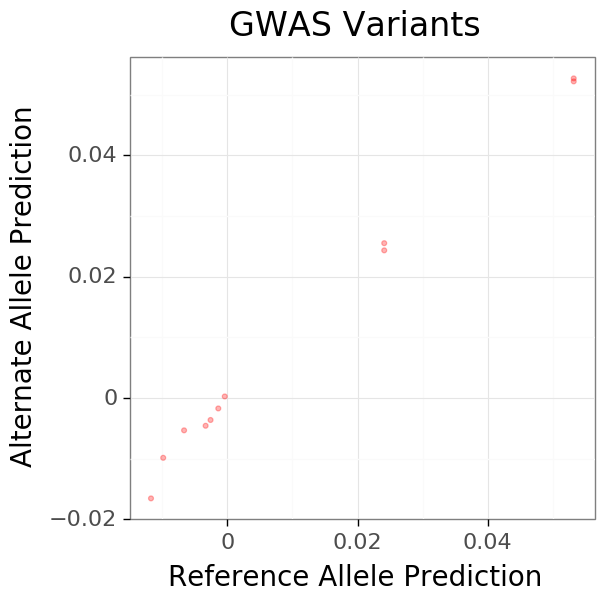

<ggplot: (-9223363308726033134)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
4,chr8,20030802,20030803,rs73208821,G,C,1.000000,chr8,20030802,55,rs73208821,-0.011743,-0.016567,-0.004824
10,chr10,76742310,76742311,rs17231856,A,C,0.843823,chr10,76731020,81,rs74860646,-0.003350,-0.004592,-0.001242
7,chr10,76731020,76731021,rs74860646,T,G,1.000000,chr10,76731020,81,rs74860646,-0.002593,-0.003638,-0.001045
0,chr10,2172585,2172586,rs75482696,T,A,1.000000,chr10,2172585,43,rs75482696,0.053213,0.052199,-0.001014
1,chr10,2172585,2172586,rs75482696,T,C,1.000000,chr10,2172585,43,rs75482696,0.053213,0.052693,-0.000520
9,chr8,20026413,20026414,rs73208819,T,C,0.833398,chr8,20030802,55,rs73208821,-0.001402,-0.001734,-0.000333
8,chr8,36255602,36255603,rs76104776,A,C,1.000000,chr8,36255602,101,rs76104776,-0.009868,-0.009875,-0.000007
2,chr8,34227886,34227887,rs201891502,C,CT,1.000000,chr8,34227886,51,rs1446651337,0.024094,0.024333,0.000239
6,chr8,109740385,109740386,rs72669174,T,A,1.000000,chr8,109740385,79,rs72669174,-0.000409,0.000243,0.000652
5,chr8,11854934,11854935,rs1293298,A,C,1.000000,chr8,11854934,75,rs1293298,-0.006660,-0.005346,0.001314


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
10,chr10,76742310,76742311,rs17231856,A,C,0.843823,chr10,76731020,81,rs74860646,-0.003350,-0.004592,-0.001242
7,chr10,76731020,76731021,rs74860646,T,G,1.000000,chr10,76731020,81,rs74860646,-0.002593,-0.003638,-0.001045
0,chr10,2172585,2172586,rs75482696,T,A,1.000000,chr10,2172585,43,rs75482696,0.053213,0.052199,-0.001014
1,chr10,2172585,2172586,rs75482696,T,C,1.000000,chr10,2172585,43,rs75482696,0.053213,0.052693,-0.000520
9,chr8,20026413,20026414,rs73208819,T,C,0.833398,chr8,20030802,55,rs73208821,-0.001402,-0.001734,-0.000333
8,chr8,36255602,36255603,rs76104776,A,C,1.000000,chr8,36255602,101,rs76104776,-0.009868,-0.009875,-0.000007
2,chr8,34227886,34227887,rs201891502,C,CT,1.000000,chr8,34227886,51,rs1446651337,0.024094,0.024333,0.000239
6,chr8,109740385,109740386,rs72669174,T,A,1.000000,chr8,109740385,79,rs72669174,-0.000409,0.000243,0.000652
5,chr8,11854934,11854935,rs1293298,A,C,1.000000,chr8,11854934,75,rs1293298,-0.006660,-0.005346,0.001314
3,chr8,34227886,34227887,rs1446651337,C,G,1.000000,chr8,34227886,51,rs1446651337,0.024094,0.025518,0.001424


In [10]:
get_results_all_folds('PD_CTRL_SUNI')

TASK:  PD_GBA1_SUNI
FOLD:  0
All SNPs:


(35, 13)

SNPs in Peaks:


(3, 13)

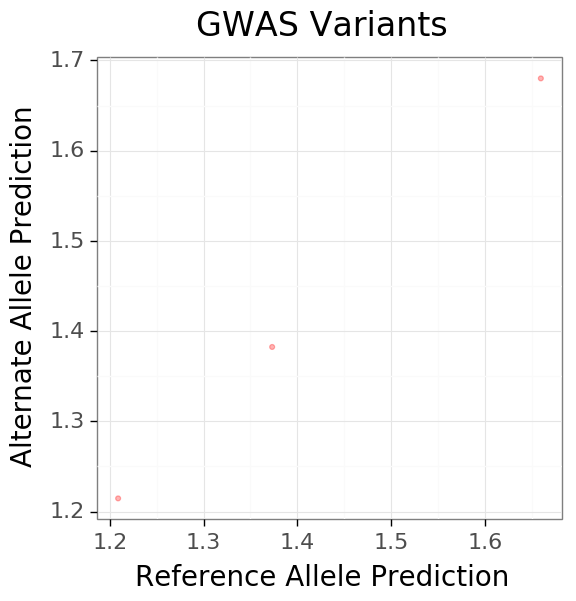

<ggplot: (-9223363308725779070)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
1,chr1,205750404,205750405,rs823114,G,A,0.953762,chr1,205770138,21,rs708723,1.208943,1.214627,0.005684
2,chr1,8409729,8409730,rs2661868,C,T,0.984181,chr1,8390388,77,rs2708628,1.373180,1.382457,0.009277
0,chr1,155135691,155135692,rs12726330,G,C,1.000000,chr1,155135691,9,rs12726330,1.659680,1.680119,0.020440


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
1,chr1,205750404,205750405,rs823114,G,A,0.953762,chr1,205770138,21,rs708723,1.208943,1.214627,0.005684
2,chr1,8409729,8409730,rs2661868,C,T,0.984181,chr1,8390388,77,rs2708628,1.373180,1.382457,0.009277
0,chr1,155135691,155135692,rs12726330,G,C,1.000000,chr1,155135691,9,rs12726330,1.659680,1.680119,0.020440


SNPs NOT in Peaks:


(30, 13)

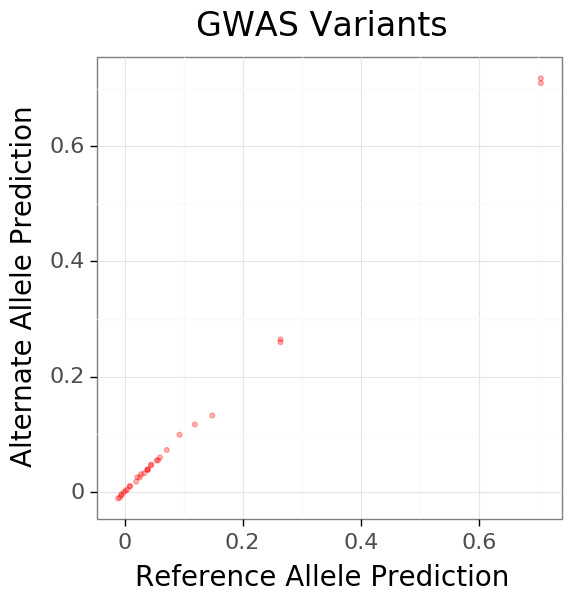

<ggplot: (8728129085090)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
14,chr1,155235587,155235588,rs12752133,C,T,0.812944,chr1,155135691,9,rs12726330,0.148566,0.132790,-0.015776
21,chr1,8380583,8380584,rs2636314,G,A,0.975367,chr1,8390388,77,rs2708628,0.264144,0.259999,-0.004145
26,chr1,8406690,8406691,rs2748456,C,T,0.988415,chr1,8390388,77,rs2708628,-0.008142,-0.010007,-0.001865
28,chr1,8437498,8437499,rs2784739,T,G,0.892586,chr1,8390388,77,rs2708628,0.118946,0.117165,-0.001781
20,chr1,119089761,119089762,rs72707308,C,T,1.000000,chr1,119094055,53,rs76695140,0.019541,0.017801,-0.001740
4,chr1,18814620,18814621,rs191668177,C,G,1.000000,chr1,18814620,60,rs191668177,0.056626,0.055196,-0.001430
10,chr1,155015779,155015780,rs71628639,C,T,0.885591,chr1,155135691,9,rs12726330,0.039293,0.038340,-0.000953
11,chr1,155143675,155143676,rs12742181,C,T,1.000000,chr1,155135691,9,rs12726330,0.033148,0.032620,-0.000528
27,chr1,8416395,8416396,rs2708625,T,C,0.878326,chr1,8390388,77,rs2708628,0.004372,0.003873,-0.000499
25,chr1,8406157,8406158,rs2784738,G,C,0.988433,chr1,8390388,77,rs2708628,-0.005373,-0.005756,-0.000383


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
24,chr1,8406157,8406158,rs2784738,G,A,0.988433,chr1,8390388,77,rs2708628,-0.005373,-0.004153,0.001221
2,chr1,183922245,183922246,rs113076859,C,T,1.000000,chr1,183922245,50,rs113076859,0.071523,0.072823,0.001300
17,chr1,205751355,205751356,rs823116,G,A,0.959419,chr1,205770138,21,rs708723,0.008601,0.010066,0.001466
19,chr1,205754444,205754445,rs823118,C,T,0.972244,chr1,205770138,21,rs708723,0.044915,0.046817,0.001902
18,chr1,205754444,205754445,rs823118,C,A,0.972244,chr1,205770138,21,rs708723,0.044915,0.046983,0.002068
13,chr1,155162560,155162561,rs35749011,G,A,0.962770,chr1,155135691,9,rs12726330,0.028183,0.030918,0.002735
6,chr1,8390388,8390389,rs2708628,T,C,1.000000,chr1,8390388,77,rs2708628,0.021696,0.025699,0.004003
7,chr1,246782994,246782995,rs149745071,C,A,1.000000,chr1,246782994,93,rs149745071,0.705244,0.709483,0.004239
3,chr1,119094055,119094056,rs76695140,A,G,1.000000,chr1,119094055,53,rs76695140,0.092977,0.099401,0.006424
8,chr1,246782994,246782995,rs149745071,C,T,1.000000,chr1,246782994,93,rs149745071,0.705244,0.717687,0.012443


FOLD:  1
All SNPs:


(58, 13)

SNPs NOT in Peaks:


(57, 13)

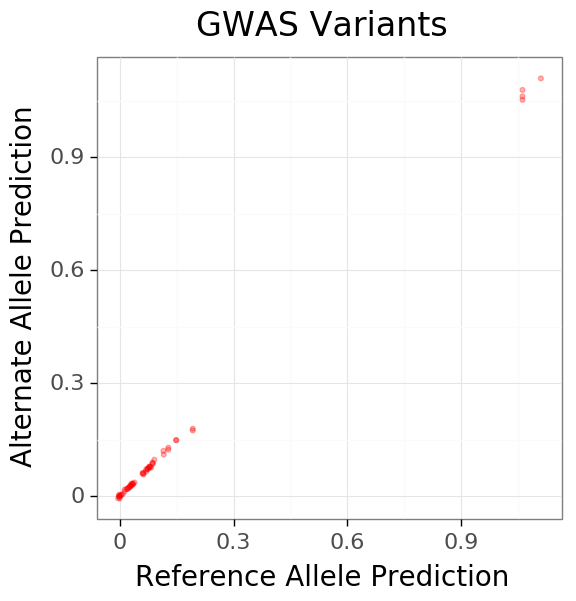

<ggplot: (-9223363308725803797)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
30,chr2,134782976,134782977,rs7599054,A,G,0.976667,chr2,134825938,37,rs6760237,0.192554,0.174856,-0.017698
31,chr2,134782976,134782977,rs7599054,A,T,0.976667,chr2,134825938,37,rs6760237,0.192554,0.179621,-0.012933
46,chr19,2813855,2813856,rs1478922243,C,T,0.879171,chr19,2791655,47,rs59303624,1.061332,1.052314,-0.009018
28,chr2,134779549,134779550,rs6741007,T,G,0.977944,chr2,134825938,37,rs6760237,0.082644,0.076560,-0.006084
20,chr2,101982478,101982479,rs13006661,C,T,0.817247,chr2,101988187,29,rs12467316,-0.000070,-0.005219,-0.005149
34,chr2,134818984,134818985,rs6753334,A,G,0.980527,chr2,134825938,37,rs6760237,0.116208,0.111173,-0.005035
55,chr2,153135907,153135908,rs56042431,T,G,0.860513,chr2,153110678,82,rs1347394,0.062573,0.058205,-0.004368
6,chr19,2791655,2791656,rs59303624,G,T,1.000000,chr19,2791655,47,rs59303624,0.128077,0.123922,-0.004155
35,chr2,134823942,134823943,rs4953936,C,T,0.992196,chr2,134825938,37,rs6760237,0.034917,0.031616,-0.003301
12,chr2,168299490,168299491,rs4667572,G,A,0.823437,chr2,168299085,13,rs13016703,0.069589,0.066464,-0.003126


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
13,chr2,168299490,168299491,rs4667572,G,T,0.823437,chr2,168299085,13,rs13016703,0.069589,0.071758,0.002168
3,chr2,134825938,134825939,rs6760237,A,T,1.000000,chr2,134825938,37,rs6760237,-0.001226,0.001214,0.002439
1,chr2,134825938,134825939,rs6760237,A,C,1.000000,chr2,134825938,37,rs6760237,-0.001226,0.001346,0.002571
51,chr2,153112123,153112124,rs16832124,A,G,0.988122,chr2,153110678,82,rs1347394,0.031099,0.034290,0.003191
23,chr2,101989388,101989389,rs201052897,A,T,0.919644,chr2,101988187,29,rs12467316,0.086673,0.090319,0.003646
7,chr2,126517671,126517672,rs77643088,G,C,1.000000,chr2,126517671,63,rs77643088,0.013151,0.018358,0.005207
49,chr19,2813959,2813960,rs113301220,A,G,0.873043,chr19,2791655,47,rs59303624,0.115168,0.120882,0.005714
2,chr2,134825938,134825939,rs6760237,A,G,1.000000,chr2,134825938,37,rs6760237,-0.001226,0.004655,0.005880
44,chr19,2790688,2790689,rs8106185,C,T,0.955223,chr19,2791655,47,rs59303624,0.091300,0.097274,0.005974
47,chr19,2813855,2813856,rs146390273,C,CCT,0.879171,chr19,2791655,47,rs59303624,1.061332,1.078579,0.017247


FOLD:  2
All SNPs:


(70, 13)

SNPs in Peaks:


(0, 13)

AttributeError: 'list' object has no attribute 'keys'

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta


SNPs NOT in Peaks:


(68, 13)

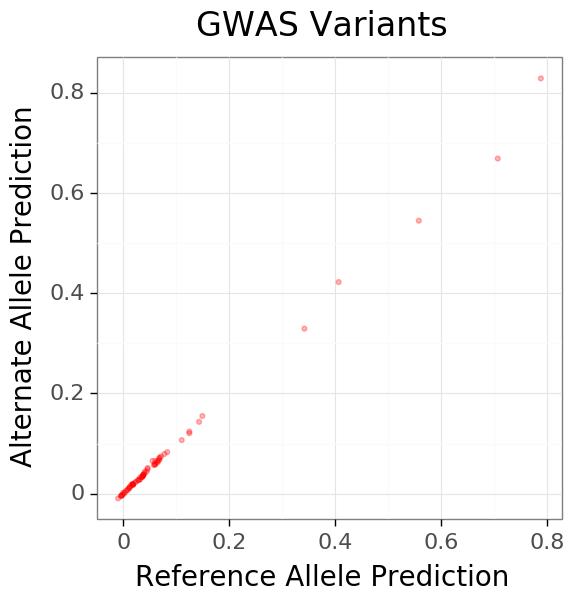

<ggplot: (-9223363308726007643)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
11,chr3,183010393,183010394,rs4074310,T,G,1.000000,chr3,183010401,14,.,0.706987,0.668511,-0.038476
0,chr3,183010401,183010402,rs5854965,CTAGG,C,1.000000,chr3,183010401,14,.,0.557854,0.544531,-0.013323
6,chr3,18181950,18181951,rs13078687,G,A,1.000000,chr3,18181950,87,rs13078687,0.341905,0.329103,-0.012802
54,chr3,18235996,18235997,rs4073221,T,C,0.832098,chr3,18181950,87,rs13078687,0.124661,0.120423,-0.004238
15,chr3,146345697,146345698,rs116468365,G,A,0.947179,chr3,146323490,38,rs192689438,0.110255,0.106670,-0.003585
37,chr3,18177545,18177546,rs4688901,G,A,0.993187,chr3,18181950,87,rs13078687,0.031927,0.028426,-0.003501
31,chr3,18175216,18175217,rs1022089937,C,T,1.000000,chr3,18181950,87,rs13078687,0.064286,0.061754,-0.002532
9,chr3,151435149,151435150,rs535064165,G,GTACTT,1.000000,chr3,151435149,97,rs10935849,0.059765,0.057269,-0.002496
1,chr3,145333493,145333494,rs181870458,G,A,1.000000,chr3,145333493,35,rs181870458,0.029929,0.027479,-0.002450
23,chr3,18165914,18165915,rs35098540,A,G,0.811015,chr3,18181950,87,rs13078687,0.035662,0.033370,-0.002291


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
7,chr3,18704008,18704009,rs13095117,A,G,1.000000,chr3,18704008,94,rs13095117,0.068649,0.071687,0.003038
21,chr3,18163160,18163161,rs35228011,G,A,0.996583,chr3,18181950,87,rs13078687,0.071210,0.074343,0.003134
51,chr3,18217730,18217731,rs13071572,G,A,0.913115,chr3,18181950,87,rs13078687,0.045926,0.049095,0.003168
65,chr3,18240967,18240968,rs35274326,C,G,0.835022,chr3,18181950,87,rs13078687,0.040749,0.044334,0.003585
33,chr3,18175539,18175540,rs67392505,G,C,1.000000,chr3,18181950,87,rs13078687,0.060076,0.065209,0.005132
52,chr3,18217730,18217731,rs13071572,G,T,0.913115,chr3,18181950,87,rs13078687,0.045926,0.051148,0.005221
18,chr3,19400018,19400019,rs187635580,G,A,0.874825,chr3,19609963,86,rs146933024,0.149279,0.154917,0.005638
14,chr3,4544215,4544216,rs304007,G,T,0.806552,chr3,4540543,36,rs304048,0.055137,0.065329,0.010192
41,chr3,18189881,18189882,rs35407649,C,A,0.941916,chr3,18181950,87,rs13078687,0.406577,0.422057,0.015480
4,chr20,57685746,57685747,rs145427294,G,C,1.000000,chr20,57685746,68,rs145427294,0.788277,0.828412,0.040135


FOLD:  3
All SNPs:


(25, 13)

SNPs NOT in Peaks:


(24, 13)

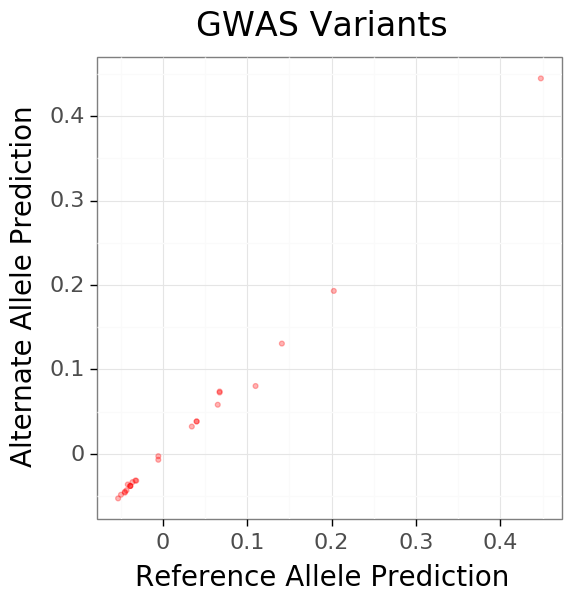

<ggplot: (8728129097974)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
14,chr6,111919129,111919130,rs9374302,G,A,0.925594,chr6,111921050,88,rs943437,0.109842,0.080313,-0.029530
19,chr6,111936824,111936825,rs626007,A,G,0.917903,chr6,111921050,88,rs943437,0.141016,0.130582,-0.010434
5,chr6,111921050,111921051,rs943437,A,G,1.000000,chr6,111921050,88,rs943437,0.202532,0.192943,-0.009589
23,chr6,111940286,111940287,rs481262,T,C,0.847191,chr6,111921050,88,rs943437,0.065056,0.058130,-0.006926
7,chr22,42483761,42483762,rs370511811,A,G,0.827822,chr22,42479513,64,rs11705074,0.447825,0.444690,-0.003135
22,chr6,111940182,111940183,rs671271,G,A,0.876892,chr6,111921050,88,rs943437,0.034325,0.032309,-0.002017
1,chr22,42479513,42479514,rs11705074,T,G,1.000000,chr22,42479513,64,rs11705074,-0.005366,-0.007063,-0.001697
21,chr6,111937536,111937537,rs10687473,A,AAAAT,0.854650,chr6,111921050,88,rs943437,0.040024,0.038357,-0.001667
20,chr6,111937536,111937537,rs147859592,A,AAAAT,0.854650,chr6,111921050,88,rs943437,0.040024,0.038357,-0.001667
13,chr6,111913118,111913119,rs896454003,C,T,0.926443,chr6,111921050,88,rs943437,-0.044993,-0.046009,-0.001015


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
8,chr22,42485737,42485738,rs140570025,T,TAC,0.872864,chr22,42479513,64,rs11705074,-0.038571,-0.038147,0.000424
10,chr22,42485737,42485738,rs144088132,T,TAC,0.872864,chr22,42479513,64,rs11705074,-0.038571,-0.038147,0.000424
9,chr22,42485737,42485738,rs1383691167,T,C,0.872864,chr22,42479513,64,rs11705074,-0.038571,-0.038052,0.000519
2,chr13,90579739,90579740,rs140851527,A,G,1.000000,chr13,90579739,74,rs140851527,-0.032490,-0.031652,0.000838
17,chr6,111928907,111928908,rs9400515,A,C,0.844289,chr6,111921050,88,rs943437,-0.049612,-0.048478,0.001134
3,chr6,71747595,71747596,rs9446462,C,A,1.000000,chr6,71747595,78,rs9446462,-0.035992,-0.033527,0.002465
4,chr13,111395285,111395286,rs187520595,C,T,1.000000,chr13,111395285,84,rs187520595,-0.005358,-0.002789,0.002569
11,chr6,111908723,111908724,rs9481202,A,G,0.881559,chr6,111921050,88,rs943437,-0.041535,-0.036293,0.005242
16,chr6,111922088,111922089,rs997368,A,G,0.852686,chr6,111921050,88,rs943437,0.067282,0.072619,0.005338
15,chr6,111922088,111922089,rs997368,A,C,0.852686,chr6,111921050,88,rs943437,0.067282,0.073817,0.006535


FOLD:  4
All SNPs:


(15, 13)

SNPs NOT in Peaks:


(14, 13)

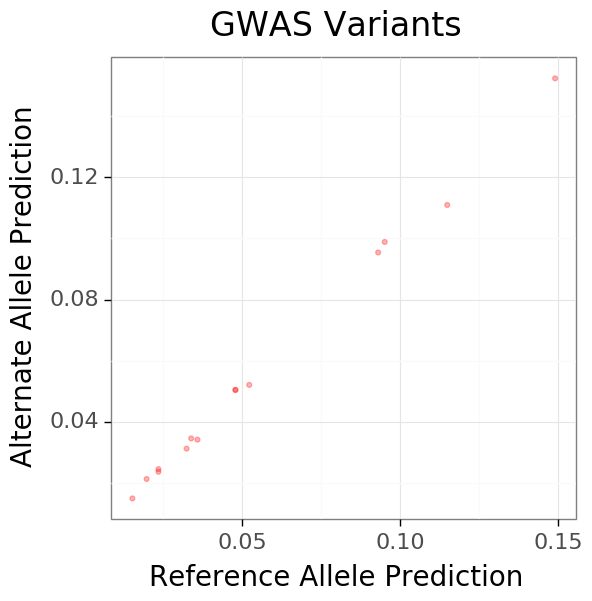

<ggplot: (8728128768113)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
13,chr5,174529858,174529859,rs11742484,A,T,0.870984,chr5,174553576,89,rs11743380,0.114973,0.110944,-0.004029
12,chr5,3504257,3504258,rs540581141,C,T,1.000000,chr5,2531144,67,rs149679249,0.035887,0.034119,-0.001768
4,chr5,60839026,60839027,rs201395352,A,AT,1.000000,chr5,60839026,54,.,0.032443,0.031176,-0.001267
11,chr16,24743404,24743405,rs144948736,C,T,0.833000,chr16,24655763,27,rs146398451,0.015282,0.014888,-0.000394
10,chr16,24693600,24693601,rs572537035,CAAATA,C,0.809640,chr16,24655763,27,rs146398451,0.052282,0.052040,-0.000243
0,chr16,24655763,24655764,rs146398451,C,T,1.000000,chr16,24655763,27,rs146398451,0.023534,0.023603,0.000069
7,chr5,84305922,84305923,rs147108359,G,A,1.000000,chr5,84305922,95,rs147108359,0.033903,0.034530,0.000626
1,chr16,24655763,24655764,rs776288687,C,CT,1.000000,chr16,24655763,27,rs146398451,0.023534,0.024471,0.000937
9,chr16,58770912,58770913,rs145178507,C,T,0.833167,chr16,58553768,24,rs200564078,0.019790,0.021228,0.001438
8,chr16,58539193,58539194,rs76881424,C,T,0.833167,chr16,58553768,24,rs200564078,0.093095,0.095407,0.002312


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
10,chr16,24693600,24693601,rs572537035,CAAATA,C,0.809640,chr16,24655763,27,rs146398451,0.052282,0.052040,-0.000243
0,chr16,24655763,24655764,rs146398451,C,T,1.000000,chr16,24655763,27,rs146398451,0.023534,0.023603,0.000069
7,chr5,84305922,84305923,rs147108359,G,A,1.000000,chr5,84305922,95,rs147108359,0.033903,0.034530,0.000626
1,chr16,24655763,24655764,rs776288687,C,CT,1.000000,chr16,24655763,27,rs146398451,0.023534,0.024471,0.000937
9,chr16,58770912,58770913,rs145178507,C,T,0.833167,chr16,58553768,24,rs200564078,0.019790,0.021228,0.001438
8,chr16,58539193,58539194,rs76881424,C,T,0.833167,chr16,58553768,24,rs200564078,0.093095,0.095407,0.002312
3,chr5,124774580,124774581,rs6875262,T,C,1.000000,chr5,124774580,34,rs6875262,0.047910,0.050347,0.002437
2,chr5,124774580,124774581,rs6875262,T,A,1.000000,chr5,124774580,34,rs6875262,0.047910,0.050449,0.002539
5,chr5,2531144,2531145,rs149679249,T,C,1.000000,chr5,2531144,67,rs149679249,0.149123,0.152389,0.003266
6,chr5,174553576,174553577,rs11743380,C,T,1.000000,chr5,174553576,89,rs11743380,0.095182,0.098845,0.003663


FOLD:  5
All SNPs:


(46, 13)

SNPs in Peaks:


(1, 13)

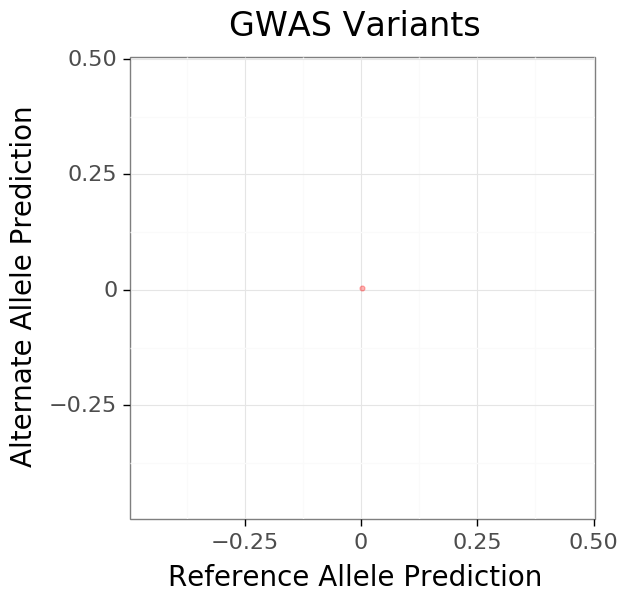

<ggplot: (8728129115768)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr4,90290373,90290374,rs75541595,G,A,1.0,chr4,90290373,20,rs75541595,0.002851,0.003359,0.000508


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr4,90290373,90290374,rs75541595,G,A,1.0,chr4,90290373,20,rs75541595,0.002851,0.003359,0.000508


SNPs NOT in Peaks:


(43, 13)

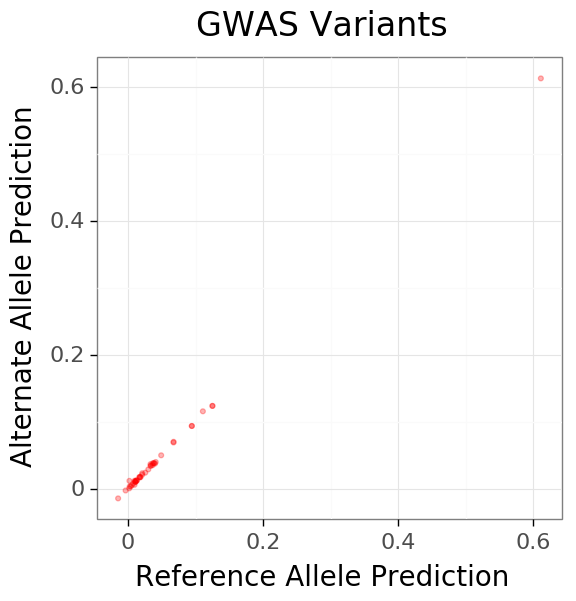

<ggplot: (-9223363308725473813)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
20,chr21,44413639,44413640,rs142333555,C,T,0.966473,chr21,44406603,28,rs56379273,0.009599,0.006632,-0.002966
3,chr21,44406603,44406604,rs759304969,GTCT,G,1.000000,chr21,44406603,28,rs56379273,0.040013,0.038301,-0.001712
39,chr4,178968614,178968615,rs78326713,T,C,0.940563,chr4,178957718,70,rs76856961,0.025579,0.024728,-0.000852
40,chr4,178971133,178971134,rs74855614,A,G,0.966952,chr4,178957718,70,rs76856961,0.124916,0.124333,-0.000583
41,chr4,178971133,178971134,rs74855614,A,T,0.966952,chr4,178957718,70,rs76856961,0.124916,0.124342,-0.000574
10,chr4,113891618,113891619,rs140020117,G,A,1.000000,chr4,113891618,80,rs140020117,0.036403,0.035855,-0.000547
26,chr4,178948839,178948840,rs2035086,T,C,0.822582,chr4,178957718,70,rs76856961,0.001856,0.001334,-0.000522
22,chr4,15748080,15748081,rs10516292,C,T,0.993433,chr4,15749694,32,.,0.030041,0.029621,-0.000420
15,chr4,182221693,182221694,rs896026,C,T,0.992371,chr4,182220835,25,rs2044779,0.018599,0.018193,-0.000406
37,chr4,178965762,178965763,rs113530632,T,A,0.986811,chr4,178957718,70,rs76856961,0.040965,0.040630,-0.000335


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
8,chr4,188259868,188259869,rs189149546,C,G,1.000000,chr4,188259868,49,rs189149546,-0.003567,-0.001861,0.001706
1,chr4,182220835,182220836,rs2044779,T,A,1.000000,chr4,182220835,25,rs2044779,0.610932,0.613031,0.002099
11,chr4,113891618,113891619,rs140020117,G,C,1.000000,chr4,113891618,80,rs140020117,0.036403,0.038642,0.002240
23,chr4,15756612,15756613,rs6834477,T,A,0.806952,chr4,15749694,32,.,0.067377,0.069780,0.002403
28,chr4,178959592,178959593,rs111985289,C,G,0.993426,chr4,178957718,70,rs76856961,0.020997,0.023874,0.002877
36,chr4,178965290,178965291,rs75250430,C,T,0.986811,chr4,178957718,70,rs76856961,0.009727,0.012711,0.002984
24,chr4,15756612,15756613,rs6834477,T,C,0.806952,chr4,15749694,32,.,0.067377,0.070778,0.003401
5,chr4,102267552,102267553,rs13107325,C,T,1.000000,chr4,102267552,31,rs13107325,0.033222,0.037401,0.004179
34,chr4,178963851,178963852,rs80116969,T,C,0.933991,chr4,178957718,70,rs76856961,0.110765,0.116296,0.005531
13,chr4,90229014,90229015,rs142404622,T,C,0.939527,chr4,90290373,20,rs75541595,0.002042,0.012508,0.010466


FOLD:  6
All SNPs:


(125, 13)

SNPs in Peaks:


(6, 13)

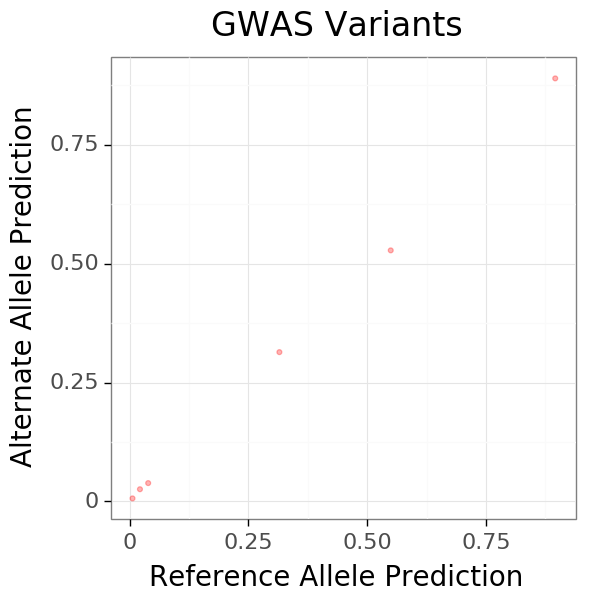

<ggplot: (8728129176605)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr14,54901909,54901910,rs2149482,C,T,0.957318,chr14,54898613,26,rs8019824,0.549354,0.527802,-0.021552
2,chr7,23105676,23105677,rs10256996,T,G,0.870899,chr7,23104563,30,rs10488077,0.895526,0.889302,-0.006224
1,chr7,23105295,23105296,rs10241208,G,C,0.954185,chr7,23104563,30,rs10488077,0.315038,0.313880,-0.001158
5,chr18,43093415,43093416,rs12456492,A,G,0.813684,chr18,43098270,61,rs4130047,0.038881,0.038593,-0.000288
3,chr7,23114694,23114695,rs2068459,A,C,0.892711,chr7,23104563,30,rs10488077,0.005893,0.006436,0.000543
4,chr7,23115906,23115907,rs73272053,A,G,0.866225,chr7,23104563,30,rs10488077,0.021590,0.025697,0.004107


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr14,54901909,54901910,rs2149482,C,T,0.957318,chr14,54898613,26,rs8019824,0.549354,0.527802,-0.021552
2,chr7,23105676,23105677,rs10256996,T,G,0.870899,chr7,23104563,30,rs10488077,0.895526,0.889302,-0.006224
1,chr7,23105295,23105296,rs10241208,G,C,0.954185,chr7,23104563,30,rs10488077,0.315038,0.313880,-0.001158
5,chr18,43093415,43093416,rs12456492,A,G,0.813684,chr18,43098270,61,rs4130047,0.038881,0.038593,-0.000288
3,chr7,23114694,23114695,rs2068459,A,C,0.892711,chr7,23104563,30,rs10488077,0.005893,0.006436,0.000543
4,chr7,23115906,23115907,rs73272053,A,G,0.866225,chr7,23104563,30,rs10488077,0.021590,0.025697,0.004107


SNPs NOT in Peaks:


(117, 13)

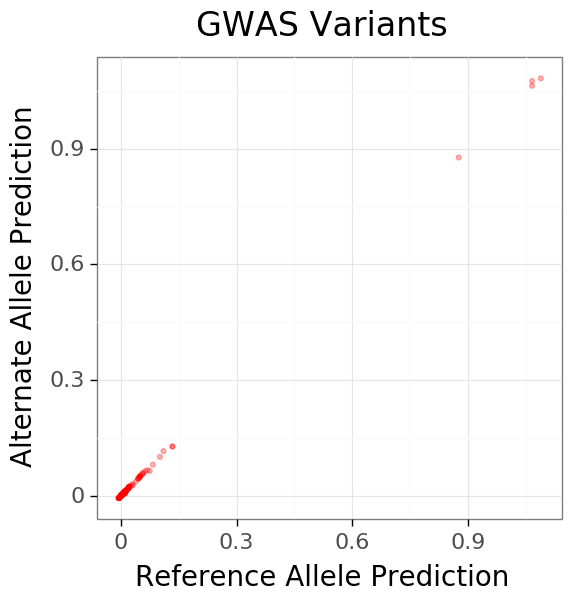

<ggplot: (8728129370155)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
91,chr7,23136327,23136328,rs6953996,A,G,0.896863,chr7,23104563,30,rs10488077,0.074692,0.064679,-0.010013
12,chr14,54903567,54903568,rs10136972,A,G,0.948553,chr14,54898613,26,rs8019824,1.088903,1.082585,-0.006319
39,chr14,54960385,54960386,rs6572994,C,G,0.854750,chr14,54898613,26,rs8019824,0.133577,0.127816,-0.005760
38,chr14,54960385,54960386,rs6572994,C,A,0.854750,chr14,54898613,26,rs8019824,0.133577,0.128034,-0.005542
55,chr14,54995292,54995293,rs10150110,G,T,0.830936,chr14,54898613,26,rs8019824,0.011017,0.006487,-0.004530
54,chr14,54995292,54995293,rs10150110,G,C,0.830936,chr14,54898613,26,rs8019824,0.011017,0.006627,-0.004389
8,chr7,66544864,66544865,rs76949143,T,A,1.000000,chr7,66544864,73,rs76949143,0.030815,0.026985,-0.003830
14,chr14,54903622,54903623,rs10137071,C,T,0.948553,chr14,54898613,26,rs8019824,1.066199,1.063367,-0.002832
111,chr14,87999515,87999516,rs774185270,C,CAT,0.914901,chr14,88006268,91,rs8005172,0.009461,0.007001,-0.002460
51,chr14,54986751,54986752,rs8019220,C,T,0.836018,chr14,54898613,26,rs8019824,0.008716,0.006398,-0.002318


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
65,chr14,55005265,55005266,rs2840268,C,T,0.802271,chr14,54898613,26,rs8019824,0.049355,0.051445,0.002090
3,chr18,43098270,43098271,rs4130047,T,C,1.000000,chr18,43098270,61,rs4130047,0.022650,0.024801,0.002151
67,chr14,55007182,55007183,rs9323275,T,A,0.816527,chr14,54898613,26,rs8019824,0.009789,0.011949,0.002159
103,chr14,103459924,103459925,rs117105921,G,T,0.889983,chr14,103544952,62,rs151247738,0.009410,0.011805,0.002395
87,chr7,23114316,23114317,rs764534,C,T,0.888467,chr7,23104563,30,rs10488077,0.020696,0.023101,0.002405
112,chr14,87999515,87999516,rs35393842,CAT,C,0.914901,chr14,88006268,91,rs8005172,0.007001,0.009461,0.002460
107,chr7,64293093,64293094,rs35919389,C,T,0.912771,chr7,64306602,85,rs10499772,0.055555,0.058172,0.002617
86,chr7,23114316,23114317,rs764534,C,G,0.888467,chr7,23104563,30,rs10488077,0.020696,0.023337,0.002641
74,chr7,23071112,23071113,rs7797870,C,G,0.881944,chr7,23104563,30,rs10488077,0.110470,0.116145,0.005675
13,chr14,54903622,54903623,rs10137071,C,G,0.948553,chr14,54898613,26,rs8019824,1.066199,1.075742,0.009543


FOLD:  7
All SNPs:


(5154, 13)

SNPs in Peaks:


(352, 13)

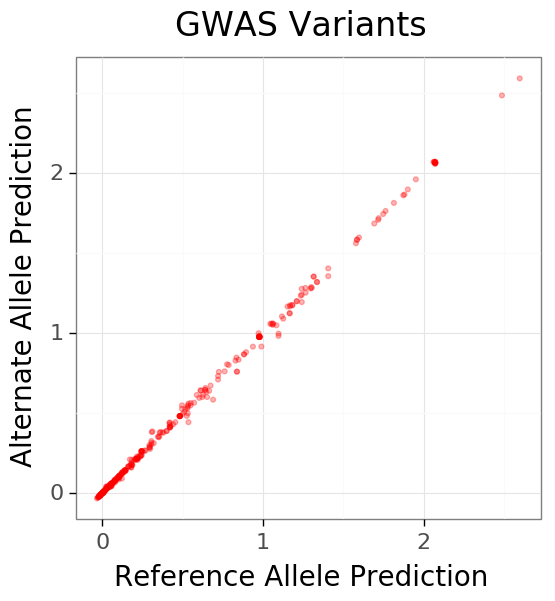

<ggplot: (8728129342079)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
333,chr17,46267622,46267623,rs2732650,C,T,0.955019,chr17,46105479,3,.,1.096961,0.983536,-0.113424
337,chr17,46267724,46267725,rs2668719,C,A,0.820234,chr17,46105479,3,.,0.689519,0.584726,-0.104793
332,chr17,46267622,46267623,rs2732650,C,G,0.955019,chr17,46105479,3,.,1.096961,0.998090,-0.098871
59,chr17,45722444,45722445,rs76667867,G,A,0.955856,chr17,46105479,3,.,0.536061,0.443835,-0.092226
316,chr17,46266856,46266857,rs2458214,C,G,0.862200,chr17,46105479,3,.,0.837635,0.760117,-0.077519
317,chr17,46266856,46266857,rs2458214,C,G,0.800344,chr17,46704858,6,.,0.837635,0.760117,-0.077519
115,chr17,45867740,45867741,rs62055475,T,C,0.992408,chr17,46105479,3,.,0.989835,0.917102,-0.072734
336,chr17,46267697,46267698,rs2732651,C,T,0.815304,chr17,46105479,3,.,0.651984,0.601355,-0.050629
27,chr17,45688986,45688987,rs17688205,G,A,0.984858,chr17,46105479,3,.,1.406033,1.357287,-0.048746
130,chr17,45896042,45896043,rs113347741,C,T,0.992408,chr17,46105479,3,.,1.241630,1.195161,-0.046469


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
334,chr17,46267681,46267682,rs138875687,A,ACT,0.952398,chr17,46105479,3,.,0.612056,0.642676,0.030620
133,chr17,45896286,45896287,rs62056780,C,T,0.992408,chr17,46105479,3,.,0.495584,0.528441,0.032856
26,chr17,45688412,45688413,rs62055716,C,T,0.987388,chr17,46105479,3,.,0.725429,0.758643,0.033215
2,chr17,45490914,45490915,rs576687444,G,A,0.817779,chr17,46105479,3,.,1.240767,1.278155,0.037387
1,chr17,45490912,45490913,rs371185851,T,TGAG,0.817779,chr17,46105479,3,.,1.315525,1.354553,0.039028
0,chr17,45490912,45490913,rs371185851,T,TGA,0.817779,chr17,46105479,3,.,1.315525,1.354553,0.039028
165,chr17,46002201,46002202,rs17573447,C,T,0.975240,chr17,46105479,3,.,0.171252,0.211131,0.039878
132,chr17,45896286,45896287,rs62056780,C,G,0.992408,chr17,46105479,3,.,0.495584,0.549493,0.053909
181,chr17,46004161,46004162,rs62064665,T,C,0.994936,chr17,46105479,3,.,0.311731,0.385872,0.074141
201,chr17,46044551,46044552,rs77768866,C,T,0.997473,chr17,46105479,3,.,0.307565,0.382137,0.074572


SNPs NOT in Peaks:


(4800, 13)

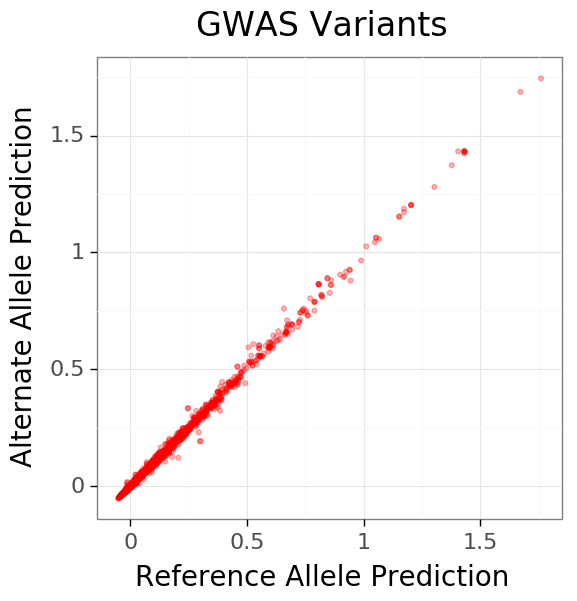

<ggplot: (8728129272766)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
2855,chr17,46057618,46057619,rs62060768,G,A,0.801265,chr17,46704858,6,.,0.299107,0.192368,-0.106739
2854,chr17,46057618,46057619,rs62060768,G,A,1.000000,chr17,46105479,3,.,0.299107,0.192368,-0.106739
738,chr17,45728224,45728225,rs62054388,C,T,0.887600,chr17,46105479,3,.,0.204904,0.121444,-0.083460
603,chr17,45707569,45707570,rs78568882,C,G,0.987348,chr17,46105479,3,.,0.943549,0.879030,-0.064519
839,chr17,45748202,45748203,rs62054436,C,T,0.885546,chr17,46105479,3,.,0.292385,0.230581,-0.061805
4608,chr17,46274492,46274493,rs2668621,T,A,0.815304,chr17,46105479,3,.,0.383641,0.323443,-0.060198
1851,chr17,45936771,45936772,rs12150460,G,T,0.992408,chr17,46105479,3,.,0.178409,0.125217,-0.053193
2941,chr17,46066885,46066886,rs62060799,G,T,0.994940,chr17,46105479,3,.,0.492038,0.440553,-0.051485
39,chr17,45495695,45495696,rs62065452,T,C,0.964781,chr17,46105479,3,.,0.149411,0.105787,-0.043624
1246,chr17,45845576,45845577,rs62621252,T,C,0.992408,chr17,46105479,3,.,0.374831,0.336639,-0.038192


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
3147,chr17,46082684,46082685,rs62060852,G,A,0.992405,chr17,46105479,3,.,0.392658,0.445808,0.053149
2444,chr17,46013726,46013727,rs62062269,G,C,0.801265,chr17,46704858,6,.,0.806761,0.863601,0.056840
2442,chr17,46013726,46013727,rs62062269,G,C,1.000000,chr17,46105479,3,.,0.806761,0.863601,0.056840
2441,chr17,46013726,46013727,rs62062269,G,A,1.000000,chr17,46105479,3,.,0.806761,0.864283,0.057522
2443,chr17,46013726,46013727,rs62062269,G,A,0.801265,chr17,46704858,6,.,0.806761,0.864283,0.057522
862,chr17,45751569,45751570,rs17426106,G,C,0.885546,chr17,46105479,3,.,0.526851,0.607835,0.080984
2487,chr17,46017301,46017302,rs2316948,C,G,0.801265,chr17,46704858,6,.,0.246024,0.333415,0.087391
2486,chr17,46017301,46017302,rs2316948,C,G,1.000000,chr17,46105479,3,.,0.246024,0.333415,0.087391
605,chr17,45707628,45707629,rs62056913,C,T,0.987388,chr17,46105479,3,.,0.505837,0.593753,0.087916
1593,chr17,45897523,45897524,rs62056784,C,G,0.992408,chr17,46105479,3,.,0.657473,0.760279,0.102806


FOLD:  8
All SNPs:


(44, 13)

SNPs in Peaks:


(4, 13)

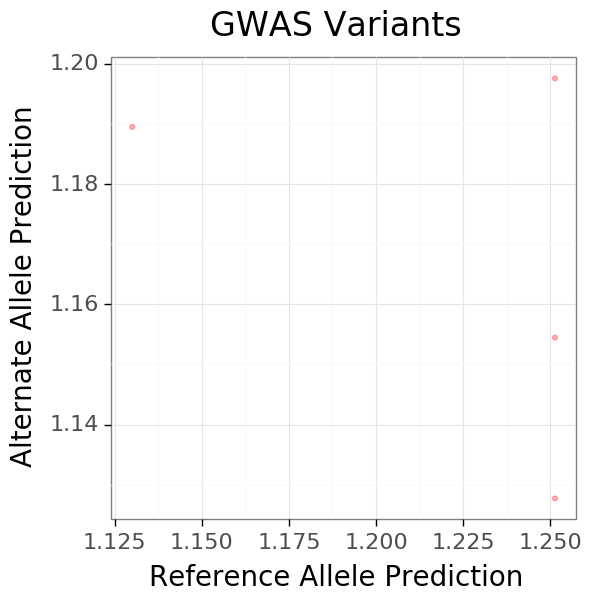

<ggplot: (8728129621547)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
3,chr12,122842051,122842052,rs10847864,G,T,0.815339,chr12,122838013,10,rs10847839,1.251364,1.127739,-0.123625
2,chr12,122842051,122842052,rs10847864,G,C,0.815339,chr12,122838013,10,rs10847839,1.251364,1.154467,-0.096897
1,chr12,122842051,122842052,rs10847864,G,A,0.815339,chr12,122838013,10,rs10847839,1.251364,1.197557,-0.053806
0,chr9,17579692,17579693,rs13294100,T,G,1.000000,chr9,17579692,39,rs13294100,1.130037,1.189479,0.059442


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
3,chr12,122842051,122842052,rs10847864,G,T,0.815339,chr12,122838013,10,rs10847839,1.251364,1.127739,-0.123625
2,chr12,122842051,122842052,rs10847864,G,C,0.815339,chr12,122838013,10,rs10847839,1.251364,1.154467,-0.096897
1,chr12,122842051,122842052,rs10847864,G,A,0.815339,chr12,122838013,10,rs10847839,1.251364,1.197557,-0.053806
0,chr9,17579692,17579693,rs13294100,T,G,1.000000,chr9,17579692,39,rs13294100,1.130037,1.189479,0.059442


SNPs NOT in Peaks:


(38, 13)

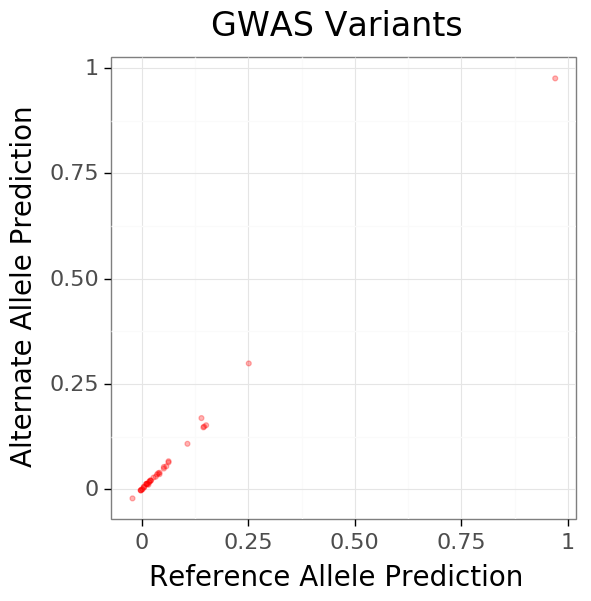

<ggplot: (8728113760639)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
36,chr9,114810887,114810888,rs55914236,C,T,0.816031,chr9,114806968,96,rs55892528,0.041431,0.036124,-0.005308
32,chr12,38022088,38022089,rs564412193,G,A,0.888711,chr12,37566521,18,rs149617467,0.015298,0.011144,-0.004155
18,chr12,39716210,39716211,rs548007023,A,C,1.000000,chr12,40340400,1,rs34637584,0.057353,0.054827,-0.002526
10,chr12,32389884,32389885,rs148707891,G,C,1.000000,chr12,32389884,33,rs148707891,0.032609,0.030103,-0.002506
19,chr12,40158476,40158477,rs187827177,C,A,1.000000,chr12,40340400,1,rs34637584,0.051627,0.049536,-0.002091
35,chr9,114810887,114810888,rs55914236,C,A,0.816031,chr9,114806968,96,rs55892528,0.041431,0.039671,-0.001760
16,chr12,38225761,38225762,rs192829408,G,T,1.000000,chr12,38225761,59,rs192829408,0.000983,-0.000028,-0.001011
29,chr12,37990378,37990379,rs148806299,C,T,0.888711,chr12,37566521,18,rs149617467,0.017676,0.017138,-0.000538
15,chr12,38225761,38225762,rs192829408,G,A,1.000000,chr12,38225761,59,rs192829408,0.000983,0.000491,-0.000493
27,chr12,37733890,37733891,rs191016984,C,G,0.888711,chr12,37566521,18,rs149617467,0.012817,0.012363,-0.000454


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
21,chr12,40597899,40597900,rs190882284,A,G,1.000000,chr12,40340400,1,rs34637584,0.011060,0.013014,0.001953
26,chr12,33065585,33065586,rs117467542,A,G,1.000000,chr12,33075690,16,rs138895122,0.004351,0.006502,0.002151
34,chr12,32358558,32358559,rs185414076,G,A,0.882000,chr12,32389884,33,rs148707891,0.010966,0.013277,0.002311
30,chr12,37999497,37999498,rs184239956,A,G,0.888711,chr12,37566521,18,rs149617467,0.010350,0.013079,0.002729
17,chr9,114806968,114806969,rs55892528,C,T,1.000000,chr9,114806968,96,rs55892528,0.144407,0.147304,0.002897
37,chr9,114819749,114819750,rs2208641,G,A,0.850627,chr9,114806968,96,rs55892528,0.146007,0.148961,0.002954
13,chr9,138121810,138121811,rs2278973,T,A,1.000000,chr9,138121810,48,rs2278973,0.062632,0.066851,0.004219
5,chr12,37566521,37566522,rs149617467,C,T,1.000000,chr12,37566521,18,rs149617467,0.970380,0.975652,0.005271
2,chr12,122838013,122838014,rs10847839,T,C,1.000000,chr12,122838013,10,rs10847839,0.139886,0.169341,0.029455
31,chr12,38008145,38008146,rs74772260,C,T,0.888711,chr12,37566521,18,rs149617467,0.250947,0.299065,0.048118


FOLD:  9
All SNPs:


(14, 13)

SNPs in Peaks:


(1, 13)

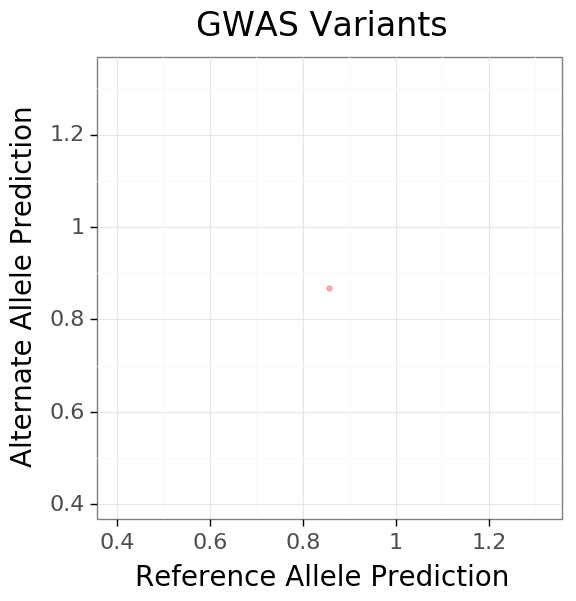

<ggplot: (8728129305997)>

Negative SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr10,119651405,119651406,rs144814361,C,T,1.0,chr10,119651405,15,rs144814361,0.856963,0.867304,0.010341


Positive SNPs in Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
0,chr10,119651405,119651406,rs144814361,C,T,1.0,chr10,119651405,15,rs144814361,0.856963,0.867304,0.010341


SNPs NOT in Peaks:


(11, 13)

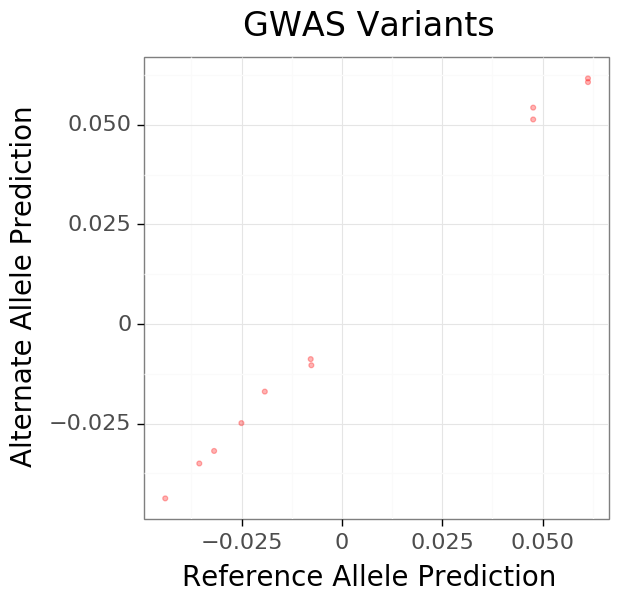

<ggplot: (-9223363308725168857)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
7,chr10,76731020,76731021,rs74860646,T,G,1.000000,chr10,76731020,81,rs74860646,-0.007620,-0.010348,-0.002728
5,chr8,11854934,11854935,rs1293298,A,C,1.000000,chr8,11854934,75,rs1293298,-0.007780,-0.008804,-0.001024
0,chr10,2172585,2172586,rs75482696,T,A,1.000000,chr10,2172585,43,rs75482696,0.061293,0.060690,-0.000604
6,chr8,109740385,109740386,rs72669174,T,A,1.000000,chr8,109740385,79,rs72669174,-0.031841,-0.031846,-0.000005
8,chr8,36255602,36255603,rs76104776,A,C,1.000000,chr8,36255602,101,rs76104776,-0.025046,-0.024859,0.000186
9,chr8,20026413,20026414,rs73208819,T,C,0.833398,chr8,20030802,55,rs73208821,-0.044016,-0.043749,0.000267
1,chr10,2172585,2172586,rs75482696,T,C,1.000000,chr10,2172585,43,rs75482696,0.061293,0.061623,0.000330
4,chr8,20030802,20030803,rs73208821,G,C,1.000000,chr8,20030802,55,rs73208821,-0.035533,-0.034990,0.000543
10,chr10,76742310,76742311,rs17231856,A,C,0.843823,chr10,76731020,81,rs74860646,-0.019214,-0.016958,0.002256
3,chr8,34227886,34227887,rs1446651337,C,G,1.000000,chr8,34227886,51,rs1446651337,0.047643,0.051318,0.003675


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,ID,REF,ALT,R2_WITH_LEAD_SNP,LEAD_CHR,LEAD_POS,LEAD_LOCUS,RSID_LEAD,ref_pred,alt_pred,delta
5,chr8,11854934,11854935,rs1293298,A,C,1.000000,chr8,11854934,75,rs1293298,-0.007780,-0.008804,-0.001024
0,chr10,2172585,2172586,rs75482696,T,A,1.000000,chr10,2172585,43,rs75482696,0.061293,0.060690,-0.000604
6,chr8,109740385,109740386,rs72669174,T,A,1.000000,chr8,109740385,79,rs72669174,-0.031841,-0.031846,-0.000005
8,chr8,36255602,36255603,rs76104776,A,C,1.000000,chr8,36255602,101,rs76104776,-0.025046,-0.024859,0.000186
9,chr8,20026413,20026414,rs73208819,T,C,0.833398,chr8,20030802,55,rs73208821,-0.044016,-0.043749,0.000267
1,chr10,2172585,2172586,rs75482696,T,C,1.000000,chr10,2172585,43,rs75482696,0.061293,0.061623,0.000330
4,chr8,20030802,20030803,rs73208821,G,C,1.000000,chr8,20030802,55,rs73208821,-0.035533,-0.034990,0.000543
10,chr10,76742310,76742311,rs17231856,A,C,0.843823,chr10,76731020,81,rs74860646,-0.019214,-0.016958,0.002256
3,chr8,34227886,34227887,rs1446651337,C,G,1.000000,chr8,34227886,51,rs1446651337,0.047643,0.051318,0.003675
2,chr8,34227886,34227887,rs201891502,C,CT,1.000000,chr8,34227886,51,rs1446651337,0.047643,0.054287,0.006644


In [11]:
get_results_all_folds('PD_GBA1_SUNI')

In [ ]:
get_results_all_folds('AD_CTRL_PARL')

In [ ]:
get_results_all_folds('AD_ADAD_PARL')

In [ ]:
get_results_all_folds('AD_CTRL_HIPP')

In [ ]:
get_results_all_folds('AD_ADAD_HIPP')

In [ ]:
get_results_all_folds('PD_CTRL_HIPP')

In [ ]:
get_results_all_folds('PD_GBA1_HIPP')

In [ ]:
get_results_all_folds('AD_CTRL_SMTG')

In [ ]:
get_results_all_folds('AD_ADAD_SMTG')